## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


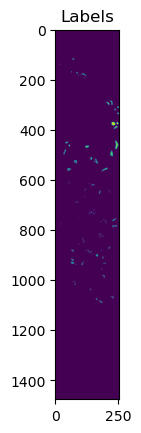

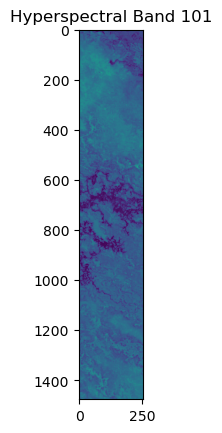

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels


Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(560, 5, 5, 145)
(70, 5, 5, 145)
(2618, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2213, PSNR: -8.0702


Epoch [1/50] Training Loss: 0.2146, PSNR: -8.8660
	[Val]   Batch [1/11] Loss: 0.2059, PSNR: -6.1735
	[Val]   Batch [10/11] Loss: 0.2061, PSNR: -8.4127
Epoch [1/50] Validation Loss: 0.2059, PSNR: -8.1044

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1992, PSNR: -10.2535


Epoch [2/50] Training Loss: 0.1931, PSNR: -8.2864
	[Val]   Batch [1/11] Loss: 0.1809, PSNR: -5.6123
	[Val]   Batch [10/11] Loss: 0.1812, PSNR: -7.8554
Epoch [2/50] Validation Loss: 0.1809, PSNR: -7.5429

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1794, PSNR: -5.5742


Epoch [3/50] Training Loss: 0.1721, PSNR: -7.7224
	[Val]   Batch [1/11] Loss: 0.1557, PSNR: -4.9599
	[Val]   Batch [10/11] Loss: 0.1561, PSNR: -7.2081
Epoch [3/50] Validation Loss: 0.1559, PSNR: -6.8952

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1588, PSNR: -6.6281


Epoch [4/50] Training Loss: 0.1520, PSNR: -7.0968
	[Val]   Batch [1/11] Loss: 0.1384, PSNR: -4.4481
	[Val]   Batch [10/11] Loss: 0.1387, PSNR: -6.6950
Epoch [4/50] Validation Loss: 0.1385, PSNR: -6.3825

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1394, PSNR: -7.3303


Epoch [5/50] Training Loss: 0.1330, PSNR: -6.7789
	[Val]   Batch [1/11] Loss: 0.1194, PSNR: -3.8058
	[Val]   Batch [10/11] Loss: 0.1197, PSNR: -6.0546
Epoch [5/50] Validation Loss: 0.1194, PSNR: -5.7388

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1207, PSNR: -8.1855


Epoch [6/50] Training Loss: 0.1153, PSNR: -5.9056
	[Val]   Batch [1/11] Loss: 0.1030, PSNR: -3.1675
	[Val]   Batch [10/11] Loss: 0.1033, PSNR: -5.4141
Epoch [6/50] Validation Loss: 0.1031, PSNR: -5.0995

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1040, PSNR: -6.6285


Epoch [7/50] Training Loss: 0.0993, PSNR: -5.4639
	[Val]   Batch [1/11] Loss: 0.0881, PSNR: -2.4881
	[Val]   Batch [10/11] Loss: 0.0883, PSNR: -4.7313
Epoch [7/50] Validation Loss: 0.0881, PSNR: -4.4192

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0892, PSNR: -5.4831


Epoch [8/50] Training Loss: 0.0852, PSNR: -4.7593
	[Val]   Batch [1/11] Loss: 0.0762, PSNR: -1.8552
	[Val]   Batch [10/11] Loss: 0.0763, PSNR: -4.0959
Epoch [8/50] Validation Loss: 0.0762, PSNR: -3.7861

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0769, PSNR: -5.6193


Epoch [9/50] Training Loss: 0.0731, PSNR: -4.1492
	[Val]   Batch [1/11] Loss: 0.0655, PSNR: -1.2025
	[Val]   Batch [10/11] Loss: 0.0656, PSNR: -3.4449
Epoch [9/50] Validation Loss: 0.0655, PSNR: -3.1333

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0664, PSNR: -2.8397


Epoch [10/50] Training Loss: 0.0630, PSNR: -3.4524
	[Val]   Batch [1/11] Loss: 0.0573, PSNR: -0.6169
	[Val]   Batch [10/11] Loss: 0.0574, PSNR: -2.8614
Epoch [10/50] Validation Loss: 0.0573, PSNR: -2.5482

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0564, PSNR: -2.7854


Epoch [11/50] Training Loss: 0.0546, PSNR: -2.7802
	[Val]   Batch [1/11] Loss: 0.0496, PSNR: 0.0060
	[Val]   Batch [10/11] Loss: 0.0497, PSNR: -2.2398
Epoch [11/50] Validation Loss: 0.0496, PSNR: -1.9252

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0498, PSNR: -2.8604


Epoch [12/50] Training Loss: 0.0477, PSNR: -2.3422
	[Val]   Batch [1/11] Loss: 0.0441, PSNR: 0.5231
	[Val]   Batch [10/11] Loss: 0.0441, PSNR: -1.7219
Epoch [12/50] Validation Loss: 0.0441, PSNR: -1.4086

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0438, PSNR: -2.3919


Epoch [13/50] Training Loss: 0.0419, PSNR: -1.6561
	[Val]   Batch [1/11] Loss: 0.0391, PSNR: 1.0434
	[Val]   Batch [10/11] Loss: 0.0392, PSNR: -1.2022
Epoch [13/50] Validation Loss: 0.0391, PSNR: -0.8888

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0386, PSNR: -3.1651


Epoch [14/50] Training Loss: 0.0372, PSNR: -1.3025
	[Val]   Batch [1/11] Loss: 0.0349, PSNR: 1.5395
	[Val]   Batch [10/11] Loss: 0.0349, PSNR: -0.7061
Epoch [14/50] Validation Loss: 0.0349, PSNR: -0.3926

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0345, PSNR: -2.6367


Epoch [15/50] Training Loss: 0.0332, PSNR: -0.8476
	[Val]   Batch [1/11] Loss: 0.0314, PSNR: 1.9947
	[Val]   Batch [10/11] Loss: 0.0315, PSNR: -0.2506
Epoch [15/50] Validation Loss: 0.0314, PSNR: 0.0627

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0309, PSNR: 0.1260


Epoch [16/50] Training Loss: 0.0298, PSNR: -0.4111
	[Val]   Batch [1/11] Loss: 0.0283, PSNR: 2.4422
	[Val]   Batch [10/11] Loss: 0.0284, PSNR: 0.1973
Epoch [16/50] Validation Loss: 0.0283, PSNR: 0.5103

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0278, PSNR: -0.4201


Epoch [17/50] Training Loss: 0.0269, PSNR: 0.1476
	[Val]   Batch [1/11] Loss: 0.0257, PSNR: 2.8700
	[Val]   Batch [10/11] Loss: 0.0257, PSNR: 0.6252
Epoch [17/50] Validation Loss: 0.0257, PSNR: 0.9383

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0251, PSNR: 2.9594


Epoch [18/50] Training Loss: 0.0245, PSNR: 0.6879
	[Val]   Batch [1/11] Loss: 0.0234, PSNR: 3.2630
	[Val]   Batch [10/11] Loss: 0.0235, PSNR: 1.0187
Epoch [18/50] Validation Loss: 0.0234, PSNR: 1.3320

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0231, PSNR: -0.1012


Epoch [19/50] Training Loss: 0.0223, PSNR: 1.0224
	[Val]   Batch [1/11] Loss: 0.0216, PSNR: 3.6257
	[Val]   Batch [10/11] Loss: 0.0216, PSNR: 1.3826
Epoch [19/50] Validation Loss: 0.0216, PSNR: 1.6947

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0213, PSNR: -0.0483


Epoch [20/50] Training Loss: 0.0205, PSNR: 1.3589
	[Val]   Batch [1/11] Loss: 0.0197, PSNR: 4.0290
	[Val]   Batch [10/11] Loss: 0.0197, PSNR: 1.7857
Epoch [20/50] Validation Loss: 0.0197, PSNR: 2.0979

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0188, PSNR: 1.9950


Epoch [21/50] Training Loss: 0.0189, PSNR: 1.6541
	[Val]   Batch [1/11] Loss: 0.0183, PSNR: 4.3410
	[Val]   Batch [10/11] Loss: 0.0183, PSNR: 2.0977
Epoch [21/50] Validation Loss: 0.0183, PSNR: 2.4105

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0180, PSNR: 2.4854


Epoch [22/50] Training Loss: 0.0174, PSNR: 2.2797
	[Val]   Batch [1/11] Loss: 0.0170, PSNR: 4.6551
	[Val]   Batch [10/11] Loss: 0.0170, PSNR: 2.4106
Epoch [22/50] Validation Loss: 0.0170, PSNR: 2.7246

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0162, PSNR: 1.9395


Epoch [23/50] Training Loss: 0.0161, PSNR: 2.5415
	[Val]   Batch [1/11] Loss: 0.0156, PSNR: 5.0197
	[Val]   Batch [10/11] Loss: 0.0157, PSNR: 2.7734
Epoch [23/50] Validation Loss: 0.0156, PSNR: 3.0896

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0151, PSNR: 3.2329


Epoch [24/50] Training Loss: 0.0150, PSNR: 2.7597
	[Val]   Batch [1/11] Loss: 0.0146, PSNR: 5.3182
	[Val]   Batch [10/11] Loss: 0.0146, PSNR: 3.0716
Epoch [24/50] Validation Loss: 0.0146, PSNR: 3.3885

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0140, PSNR: 2.5602


Epoch [25/50] Training Loss: 0.0139, PSNR: 3.0503
	[Val]   Batch [1/11] Loss: 0.0136, PSNR: 5.6291
	[Val]   Batch [10/11] Loss: 0.0136, PSNR: 3.3821
Epoch [25/50] Validation Loss: 0.0136, PSNR: 3.6993

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0134, PSNR: 1.4147


Epoch [26/50] Training Loss: 0.0130, PSNR: 3.3321
	[Val]   Batch [1/11] Loss: 0.0127, PSNR: 5.9136
	[Val]   Batch [10/11] Loss: 0.0128, PSNR: 3.6680
Epoch [26/50] Validation Loss: 0.0127, PSNR: 3.9837

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0122, PSNR: 4.5011


Epoch [27/50] Training Loss: 0.0121, PSNR: 3.7374
	[Val]   Batch [1/11] Loss: 0.0119, PSNR: 6.1943
	[Val]   Batch [10/11] Loss: 0.0120, PSNR: 3.9482
Epoch [27/50] Validation Loss: 0.0119, PSNR: 4.2648

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0115, PSNR: 6.3649


Epoch [28/50] Training Loss: 0.0114, PSNR: 3.7311
	[Val]   Batch [1/11] Loss: 0.0112, PSNR: 6.4704
	[Val]   Batch [10/11] Loss: 0.0112, PSNR: 4.2243
Epoch [28/50] Validation Loss: 0.0112, PSNR: 4.5413

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0114, PSNR: 3.4577


Epoch [29/50] Training Loss: 0.0107, PSNR: 4.2716
	[Val]   Batch [1/11] Loss: 0.0106, PSNR: 6.7185
	[Val]   Batch [10/11] Loss: 0.0106, PSNR: 4.4725
Epoch [29/50] Validation Loss: 0.0106, PSNR: 4.7896

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0101, PSNR: 3.9765


Epoch [30/50] Training Loss: 0.0101, PSNR: 4.4918
	[Val]   Batch [1/11] Loss: 0.0099, PSNR: 6.9914
	[Val]   Batch [10/11] Loss: 0.0100, PSNR: 4.7448
Epoch [30/50] Validation Loss: 0.0099, PSNR: 5.0626

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0096, PSNR: 4.2985


Epoch [31/50] Training Loss: 0.0095, PSNR: 4.8569
	[Val]   Batch [1/11] Loss: 0.0093, PSNR: 7.2598
	[Val]   Batch [10/11] Loss: 0.0094, PSNR: 5.0129
Epoch [31/50] Validation Loss: 0.0093, PSNR: 5.3315

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0092, PSNR: 3.4027


Epoch [32/50] Training Loss: 0.0090, PSNR: 4.9886
	[Val]   Batch [1/11] Loss: 0.0088, PSNR: 7.4997
	[Val]   Batch [10/11] Loss: 0.0089, PSNR: 5.2534
Epoch [32/50] Validation Loss: 0.0088, PSNR: 5.5716

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0088, PSNR: 5.9312


Epoch [33/50] Training Loss: 0.0085, PSNR: 5.1925
	[Val]   Batch [1/11] Loss: 0.0084, PSNR: 7.7356
	[Val]   Batch [10/11] Loss: 0.0084, PSNR: 5.4892
Epoch [33/50] Validation Loss: 0.0084, PSNR: 5.8070

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0084, PSNR: 3.1674


Epoch [34/50] Training Loss: 0.0080, PSNR: 5.4353
	[Val]   Batch [1/11] Loss: 0.0080, PSNR: 7.9567
	[Val]   Batch [10/11] Loss: 0.0080, PSNR: 5.7102
Epoch [34/50] Validation Loss: 0.0080, PSNR: 6.0280

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0079, PSNR: 7.9879


Epoch [35/50] Training Loss: 0.0076, PSNR: 5.6327
	[Val]   Batch [1/11] Loss: 0.0075, PSNR: 8.1986
	[Val]   Batch [10/11] Loss: 0.0075, PSNR: 5.9515
Epoch [35/50] Validation Loss: 0.0075, PSNR: 6.2696

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0073, PSNR: 4.1341


Epoch [36/50] Training Loss: 0.0072, PSNR: 5.7734
	[Val]   Batch [1/11] Loss: 0.0072, PSNR: 8.4132
	[Val]   Batch [10/11] Loss: 0.0072, PSNR: 6.1661
Epoch [36/50] Validation Loss: 0.0072, PSNR: 6.4844

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0070, PSNR: 6.2633


Epoch [37/50] Training Loss: 0.0069, PSNR: 6.2653
	[Val]   Batch [1/11] Loss: 0.0068, PSNR: 8.6185
	[Val]   Batch [10/11] Loss: 0.0068, PSNR: 6.3724
Epoch [37/50] Validation Loss: 0.0068, PSNR: 6.6909

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 4.5545


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.3314
	[Val]   Batch [1/11] Loss: 0.0065, PSNR: 8.8359
	[Val]   Batch [10/11] Loss: 0.0065, PSNR: 6.5896
Epoch [38/50] Validation Loss: 0.0065, PSNR: 6.9086

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0063, PSNR: 5.0559


Epoch [39/50] Training Loss: 0.0062, PSNR: 6.4340
	[Val]   Batch [1/11] Loss: 0.0062, PSNR: 9.0277
	[Val]   Batch [10/11] Loss: 0.0062, PSNR: 6.7819
Epoch [39/50] Validation Loss: 0.0062, PSNR: 7.1008

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 7.0737


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.6651
	[Val]   Batch [1/11] Loss: 0.0059, PSNR: 9.2468
	[Val]   Batch [10/11] Loss: 0.0059, PSNR: 7.0002
Epoch [40/50] Validation Loss: 0.0059, PSNR: 7.3201

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 7.5654


Epoch [41/50] Training Loss: 0.0057, PSNR: 7.0422
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4391
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1922
Epoch [41/50] Validation Loss: 0.0056, PSNR: 7.5132

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 6.4045


Epoch [42/50] Training Loss: 0.0054, PSNR: 7.1821
	[Val]   Batch [1/11] Loss: 0.0054, PSNR: 9.6391
	[Val]   Batch [10/11] Loss: 0.0054, PSNR: 7.3922
Epoch [42/50] Validation Loss: 0.0054, PSNR: 7.7130

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0052, PSNR: 9.8222


Epoch [43/50] Training Loss: 0.0052, PSNR: 7.3636
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.8276
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5818
Epoch [43/50] Validation Loss: 0.0052, PSNR: 7.9021

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 7.0777


Epoch [44/50] Training Loss: 0.0050, PSNR: 7.6781
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0182
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7723
Epoch [44/50] Validation Loss: 0.0049, PSNR: 8.0928

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 6.2599


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.6351
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1669
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.9210
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.2420

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 8.6940


Epoch [46/50] Training Loss: 0.0046, PSNR: 7.9119
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3514
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.1058
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.4271

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 6.2838


Epoch [47/50] Training Loss: 0.0044, PSNR: 8.1107
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5118
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.2667
Epoch [47/50] Validation Loss: 0.0044, PSNR: 8.5874

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 6.7180


Epoch [48/50] Training Loss: 0.0042, PSNR: 8.3726
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7358
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.4896
Epoch [48/50] Validation Loss: 0.0042, PSNR: 8.8114

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 10.6931


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.3221
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8535
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.6087
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.9293

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 10.9702


Epoch [50/50] Training Loss: 0.0039, PSNR: 8.7484
	[Val]   Batch [1/11] Loss: 0.0039, PSNR: 11.0324
	[Val]   Batch [10/11] Loss: 0.0039, PSNR: 8.7872
Epoch [50/50] Validation Loss: 0.0039, PSNR: 9.1085


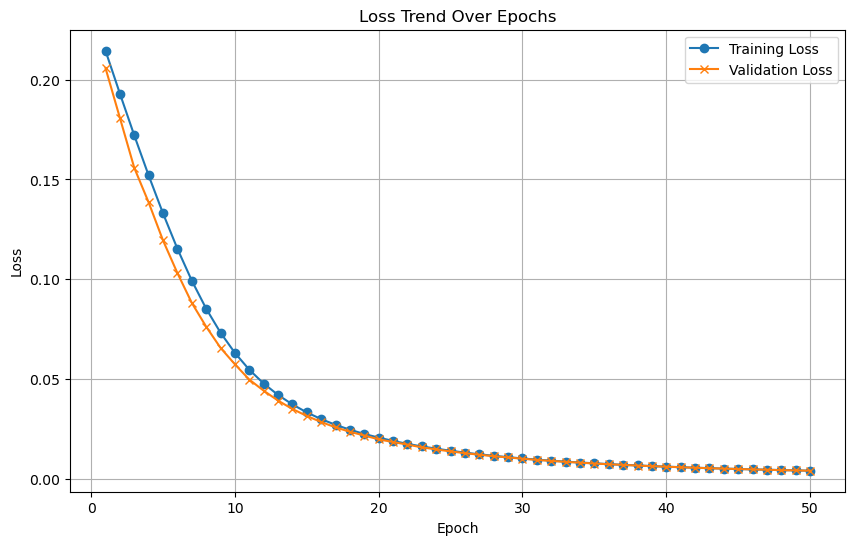

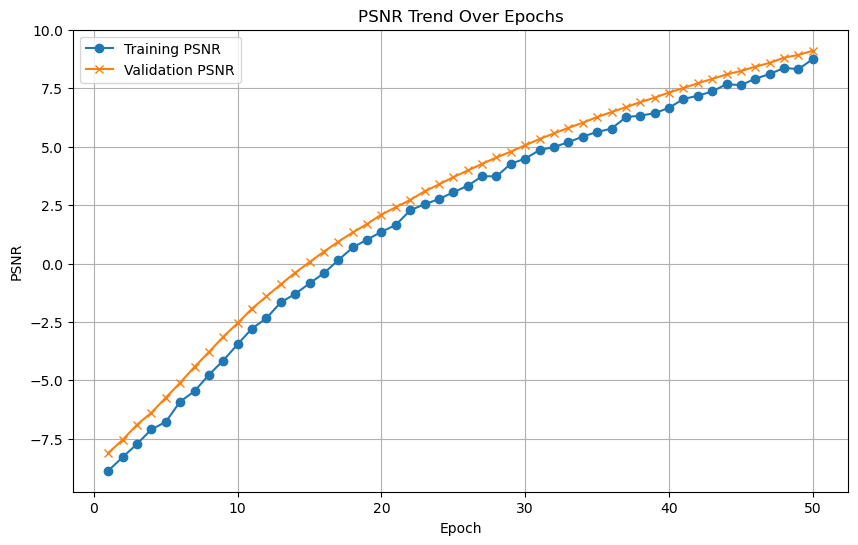

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/11 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6261
    Validation Batch [1/1], Loss: 2.6475
Validation Loss: 2.6475, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6475. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5741
    Validation Batch [1/1], Loss: 2.6476
Validation Loss: 2.6476, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5469
    Validation Batch [1/1], Loss: 2.6477
Validation Loss: 2.6477, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5247
    Validation Batch [1/1], Loss: 2.6478
Validation Loss: 2.6478, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.4984
    Validati

Epoch [10/1000] completed, Average Training Loss: 2.3881
    Validation Batch [1/1], Loss: 2.6481
Validation Loss: 2.6481, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.3716
    Validation Batch [1/1], Loss: 2.6481
Validation Loss: 2.6481, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.3462
    Validation Batch [1/1], Loss: 2.6481
Validation Loss: 2.6481, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.3247
    Validation Batch [1/1], Loss: 2.6481
Validation Loss: 2.6481, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.3135
    Validati

    Validation Batch [1/1], Loss: 2.6471
Validation Loss: 2.6471, Validation Accuracy: 7.14%
Validation loss improved from 2.6475 to 2.6471. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.2537
    Validation Batch [1/1], Loss: 2.6463
Validation Loss: 2.6463, Validation Accuracy: 7.14%
Validation loss improved from 2.6471 to 2.6463. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.2384
    Validation Batch [1/1], Loss: 2.6455
Validation Loss: 2.6455, Validation Accuracy: 7.14%
Validation loss improved from 2.6463 to 2.6455. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.2241
    Validation Batch [1/1], Loss: 2.6446
Validation Loss: 2.6446, Validation Accuracy: 7.14%
Validation loss improved from 2.6455 to 2.6446. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.2024
    Validati

Epoch [24/1000] completed, Average Training Loss: 2.1381
    Validation Batch [1/1], Loss: 2.6350
Validation Loss: 2.6350, Validation Accuracy: 7.14%
Validation loss improved from 2.6373 to 2.6350. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.1212
    Validation Batch [1/1], Loss: 2.6322
Validation Loss: 2.6322, Validation Accuracy: 7.14%
Validation loss improved from 2.6350 to 2.6322. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.1091
    Validation Batch [1/1], Loss: 2.6276
Validation Loss: 2.6276, Validation Accuracy: 7.14%
Validation loss improved from 2.6322 to 2.6276. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.0834
    Validation Batch [1/1], Loss: 2.6214
Validation Loss: 2.6214, Validation Accuracy: 7.14%
Validation loss improved from 2.6276 to 2.6214. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/10

Epoch [30/1000] completed, Average Training Loss: 2.0251
    Validation Batch [1/1], Loss: 2.5816
Validation Loss: 2.5816, Validation Accuracy: 7.14%
Validation loss improved from 2.5991 to 2.5816. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.0143
    Validation Batch [1/1], Loss: 2.5634
Validation Loss: 2.5634, Validation Accuracy: 7.14%
Validation loss improved from 2.5816 to 2.5634. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 1.9839
    Validation Batch [1/1], Loss: 2.5444
Validation Loss: 2.5444, Validation Accuracy: 8.57%
Validation loss improved from 2.5634 to 2.5444. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 1.9759
    Validation Batch [1/1], Loss: 2.5210
Validation Loss: 2.5210, Validation Accuracy: 11.43%
Validation loss improved from 2.5444 to 2.5210. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1

Epoch [38/1000] completed, Average Training Loss: 1.8928
    Validation Batch [1/1], Loss: 2.3213
Validation Loss: 2.3213, Validation Accuracy: 50.00%
Validation loss improved from 2.3628 to 2.3213. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.8742
    Validation Batch [1/1], Loss: 2.2723
Validation Loss: 2.2723, Validation Accuracy: 58.57%
Validation loss improved from 2.3213 to 2.2723. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.8396
    Validation Batch [1/1], Loss: 2.1923
Validation Loss: 2.1923, Validation Accuracy: 60.00%
Validation loss improved from 2.2723 to 2.1923. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.8260
    Validation Batch [1/1], Loss: 2.1176
Validation Loss: 2.1176, Validation Accuracy: 61.43%
Validation loss improved from 2.1923 to 2.1176. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

Epoch [45/1000] completed, Average Training Loss: 1.7677
    Validation Batch [1/1], Loss: 1.9409
Validation Loss: 1.9409, Validation Accuracy: 64.29%
Validation loss improved from 1.9936 to 1.9409. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.7432
    Validation Batch [1/1], Loss: 1.8935
Validation Loss: 1.8935, Validation Accuracy: 64.29%
Validation loss improved from 1.9409 to 1.8935. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 1.7429
    Validation Batch [1/1], Loss: 1.8475
Validation Loss: 1.8475, Validation Accuracy: 65.71%
Validation loss improved from 1.8935 to 1.8475. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 1.7193
    Validation Batch [1/1], Loss: 1.7782
Validation Loss: 1.7782, Validation Accuracy: 65.71%
Validation loss improved from 1.8475 to 1.7782. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [4

Epoch [52/1000] completed, Average Training Loss: 1.6422
    Validation Batch [1/1], Loss: 1.6554
Validation Loss: 1.6554, Validation Accuracy: 68.57%
Validation loss improved from 1.6661 to 1.6554. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.6299
    Validation Batch [1/1], Loss: 1.6628
Validation Loss: 1.6628, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.6244
    Validation Batch [1/1], Loss: 1.6051
Validation Loss: 1.6051, Validation Accuracy: 68.57%
Validation loss improved from 1.6554 to 1.6051. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.6178
    Validation Batch [1/1], Loss: 1.5693
Validation Loss: 1.5693, Validation Accuracy: 68.57%
Validation loss improved from 1.6051 to 1.5693. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] complet

Epoch [60/1000] completed, Average Training Loss: 1.5050
    Validation Batch [1/1], Loss: 1.4795
Validation Loss: 1.4795, Validation Accuracy: 71.43%
Validation loss improved from 1.4998 to 1.4795. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 1.4995
    Validation Batch [1/1], Loss: 1.4537
Validation Loss: 1.4537, Validation Accuracy: 72.86%
Validation loss improved from 1.4795 to 1.4537. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.4872
    Validation Batch [1/1], Loss: 1.4470
Validation Loss: 1.4470, Validation Accuracy: 74.29%
Validation loss improved from 1.4537 to 1.4470. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.4681
    Validation Batch [1/1], Loss: 1.4295
Validation Loss: 1.4295, Validation Accuracy: 71.43%
Validation loss improved from 1.4470 to 1.4295. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [6

Epoch [67/1000] completed, Average Training Loss: 1.3983
    Validation Batch [1/1], Loss: 1.3626
Validation Loss: 1.3626, Validation Accuracy: 72.86%
Validation loss improved from 1.3934 to 1.3626. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.3647
    Validation Batch [1/1], Loss: 1.3598
Validation Loss: 1.3598, Validation Accuracy: 74.29%
Validation loss improved from 1.3626 to 1.3598. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3419
    Validation Batch [1/1], Loss: 1.3149
Validation Loss: 1.3149, Validation Accuracy: 80.00%
Validation loss improved from 1.3598 to 1.3149. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.3467
    Validation Batch [1/1], Loss: 1.3158
Validation Loss: 1.3158, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [71/1000] - Training
Epoch [71/1000] complet

Epoch [74/1000] completed, Average Training Loss: 1.2966
    Validation Batch [1/1], Loss: 1.2315
Validation Loss: 1.2315, Validation Accuracy: 78.57%
Validation loss improved from 1.2858 to 1.2315. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.2847
    Validation Batch [1/1], Loss: 1.2841
Validation Loss: 1.2841, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.2510
    Validation Batch [1/1], Loss: 1.2247
Validation Loss: 1.2247, Validation Accuracy: 80.00%
Validation loss improved from 1.2315 to 1.2247. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.2369
    Validation Batch [1/1], Loss: 1.2040
Validation Loss: 1.2040, Validation Accuracy: 78.57%
Validation loss improved from 1.2247 to 1.2040. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] complet

Epoch [81/1000] completed, Average Training Loss: 1.1773
    Validation Batch [1/1], Loss: 1.1534
Validation Loss: 1.1534, Validation Accuracy: 82.86%
Validation loss improved from 1.1674 to 1.1534. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.1679
    Validation Batch [1/1], Loss: 1.1245
Validation Loss: 1.1245, Validation Accuracy: 80.00%
Validation loss improved from 1.1534 to 1.1245. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.1426
    Validation Batch [1/1], Loss: 1.1199
Validation Loss: 1.1199, Validation Accuracy: 78.57%
Validation loss improved from 1.1245 to 1.1199. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.1293
    Validation Batch [1/1], Loss: 1.1189
Validation Loss: 1.1189, Validation Accuracy: 85.71%
Validation loss improved from 1.1199 to 1.1189. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [8

Epoch [88/1000] completed, Average Training Loss: 1.0854
    Validation Batch [1/1], Loss: 1.0481
Validation Loss: 1.0481, Validation Accuracy: 80.00%
Validation loss improved from 1.0629 to 1.0481. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.0895
    Validation Batch [1/1], Loss: 1.0501
Validation Loss: 1.0501, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.0461
    Validation Batch [1/1], Loss: 1.0171
Validation Loss: 1.0171, Validation Accuracy: 80.00%
Validation loss improved from 1.0481 to 1.0171. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.0395
    Validation Batch [1/1], Loss: 1.0276
Validation Loss: 1.0276, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Tra

Epoch [95/1000] completed, Average Training Loss: 0.9828
    Validation Batch [1/1], Loss: 0.9564
Validation Loss: 0.9564, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 0.9841
    Validation Batch [1/1], Loss: 0.9570
Validation Loss: 0.9570, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 0.9550
    Validation Batch [1/1], Loss: 0.9057
Validation Loss: 0.9057, Validation Accuracy: 92.86%
Validation loss improved from 0.9492 to 0.9057. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 0.9532
    Validation Batch [1/1], Loss: 0.8867
Validation Loss: 0.8867, Validation Accuracy: 85.71%
Validation loss improved from 0.9057 to 0.8867. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Tra

Epoch [102/1000] completed, Average Training Loss: 0.9099
    Validation Batch [1/1], Loss: 0.8748
Validation Loss: 0.8748, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 0.8977
    Validation Batch [1/1], Loss: 0.8370
Validation Loss: 0.8370, Validation Accuracy: 92.86%
Validation loss improved from 0.8547 to 0.8370. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 0.8882
    Validation Batch [1/1], Loss: 0.8411
Validation Loss: 0.8411, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 0.8718
    Validation Batch [1/1], Loss: 0.8096
Validation Loss: 0.8096, Validation Accuracy: 92.86%
Validation loss improved from 0.8370 to 0.8096. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Av

Epoch [110/1000] completed, Average Training Loss: 0.8150
    Validation Batch [1/1], Loss: 0.7867
Validation Loss: 0.7867, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.7826
    Validation Batch [1/1], Loss: 0.7458
Validation Loss: 0.7458, Validation Accuracy: 94.29%
Validation loss improved from 0.7703 to 0.7458. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 0.7996
    Validation Batch [1/1], Loss: 0.7721
Validation Loss: 0.7721, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 0.7846
    Validation Batch [1/1], Loss: 0.7315
Validation Loss: 0.7315, Validation Accuracy: 94.29%
Validation loss improved from 0.7458 to 0.7315. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Av

Epoch [116/1000] completed, Average Training Loss: 0.7560
    Validation Batch [1/1], Loss: 0.7030
Validation Loss: 0.7030, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.7229
    Validation Batch [1/1], Loss: 0.6994
Validation Loss: 0.6994, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.7175
    Validation Batch [1/1], Loss: 0.6643
Validation Loss: 0.6643, Validation Accuracy: 98.57%
Validation loss improved from 0.6894 to 0.6643. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.7165
    Validation Batch [1/1], Loss: 0.6740
Validation Loss: 0.6740, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.6352
Validation Loss: 0.6352, Validation Accuracy: 97.14%
Validation loss improved from 0.6376 to 0.6352. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.6584
    Validation Batch [1/1], Loss: 0.6295
Validation Loss: 0.6295, Validation Accuracy: 94.29%
Validation loss improved from 0.6352 to 0.6295. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.6442
    Validation Batch [1/1], Loss: 0.5857
Validation Loss: 0.5857, Validation Accuracy: 97.14%
Validation loss improved from 0.6295 to 0.5857. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.6364
    Validation Batch [1/1], Loss: 0.5732
Validation Loss: 0.5732, Validation Accuracy: 97.14%
Validation loss improved from 0.5857 to 0.5732. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.6229


Epoch [132/1000] completed, Average Training Loss: 0.5766
    Validation Batch [1/1], Loss: 0.5391
Validation Loss: 0.5391, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.5697
    Validation Batch [1/1], Loss: 0.5969
Validation Loss: 0.5969, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 0.5724
    Validation Batch [1/1], Loss: 0.5533
Validation Loss: 0.5533, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.5404
    Validation Batch [1/1], Loss: 0.5029
Validation Loss: 0.5029, Validation Accuracy: 98.57%
Validation loss improved from 0.5300 to 0.5029. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training 

Epoch [138/1000] completed, Average Training Loss: 0.5404
    Validation Batch [1/1], Loss: 0.4743
Validation Loss: 0.4743, Validation Accuracy: 95.71%
Validation loss improved from 0.5029 to 0.4743. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.5217
    Validation Batch [1/1], Loss: 0.4688
Validation Loss: 0.4688, Validation Accuracy: 98.57%
Validation loss improved from 0.4743 to 0.4688. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.5072
    Validation Batch [1/1], Loss: 0.5700
Validation Loss: 0.5700, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.4915
    Validation Batch [1/1], Loss: 0.4587
Validation Loss: 0.4587, Validation Accuracy: 95.71%
Validation loss improved from 0.4688 to 0.4587. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000

Epoch [147/1000] completed, Average Training Loss: 0.4438
    Validation Batch [1/1], Loss: 0.4189
Validation Loss: 0.4189, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.4261
    Validation Batch [1/1], Loss: 0.4650
Validation Loss: 0.4650, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.3994
    Validation Batch [1/1], Loss: 0.3848
Validation Loss: 0.3848, Validation Accuracy: 98.57%
Validation loss improved from 0.4078 to 0.3848. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.4118
    Validation Batch [1/1], Loss: 0.3784
Validation Loss: 0.3784, Validation Accuracy: 97.14%
Validation loss improved from 0.3848 to 0.3784. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Av

Epoch [152/1000] completed, Average Training Loss: 0.3969
    Validation Batch [1/1], Loss: 0.3540
Validation Loss: 0.3540, Validation Accuracy: 98.57%
Validation loss improved from 0.3784 to 0.3540. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.3878
    Validation Batch [1/1], Loss: 0.3284
Validation Loss: 0.3284, Validation Accuracy: 98.57%
Validation loss improved from 0.3540 to 0.3284. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.3785
    Validation Batch [1/1], Loss: 0.3659
Validation Loss: 0.3659, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.3898
    Validation Batch [1/1], Loss: 0.3558
Validation Loss: 0.3558, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Av

Epoch [161/1000] completed, Average Training Loss: 0.3400
    Validation Batch [1/1], Loss: 0.2857
Validation Loss: 0.2857, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.3336
    Validation Batch [1/1], Loss: 0.2984
Validation Loss: 0.2984, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.3236
    Validation Batch [1/1], Loss: 0.2881
Validation Loss: 0.2881, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.3386
    Validation Batch [1/1], Loss: 0.2786
Validation Loss: 0.2786, Validation Accuracy: 97.14%
Validation loss improved from 0.2836 to 0.2786. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training 

Epoch [166/1000] completed, Average Training Loss: 0.3038
    Validation Batch [1/1], Loss: 0.2732
Validation Loss: 0.2732, Validation Accuracy: 97.14%
Validation loss improved from 0.2740 to 0.2732. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.3049
    Validation Batch [1/1], Loss: 0.2841
Validation Loss: 0.2841, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.3017
    Validation Batch [1/1], Loss: 0.2570
Validation Loss: 0.2570, Validation Accuracy: 97.14%
Validation loss improved from 0.2732 to 0.2570. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.2938
    Validation Batch [1/1], Loss: 0.2554
Validation Loss: 0.2554, Validation Accuracy: 98.57%
Validation loss improved from 0.2570 to 0.2554. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000

Epoch [177/1000] completed, Average Training Loss: 0.2558
    Validation Batch [1/1], Loss: 0.2415
Validation Loss: 0.2415, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.2361
    Validation Batch [1/1], Loss: 0.2384
Validation Loss: 0.2384, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.2326
    Validation Batch [1/1], Loss: 0.2184
Validation Loss: 0.2184, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [180/1000] - Training


Epoch [180/1000] completed, Average Training Loss: 0.2369
    Validation Batch [1/1], Loss: 0.1962
Validation Loss: 0.1962, Validation Accuracy: 98.57%
Validation loss improved from 0.2039 to 0.1962. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.2271
    Validation Batch [1/1], Loss: 0.2001
Validation Loss: 0.2001, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 0.2279
    Validation Batch [1/1], Loss: 0.1869
Validation Loss: 0.1869, Validation Accuracy: 98.57%
Validation loss improved from 0.1962 to 0.1869. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.2281
    Validation Batch [1/1], Loss: 0.1874
Validation Loss: 0.1874, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Av

Epoch [191/1000] completed, Average Training Loss: 0.1886
    Validation Batch [1/1], Loss: 0.1653
Validation Loss: 0.1653, Validation Accuracy: 97.14%
Validation loss improved from 0.1829 to 0.1653. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.1885
    Validation Batch [1/1], Loss: 0.1812
Validation Loss: 0.1812, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.1977
    Validation Batch [1/1], Loss: 0.1713
Validation Loss: 0.1713, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.1876
    Validation Batch [1/1], Loss: 0.1601
Validation Loss: 0.1601, Validation Accuracy: 98.57%
Validation loss improved from 0.1653 to 0.1601. Saving model...

LOG: Epoch [195/1000] - Training


Epoch [195/1000] completed, Average Training Loss: 0.1911
    Validation Batch [1/1], Loss: 0.1777
Validation Loss: 0.1777, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.1739
    Validation Batch [1/1], Loss: 0.1748
Validation Loss: 0.1748, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.1837
    Validation Batch [1/1], Loss: 0.1622
Validation Loss: 0.1622, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.1756
    Validation Batch [1/1], Loss: 0.1683
Validation Loss: 0.1683, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.1775
  

Epoch [205/1000] completed, Average Training Loss: 0.1559
    Validation Batch [1/1], Loss: 0.1546
Validation Loss: 0.1546, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [206/1000] - Training


Epoch [206/1000] completed, Average Training Loss: 0.1561
    Validation Batch [1/1], Loss: 0.1788
Validation Loss: 0.1788, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.1691
    Validation Batch [1/1], Loss: 0.1324
Validation Loss: 0.1324, Validation Accuracy: 98.57%
Validation loss improved from 0.1470 to 0.1324. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.1516
    Validation Batch [1/1], Loss: 0.1228
Validation Loss: 0.1228, Validation Accuracy: 98.57%
Validation loss improved from 0.1324 to 0.1228. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.1473
    Validation Batch [1/1], Loss: 0.2058
Validation Loss: 0.2058, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Av

Epoch [214/1000] completed, Average Training Loss: 0.1356
    Validation Batch [1/1], Loss: 0.1541
Validation Loss: 0.1541, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.1403
    Validation Batch [1/1], Loss: 0.1273
Validation Loss: 0.1273, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.1419
    Validation Batch [1/1], Loss: 0.1223
Validation Loss: 0.1223, Validation Accuracy: 98.57%
Validation loss improved from 0.1223 to 0.1223. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.1343
    Validation Batch [1/1], Loss: 0.1158
Validation Loss: 0.1158, Validation Accuracy: 98.57%
Validation loss improved from 0.1223 to 0.1158. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Av

Epoch [220/1000] completed, Average Training Loss: 0.1342
    Validation Batch [1/1], Loss: 0.1252
Validation Loss: 0.1252, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.1220
    Validation Batch [1/1], Loss: 0.1289
Validation Loss: 0.1289, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.1215
    Validation Batch [1/1], Loss: 0.1109
Validation Loss: 0.1109, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 0.1091
Validation Loss: 0.1091, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.1242
  

Epoch [228/1000] completed, Average Training Loss: 0.1138
    Validation Batch [1/1], Loss: 0.1059
Validation Loss: 0.1059, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.1069
    Validation Batch [1/1], Loss: 0.1144
Validation Loss: 0.1144, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1064
    Validation Batch [1/1], Loss: 0.1205
Validation Loss: 0.1205, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1134
    Validation Batch [1/1], Loss: 0.1108
Validation Loss: 0.1108, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.1193

Epoch [234/1000] completed, Average Training Loss: 0.1036
    Validation Batch [1/1], Loss: 0.1125
Validation Loss: 0.1125, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.0957
    Validation Batch [1/1], Loss: 0.1377
Validation Loss: 0.1377, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.1080
    Validation Batch [1/1], Loss: 0.1238
Validation Loss: 0.1238, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.0940
    Validation Batch [1/1], Loss: 0.1069
Validation Loss: 0.1069, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.1055
  

Epoch [242/1000] completed, Average Training Loss: 0.1041
    Validation Batch [1/1], Loss: 0.0998
Validation Loss: 0.0998, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.1050
    Validation Batch [1/1], Loss: 0.1002
Validation Loss: 0.1002, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.0993
Validation Loss: 0.0993, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.0926
    Validation Batch [1/1], Loss: 0.0951
Validation Loss: 0.0951, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.0902
  

Epoch [248/1000] completed, Average Training Loss: 0.0949
    Validation Batch [1/1], Loss: 0.1046
Validation Loss: 0.1046, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.0896
    Validation Batch [1/1], Loss: 0.1013
Validation Loss: 0.1013, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.0934
    Validation Batch [1/1], Loss: 0.1135
Validation Loss: 0.1135, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.0851
    Validation Batch [1/1], Loss: 0.1183
Validation Loss: 0.1183, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.0953

Epoch [258/1000] completed, Average Training Loss: 0.0801
    Validation Batch [1/1], Loss: 0.0695
Validation Loss: 0.0695, Validation Accuracy: 98.57%
Validation loss improved from 0.0754 to 0.0695. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0814
    Validation Batch [1/1], Loss: 0.0729
Validation Loss: 0.0729, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.0874
Validation Loss: 0.0874, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0794
    Validation Batch [1/1], Loss: 0.0787
Validation Loss: 0.0787, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.0960
Validation Loss: 0.0960, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.0926
Validation Loss: 0.0926, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.0856
Validation Loss: 0.0856, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.0778
    Validation Batch [1/1], Loss: 0.0830
Validation Loss: 0.0830, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.0728
    Validation Batch [1/1], Loss: 0.0967
Validation Loss: 0.

Epoch [272/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.0812
Validation Loss: 0.0812, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.0752
    Validation Batch [1/1], Loss: 0.1011
Validation Loss: 0.1011, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.0750
    Validation Batch [1/1], Loss: 0.0879
Validation Loss: 0.0879, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.0632
    Validation Batch [1/1], Loss: 0.0948
Validation Loss: 0.0948, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.064

Epoch [277/1000] completed, Average Training Loss: 0.0720
    Validation Batch [1/1], Loss: 0.0885
Validation Loss: 0.0885, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.0719
    Validation Batch [1/1], Loss: 0.0980
Validation Loss: 0.0980, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.0843
Validation Loss: 0.0843, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.0630
    Validation Batch [1/1], Loss: 0.0714
Validation Loss: 0.0714, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.061

    Validation Batch [1/1], Loss: 0.0766
Validation Loss: 0.0766, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0650
    Validation Batch [1/1], Loss: 0.0767
Validation Loss: 0.0767, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.0557
    Validation Batch [1/1], Loss: 0.0876
Validation Loss: 0.0876, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.0604
    Validation Batch [1/1], Loss: 0.0863
Validation Loss: 0.0863, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.0624
    Validation Batch [1/1], Loss: 0.0911
Validation Loss: 0.

Epoch [292/1000] completed, Average Training Loss: 0.0572
    Validation Batch [1/1], Loss: 0.0914
Validation Loss: 0.0914, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0536
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.0731
Validation Loss: 0.0731, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.0607
    Validation Batch [1/1], Loss: 0.0767
Validation Loss: 0.0767, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.056

Epoch [299/1000] completed, Average Training Loss: 0.0524
    Validation Batch [1/1], Loss: 0.0753
Validation Loss: 0.0753, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0538
    Validation Batch [1/1], Loss: 0.0773
Validation Loss: 0.0773, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.0841
Validation Loss: 0.0841, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 0.0920
Validation Loss: 0.0920, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.052

Epoch [308/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.1241
Validation Loss: 0.1241, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.0488
    Validation Batch [1/1], Loss: 0.0783
Validation Loss: 0.0783, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.0475
    Validation Batch [1/1], Loss: 0.0631
Validation Loss: 0.0631, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.0487
  

Epoch [313/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.0886
Validation Loss: 0.0886, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0494
    Validation Batch [1/1], Loss: 0.0923
Validation Loss: 0.0923, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.0887
Validation Loss: 0.0887, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0442
    Validation Batch [1/1], Loss: 0.1125
Validation Loss: 0.1125, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.0498


Epoch [322/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.0834
Validation Loss: 0.0834, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.0493
    Validation Batch [1/1], Loss: 0.0801
Validation Loss: 0.0801, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.0446
    Validation Batch [1/1], Loss: 0.0694
Validation Loss: 0.0694, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.0566
Validation Loss: 0.0566, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.044

Epoch [328/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.0801
Validation Loss: 0.0801, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0374
    Validation Batch [1/1], Loss: 0.0781
Validation Loss: 0.0781, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.0885
Validation Loss: 0.0885, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.0890
Validation Loss: 0.0890, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.046

Epoch [337/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.1148
Validation Loss: 0.1148, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.0957
Validation Loss: 0.0957, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1], Loss: 0.0635
Validation Loss: 0.0635, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.0601
Validation Loss: 0.0601, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.034

Epoch [344/1000] completed, Average Training Loss: 0.0350
    Validation Batch [1/1], Loss: 0.0851
Validation Loss: 0.0851, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.0810
Validation Loss: 0.0810, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.0378
    Validation Batch [1/1], Loss: 0.0855
Validation Loss: 0.0855, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0394
    Validation Batch [1/1], Loss: 0.0754
Validation Loss: 0.0754, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.038

Epoch [351/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.0769
Validation Loss: 0.0769, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.0770
Validation Loss: 0.0770, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.0795
Validation Loss: 0.0795, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.033

Epoch [359/1000] completed, Average Training Loss: 0.0337
    Validation Batch [1/1], Loss: 0.0739
Validation Loss: 0.0739, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.0792
Validation Loss: 0.0792, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0377
    Validation Batch [1/1], Loss: 0.0937
Validation Loss: 0.0937, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.0962
Validation Loss: 0.0962, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.040

Epoch [366/1000] completed, Average Training Loss: 0.0329
    Validation Batch [1/1], Loss: 0.0516
Validation Loss: 0.0516, Validation Accuracy: 98.57%
Validation loss improved from 0.0522 to 0.0516. Saving model...

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.0516
Validation Loss: 0.0516, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0307
    Validation Batch [1/1], Loss: 0.0631
Validation Loss: 0.0631, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.0704
Validation Loss: 0.0704, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training 

Epoch [374/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.0519
Validation Loss: 0.0519, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.0590
Validation Loss: 0.0590, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.0762
Validation Loss: 0.0762, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.0969
Validation Loss: 0.0969, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.0368


Epoch [381/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.0524
Validation Loss: 0.0524, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.0541
Validation Loss: 0.0541, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.0571
Validation Loss: 0.0571, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.0582
Validation Loss: 0.0582, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.028

Epoch [389/1000] completed, Average Training Loss: 0.0289
    Validation Batch [1/1], Loss: 0.0736
Validation Loss: 0.0736, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.0259
    Validation Batch [1/1], Loss: 0.0792
Validation Loss: 0.0792, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.0683
Validation Loss: 0.0683, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.0506
Validation Loss: 0.0506, Validation Accuracy: 97.14%
Validation loss improved from 0.0516 to 0.0506. Saving model...

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Traini

Epoch [395/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.0882
Validation Loss: 0.0882, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.1076
Validation Loss: 0.1076, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.0298
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.0602
Validation Loss: 0.0602, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0292
  

Epoch [404/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.0538
Validation Loss: 0.0538, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0222
    Validation Batch [1/1], Loss: 0.0528
Validation Loss: 0.0528, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.0473
Validation Loss: 0.0473, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.0239
    Validation Batch [1/1], Loss: 0.0445
Validation Loss: 0.0445, Validation Accuracy: 97.14%
Validation loss improved from 0.0460 to 0.0445. Saving model...

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Traini

Epoch [409/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.0793
Validation Loss: 0.0793, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.0881
Validation Loss: 0.0881, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.0250
    Validation Batch [1/1], Loss: 0.0825
Validation Loss: 0.0825, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.0624
Validation Loss: 0.0624, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0255
  

    Validation Batch [1/1], Loss: 0.0917
Validation Loss: 0.0917, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.0227
    Validation Batch [1/1], Loss: 0.0772
Validation Loss: 0.0772, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.0253
    Validation Batch [1/1], Loss: 0.0813
Validation Loss: 0.0813, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.0925
Validation Loss: 0.0925, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.0939
Validation Loss

Epoch [425/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.0643
Validation Loss: 0.0643, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.0648
Validation Loss: 0.0648, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.0710
Validation Loss: 0.0710, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.0658
Validation Loss: 0.0658, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.026

Epoch [432/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.0527
Validation Loss: 0.0527, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.0453
Validation Loss: 0.0453, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.0448
Validation Loss: 0.0448, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.0199
    Validation Batch [1/1], Loss: 0.0498
Validation Loss: 0.0498, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.025

    Validation Batch [1/1], Loss: 0.0684
Validation Loss: 0.0684, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.0761
Validation Loss: 0.0761, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.0253
    Validation Batch [1/1], Loss: 0.0758
Validation Loss: 0.0758, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.0652
Validation Loss: 0.0652, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0543
Validation Loss

Epoch [446/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.0583
Validation Loss: 0.0583, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.0186
    Validation Batch [1/1], Loss: 0.0647
Validation Loss: 0.0647, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.0628
Validation Loss: 0.0628, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.0662
Validation Loss: 0.0662, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.018

Epoch [453/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.0700
Validation Loss: 0.0700, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.0630
Validation Loss: 0.0630, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0549
Validation Loss: 0.0549, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.0612
Validation Loss: 0.0612, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.024

Epoch [462/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0730
Validation Loss: 0.0730, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0864
Validation Loss: 0.0864, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0235
    Validation Batch [1/1], Loss: 0.0905
Validation Loss: 0.0905, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0971
Validation Loss: 0.0971, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.021

Epoch [467/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0671
Validation Loss: 0.0671, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.0570
Validation Loss: 0.0570, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0215
    Validation Batch [1/1], Loss: 0.0424
Validation Loss: 0.0424, Validation Accuracy: 97.14%
Validation loss improved from 0.0445 to 0.0424. Saving model...

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.0322
Validation Loss: 0.0322, Validation Accuracy: 98.57%
Validation loss improved from 0.0424 to 0.0322. Saving model...

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, 

Epoch [478/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.0572
Validation Loss: 0.0572, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.0656
Validation Loss: 0.0656, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.0713
Validation Loss: 0.0713, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [481/1000] - Training


Epoch [481/1000] completed, Average Training Loss: 0.0199
    Validation Batch [1/1], Loss: 0.0709
Validation Loss: 0.0709, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.0636
Validation Loss: 0.0636, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0620
Validation Loss: 0.0620, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0902
Validation Loss: 0.0902, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.018

Epoch [492/1000] completed, Average Training Loss: 0.0187
    Validation Batch [1/1], Loss: 0.0534
Validation Loss: 0.0534, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0184
    Validation Batch [1/1], Loss: 0.0664
Validation Loss: 0.0664, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.0764
Validation Loss: 0.0764, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0165
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [496/1000] - Training


Epoch [496/1000] completed, Average Training Loss: 0.0153
    Validation Batch [1/1], Loss: 0.0833
Validation Loss: 0.0833, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.0909
Validation Loss: 0.0909, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0161
    Validation Batch [1/1], Loss: 0.0974
Validation Loss: 0.0974, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0154
    Validation Batch [1/1], Loss: 0.0933
Validation Loss: 0.0933, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.017

Epoch [507/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.1292
Validation Loss: 0.1292, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0167
    Validation Batch [1/1], Loss: 0.0629
Validation Loss: 0.0629, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0161
    Validation Batch [1/1], Loss: 0.0672
Validation Loss: 0.0672, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0134
    Validation Batch [1/1], Loss: 0.0738
Validation Loss: 0.0738, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [511/1000] - Training


Epoch [511/1000] completed, Average Training Loss: 0.0180
    Validation Batch [1/1], Loss: 0.0565
Validation Loss: 0.0565, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0610
Validation Loss: 0.0610, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0147
    Validation Batch [1/1], Loss: 0.0717
Validation Loss: 0.0717, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.0743
Validation Loss: 0.0743, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.018

Epoch [522/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.0397
Validation Loss: 0.0397, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.0470
Validation Loss: 0.0470, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.0715
Validation Loss: 0.0715, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0117
    Validation Batch [1/1], Loss: 0.0886
Validation Loss: 0.0886, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [526/1000] - Training


Epoch [526/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.0732
Validation Loss: 0.0732, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0141
    Validation Batch [1/1], Loss: 0.0405
Validation Loss: 0.0405, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0175
    Validation Batch [1/1], Loss: 0.0388
Validation Loss: 0.0388, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0130
    Validation Batch [1/1], Loss: 0.0467
Validation Loss: 0.0467, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.014

Epoch [537/1000] completed, Average Training Loss: 0.0163
    Validation Batch [1/1], Loss: 0.0571
Validation Loss: 0.0571, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0701
Validation Loss: 0.0701, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0913
Validation Loss: 0.0913, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0146
    Validation Batch [1/1], Loss: 0.0551
Validation Loss: 0.0551, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [541/1000] - Training


Epoch [541/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.0360
Validation Loss: 0.0360, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.0325
Validation Loss: 0.0325, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.0484
Validation Loss: 0.0484, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0131
    Validation Batch [1/1], Loss: 0.0755
Validation Loss: 0.0755, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.013

Epoch [551/1000] completed, Average Training Loss: 0.0134
    Validation Batch [1/1], Loss: 0.0594
Validation Loss: 0.0594, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0145
    Validation Batch [1/1], Loss: 0.0936
Validation Loss: 0.0936, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.1014
Validation Loss: 0.1014, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0121
    Validation Batch [1/1], Loss: 0.0873
Validation Loss: 0.0873, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.016

    Validation Batch [1/1], Loss: 0.0589
Validation Loss: 0.0589, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0752
Validation Loss: 0.0752, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0143
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0733
Validation Loss: 0.0733, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0108
    Validation Batch [1/1], Loss: 0.0808
Validation Loss

Epoch [565/1000] completed, Average Training Loss: 0.0105
    Validation Batch [1/1], Loss: 0.0506
Validation Loss: 0.0506, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.0157
    Validation Batch [1/1], Loss: 0.0391
Validation Loss: 0.0391, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0155
    Validation Batch [1/1], Loss: 0.0444
Validation Loss: 0.0444, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0122
    Validation Batch [1/1], Loss: 0.0515
Validation Loss: 0.0515, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.014

Epoch [570/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0648
Validation Loss: 0.0648, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 570. No improvement for 100 epochs.
Loading the best model weights...


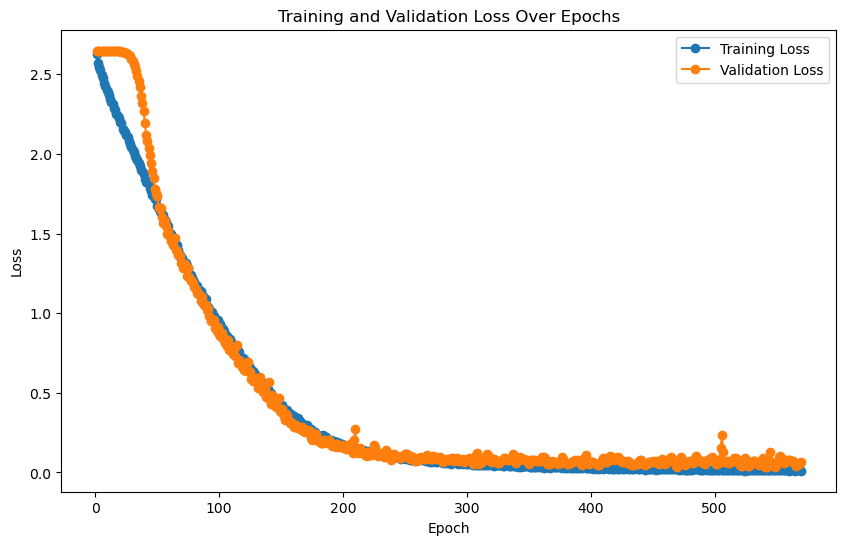

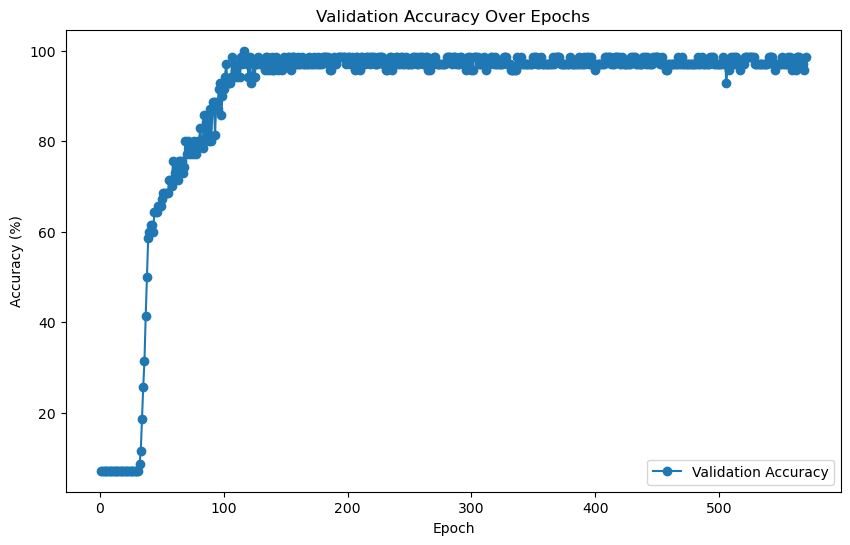


Evaluating on the test set...
    Test Batch [1/11], Loss: 0.0076

Final Test Loss: 0.0348, Test Accuracy: 98.82%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)

LOG: Training features shape: (560, 64), Training labels shape: (560,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2618, 64), Test labels shape: (2618,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.56      1.00      0.71         5
           2       0.71      1.00      0.83         5
           3       0.75      0.60      0.67         5
           4       1.00      0.40      0.57         5
           5       1.00      0.40      0.57         5
           6       0.83      1.00      0.91         5
           7       1.00      0.80      0.89         5
           8       0.75      0.60      0.67         5
           9       0.71      1.00      0.83         5
          10       0.71      1.00      0.83         5
          11       1.00      1.00      1.00         5
          12       0.67      0.40      0.50         5
          13       1.00      1.00      1.00         5

    accuracy                          

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)
Train reps shape: (560, 64)
Train labels shape: (560,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2618, 64)
Test labels shape: (2618,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6618  |  Val Loss: 2.6063
Validation loss improved from inf to 2.6063.
[Epoch 2/1000] Train Loss: 2.6059  |  Val Loss: 2.5735
Validation loss improved from 2.6063 to 2.5735.
[Epoch 3/1000] Train Loss: 2.5726  |  Val Loss: 2.5406
Validation loss improved from 2.5735 to 2.5406.
[Epoch 4/1000] Train Loss: 2.5382  |  Val Loss: 2.5023
Validation loss improved from 2.5406 to 2.5023.
[Epoch 5/1000] Train Loss: 2.4976  |  Val Loss: 2.4649
Validation loss improved from 2.5023 to 2.4649.
[Epoch 6/1000] Train Loss: 2.4551  |  Val Loss: 2.4195
Validation loss improved from 2.4649 to 2.4195.
[Epoch 7/1000] Train Loss: 2.4062  |  Val Loss: 2.3617
Validation loss improved from 2.4195 to 2.3617.
[Epoch 8/1000] Train Loss: 2.3503  |  Val Loss: 2.3012
Validation loss improved from 2.3617 to 2.3012.


[Epoch 9/1000] Train Loss: 2.2917  |  Val Loss: 2.2503
Validation loss improved from 2.3012 to 2.2503.
[Epoch 10/1000] Train Loss: 2.2351  |  Val Loss: 2.1735
Validation loss improved from 2.2503 to 2.1735.
[Epoch 11/1000] Train Loss: 2.1680  |  Val Loss: 2.1113
Validation loss improved from 2.1735 to 2.1113.


[Epoch 12/1000] Train Loss: 2.1022  |  Val Loss: 2.0348
Validation loss improved from 2.1113 to 2.0348.
[Epoch 13/1000] Train Loss: 2.0294  |  Val Loss: 1.9551
Validation loss improved from 2.0348 to 1.9551.
[Epoch 14/1000] Train Loss: 1.9526  |  Val Loss: 1.8851
Validation loss improved from 1.9551 to 1.8851.
[Epoch 15/1000] Train Loss: 1.8800  |  Val Loss: 1.8136
Validation loss improved from 1.8851 to 1.8136.
[Epoch 16/1000] Train Loss: 1.8081  |  Val Loss: 1.7332
Validation loss improved from 1.8136 to 1.7332.
[Epoch 17/1000] Train Loss: 1.7358  |  Val Loss: 1.6717
Validation loss improved from 1.7332 to 1.6717.
[Epoch 18/1000] Train Loss: 1.6680  |  Val Loss: 1.6116
Validation loss improved from 1.6717 to 1.6116.
[Epoch 19/1000] Train Loss: 1.6150  |  Val Loss: 1.5794
Validation loss improved from 1.6116 to 1.5794.
[Epoch 20/1000] Train Loss: 1.5805  |  Val Loss: 1.5174
Validation loss improved from 1.5794 to 1.5174.


[Epoch 21/1000] Train Loss: 1.5174  |  Val Loss: 1.4846
Validation loss improved from 1.5174 to 1.4846.
[Epoch 22/1000] Train Loss: 1.4836  |  Val Loss: 1.4423
Validation loss improved from 1.4846 to 1.4423.


[Epoch 23/1000] Train Loss: 1.4669  |  Val Loss: 1.4733
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 1.4312  |  Val Loss: 1.3841
Validation loss improved from 1.4423 to 1.3841.
[Epoch 25/1000] Train Loss: 1.4012  |  Val Loss: 1.3689
Validation loss improved from 1.3841 to 1.3689.
[Epoch 26/1000] Train Loss: 1.3763  |  Val Loss: 1.3470
Validation loss improved from 1.3689 to 1.3470.
[Epoch 27/1000] Train Loss: 1.3455  |  Val Loss: 1.3443
Validation loss improved from 1.3470 to 1.3443.
[Epoch 28/1000] Train Loss: 1.3374  |  Val Loss: 1.3321
Validation loss improved from 1.3443 to 1.3321.
[Epoch 29/1000] Train Loss: 1.3206  |  Val Loss: 1.3244
Validation loss improved from 1.3321 to 1.3244.
[Epoch 30/1000] Train Loss: 1.3025  |  Val Loss: 1.2850
Validation loss improved from 1.3244 to 1.2850.
[Epoch 31/1000] Train Loss: 1.3001  |  Val Loss: 1.2741
Validation loss improved from 1.2850 to 1.2741.


[Epoch 32/1000] Train Loss: 1.2826  |  Val Loss: 1.2899
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 1.2822  |  Val Loss: 1.2704
Validation loss improved from 1.2741 to 1.2704.
[Epoch 34/1000] Train Loss: 1.2543  |  Val Loss: 1.2525
Validation loss improved from 1.2704 to 1.2525.
[Epoch 35/1000] Train Loss: 1.2450  |  Val Loss: 1.2406
Validation loss improved from 1.2525 to 1.2406.
[Epoch 36/1000] Train Loss: 1.2592  |  Val Loss: 1.2582
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 1.2229  |  Val Loss: 1.2383
Validation loss improved from 1.2406 to 1.2383.
[Epoch 38/1000] Train Loss: 1.2328  |  Val Loss: 1.2228
Validation loss improved from 1.2383 to 1.2228.
[Epoch 39/1000] Train Loss: 1.2133  |  Val Loss: 1.2330
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 1.2329  |  Val Loss: 1.3037
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 41/1000] Train Loss: 1.2548  |  V

[Epoch 43/1000] Train Loss: 1.2136  |  Val Loss: 1.2045
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 1.2027  |  Val Loss: 1.1982
Validation loss improved from 1.2029 to 1.1982.
[Epoch 45/1000] Train Loss: 1.1924  |  Val Loss: 1.2139
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 46/1000] Train Loss: 1.1913  |  Val Loss: 1.2054
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 47/1000] Train Loss: 1.2041  |  Val Loss: 1.1977
Validation loss improved from 1.1982 to 1.1977.
[Epoch 48/1000] Train Loss: 1.1954  |  Val Loss: 1.1785
Validation loss improved from 1.1977 to 1.1785.
[Epoch 49/1000] Train Loss: 1.1739  |  Val Loss: 1.2215
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 1.1794  |  Val Loss: 1.2472
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 1.1713  |  Val Loss: 1.1635
Validation loss improved from 1.1785 to 1.1635.
[Epoch 52/1000] Train Loss: 1.1679

[Epoch 54/1000] Train Loss: 1.1653  |  Val Loss: 1.1910
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 55/1000] Train Loss: 1.1913  |  Val Loss: 1.2129
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 56/1000] Train Loss: 1.1788  |  Val Loss: 1.2385
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 57/1000] Train Loss: 1.1540  |  Val Loss: 1.1842
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 58/1000] Train Loss: 1.1488  |  Val Loss: 1.1583
Validation loss improved from 1.1635 to 1.1583.
[Epoch 59/1000] Train Loss: 1.1460  |  Val Loss: 1.1443
Validation loss improved from 1.1583 to 1.1443.
[Epoch 60/1000] Train Loss: 1.1428  |  Val Loss: 1.1392
Validation loss improved from 1.1443 to 1.1392.
[Epoch 61/1000] Train Loss: 1.1465  |  Val Loss: 1.1352
Validation loss improved from 1.1392 to 1.1352.
[Epoch 62/1000] Train Loss: 1.1376  |  Val Loss: 1.1661
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 1.1387

[Epoch 66/1000] Train Loss: 1.1371  |  Val Loss: 1.1283
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 1.1510  |  Val Loss: 1.1682
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 68/1000] Train Loss: 1.1384  |  Val Loss: 1.1400
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 69/1000] Train Loss: 1.1285  |  Val Loss: 1.1341
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 70/1000] Train Loss: 1.1391  |  Val Loss: 1.1465
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 71/1000] Train Loss: 1.1267  |  Val Loss: 1.1537
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 72/1000] Train Loss: 1.1391  |  Val Loss: 1.1297
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 73/1000] Train Loss: 1.1158  |  Val Loss: 1.1192
Validation loss improved from 1.1245 to 1.1192.
[Epoch 74/1000] Train Loss: 1.1107  |  Val Loss: 1.1728
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 75/1000] 

[Epoch 78/1000] Train Loss: 1.1117  |  Val Loss: 1.1081
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 1.1127  |  Val Loss: 1.1602
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 1.1214  |  Val Loss: 1.1480
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 81/1000] Train Loss: 1.1259  |  Val Loss: 1.1363
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 82/1000] Train Loss: 1.1123  |  Val Loss: 1.2298
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 83/1000] Train Loss: 1.1344  |  Val Loss: 1.1059
Validation loss improved from 1.1060 to 1.1059.
[Epoch 84/1000] Train Loss: 1.1149  |  Val Loss: 1.0902
Validation loss improved from 1.1059 to 1.0902.
[Epoch 85/1000] Train Loss: 1.1061  |  Val Loss: 1.0922
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 1.1242  |  Val Loss: 1.0803
Validation loss improved from 1.0902 to 1.0803.
[Epoch 87/1000] Train Loss: 

[Epoch 90/1000] Train Loss: 1.1025  |  Val Loss: 1.0876
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 91/1000] Train Loss: 1.0926  |  Val Loss: 1.0824
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 92/1000] Train Loss: 1.1129  |  Val Loss: 1.0881
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 93/1000] Train Loss: 1.1077  |  Val Loss: 1.0840
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 94/1000] Train Loss: 1.0923  |  Val Loss: 1.0991
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 95/1000] Train Loss: 1.0940  |  Val Loss: 1.0911
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 96/1000] Train Loss: 1.0920  |  Val Loss: 1.1590
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 97/1000] Train Loss: 1.1216  |  Val Loss: 1.1325
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 98/1000] Train Loss: 1.0938  |  Val Loss: 1.0673
Validation loss improved from 1.0803 to 1.0673.
[Epoch 99/1000

[Epoch 101/1000] Train Loss: 1.1079  |  Val Loss: 1.0711
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 102/1000] Train Loss: 1.0915  |  Val Loss: 1.0734
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 103/1000] Train Loss: 1.1038  |  Val Loss: 1.1372
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 104/1000] Train Loss: 1.1145  |  Val Loss: 1.0644
Validation loss improved from 1.0673 to 1.0644.
[Epoch 105/1000] Train Loss: 1.1091  |  Val Loss: 1.0783
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 1.0949  |  Val Loss: 1.0694
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 107/1000] Train Loss: 1.0779  |  Val Loss: 1.0710
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 108/1000] Train Loss: 1.0853  |  Val Loss: 1.0788
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 109/1000] Train Loss: 1.0615  |  Val Loss: 1.0929
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 112/1000] Train Loss: 1.0863  |  Val Loss: 1.0686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 1.0792  |  Val Loss: 1.0501
Validation loss improved from 1.0629 to 1.0501.
[Epoch 114/1000] Train Loss: 1.0689  |  Val Loss: 1.0474
Validation loss improved from 1.0501 to 1.0474.
[Epoch 115/1000] Train Loss: 1.0695  |  Val Loss: 1.0623
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.0704  |  Val Loss: 1.0510
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 1.0735  |  Val Loss: 1.0608
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 118/1000] Train Loss: 1.0663  |  Val Loss: 1.0458
Validation loss improved from 1.0474 to 1.0458.
[Epoch 119/1000] Train Loss: 1.0640  |  Val Loss: 1.0654
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 120/1000] Train Loss: 1.0620  |  Val Loss: 1.0751
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 121/1000] Tr

[Epoch 123/1000] Train Loss: 1.0869  |  Val Loss: 1.0448
Validation loss improved from 1.0458 to 1.0448.
[Epoch 124/1000] Train Loss: 1.0772  |  Val Loss: 1.0573
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 1.0821  |  Val Loss: 1.0464
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 126/1000] Train Loss: 1.0648  |  Val Loss: 1.0520
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 127/1000] Train Loss: 1.0484  |  Val Loss: 1.0392
Validation loss improved from 1.0448 to 1.0392.
[Epoch 128/1000] Train Loss: 1.0542  |  Val Loss: 1.0425
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 129/1000] Train Loss: 1.0814  |  Val Loss: 1.1808
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 130/1000] Train Loss: 1.1110  |  Val Loss: 1.1449
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 131/1000] Train Loss: 1.0975  |  Val Loss: 1.0572
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 132/10

[Epoch 134/1000] Train Loss: 1.0701  |  Val Loss: 1.0820
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/1000] Train Loss: 1.1001  |  Val Loss: 1.0558
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 136/1000] Train Loss: 1.0821  |  Val Loss: 1.0386
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 137/1000] Train Loss: 1.0585  |  Val Loss: 1.0545
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 138/1000] Train Loss: 1.0435  |  Val Loss: 1.0373
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 139/1000] Train Loss: 1.0516  |  Val Loss: 1.0417
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 140/1000] Train Loss: 1.0548  |  Val Loss: 1.0390
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 141/1000] Train Loss: 1.0476  |  Val Loss: 1.0235
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 142/1000] Train Loss: 1.0418  |  Val Loss: 1.1354
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 146/1000] Train Loss: 1.0425  |  Val Loss: 1.0244
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 147/1000] Train Loss: 1.0492  |  Val Loss: 1.0612
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 148/1000] Train Loss: 1.0456  |  Val Loss: 1.0420
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 149/1000] Train Loss: 1.0574  |  Val Loss: 1.1106
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 150/1000] Train Loss: 1.0895  |  Val Loss: 1.0163
Validation loss improved from 1.0233 to 1.0163.
[Epoch 151/1000] Train Loss: 1.0603  |  Val Loss: 1.0798
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 1.0618  |  Val Loss: 1.0933
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 1.0457  |  Val Loss: 1.0347
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 154/1000] Train Loss: 1.0432  |  Val Loss: 1.0540
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 157/1000] Train Loss: 1.0611  |  Val Loss: 1.0470
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 158/1000] Train Loss: 1.0512  |  Val Loss: 1.0412
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 159/1000] Train Loss: 1.0414  |  Val Loss: 1.0384
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 160/1000] Train Loss: 1.0369  |  Val Loss: 1.0342
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 161/1000] Train Loss: 1.0413  |  Val Loss: 1.1137
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 162/1000] Train Loss: 1.0440  |  Val Loss: 1.0689
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 163/1000] Train Loss: 1.0452  |  Val Loss: 1.0258
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 164/1000] Train Loss: 1.0331  |  Val Loss: 1.0418
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 165/1000] Train Loss: 1.0307  |  Val Loss: 1.0124
Validation loss improved from 1.0163 to 1.0124.
[E

[Epoch 167/1000] Train Loss: 1.0553  |  Val Loss: 1.0491
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 168/1000] Train Loss: 1.0422  |  Val Loss: 1.0996
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 169/1000] Train Loss: 1.0303  |  Val Loss: 1.0153
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 170/1000] Train Loss: 1.0218  |  Val Loss: 1.0586
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 171/1000] Train Loss: 1.0531  |  Val Loss: 1.0916
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 172/1000] Train Loss: 1.0510  |  Val Loss: 0.9976
Validation loss improved from 1.0083 to 0.9976.
[Epoch 173/1000] Train Loss: 1.0261  |  Val Loss: 1.0114
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 174/1000] Train Loss: 1.0210  |  Val Loss: 1.0229
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 175/1000] Train Loss: 1.0199  |  Val Loss: 1.0180
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 178/1000] Train Loss: 1.0827  |  Val Loss: 1.0441
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 179/1000] Train Loss: 1.0640  |  Val Loss: 1.0154
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 180/1000] Train Loss: 1.0282  |  Val Loss: 1.0157
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 181/1000] Train Loss: 1.0211  |  Val Loss: 1.0139
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 182/1000] Train Loss: 1.0322  |  Val Loss: 1.0984
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 183/1000] Train Loss: 1.0366  |  Val Loss: 1.0752
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 184/1000] Train Loss: 1.0374  |  Val Loss: 1.0397
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 185/1000] Train Loss: 1.0558  |  Val Loss: 1.0047
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 186/1000] Train Loss: 1.0230  |  Val Loss: 1.0222
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 191/1000] Train Loss: 1.0307  |  Val Loss: 1.0255
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 192/1000] Train Loss: 1.0267  |  Val Loss: 1.0250
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 193/1000] Train Loss: 1.0227  |  Val Loss: 1.0219
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 194/1000] Train Loss: 1.0194  |  Val Loss: 1.0092
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 195/1000] Train Loss: 1.0144  |  Val Loss: 1.0368
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 196/1000] Train Loss: 1.0167  |  Val Loss: 1.0528
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 197/1000] Train Loss: 1.0246  |  Val Loss: 1.0438
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 198/1000] Train Loss: 1.0236  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 199/1000] Train Loss: 1.0054  |  Val Loss: 1.0338
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 202/1000] Train Loss: 1.0220  |  Val Loss: 1.0358
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 203/1000] Train Loss: 1.0217  |  Val Loss: 1.0118
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 204/1000] Train Loss: 1.0126  |  Val Loss: 1.0032
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 205/1000] Train Loss: 1.0166  |  Val Loss: 1.0270
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 206/1000] Train Loss: 1.0278  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 207/1000] Train Loss: 1.0301  |  Val Loss: 1.0327
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 208/1000] Train Loss: 1.0364  |  Val Loss: 1.1008
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 209/1000] Train Loss: 1.0442  |  Val Loss: 1.0951
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 210/1000] Train Loss: 1.1193  |  Val Loss: 1.0213
!! Validation loss did NOT improve !! Patience:

[Epoch 213/1000] Train Loss: 1.0171  |  Val Loss: 1.0383
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 214/1000] Train Loss: 1.0391  |  Val Loss: 1.0313
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 215/1000] Train Loss: 1.0129  |  Val Loss: 1.0166
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 216/1000] Train Loss: 1.0145  |  Val Loss: 0.9948
Validation loss improved from 0.9972 to 0.9948.
[Epoch 217/1000] Train Loss: 1.0134  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 218/1000] Train Loss: 1.0410  |  Val Loss: 1.1172
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 219/1000] Train Loss: 1.0721  |  Val Loss: 0.9852
Validation loss improved from 0.9948 to 0.9852.
[Epoch 220/1000] Train Loss: 1.0354  |  Val Loss: 1.0002
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/1000] Train Loss: 1.0677  |  Val Loss: 0.9966
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 222

[Epoch 224/1000] Train Loss: 1.0050  |  Val Loss: 1.0305
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 225/1000] Train Loss: 1.0196  |  Val Loss: 0.9962
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 226/1000] Train Loss: 1.0478  |  Val Loss: 1.0304
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 227/1000] Train Loss: 1.0273  |  Val Loss: 1.0667
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 228/1000] Train Loss: 1.0435  |  Val Loss: 0.9905
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 229/1000] Train Loss: 1.0022  |  Val Loss: 0.9934
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 230/1000] Train Loss: 1.0088  |  Val Loss: 0.9883
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 231/1000] Train Loss: 1.0045  |  Val Loss: 1.0402
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 232/1000] Train Loss: 1.0438  |  Val Loss: 0.9902
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 235/1000] Train Loss: 1.0195  |  Val Loss: 0.9916
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 236/1000] Train Loss: 1.0131  |  Val Loss: 1.0143
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 237/1000] Train Loss: 1.0135  |  Val Loss: 1.0172
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 238/1000] Train Loss: 1.0068  |  Val Loss: 1.0164
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 239/1000] Train Loss: 0.9988  |  Val Loss: 1.1146
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 240/1000] Train Loss: 1.0110  |  Val Loss: 1.0878
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 241/1000] Train Loss: 1.0340  |  Val Loss: 1.0538
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 242/1000] Train Loss: 1.0017  |  Val Loss: 0.9942
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 243/1000] Train Loss: 0.9993  |  Val Loss: 0.9903
!! Validation loss did NOT improve !! Patience:

[Epoch 246/1000] Train Loss: 1.0222  |  Val Loss: 0.9980
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 247/1000] Train Loss: 0.9941  |  Val Loss: 0.9977
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 248/1000] Train Loss: 0.9999  |  Val Loss: 0.9882
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 249/1000] Train Loss: 1.0066  |  Val Loss: 1.0593
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 250/1000] Train Loss: 0.9982  |  Val Loss: 0.9914
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 251/1000] Train Loss: 0.9964  |  Val Loss: 1.0114
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 252/1000] Train Loss: 0.9847  |  Val Loss: 1.0168
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 253/1000] Train Loss: 0.9859  |  Val Loss: 1.0136
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 254/1000] Train Loss: 0.9899  |  Val Loss: 1.0433
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 1.0309  |  Val Loss: 0.9754
Validation loss improved from 0.9852 to 0.9754.
[Epoch 258/1000] Train Loss: 1.0240  |  Val Loss: 0.9937
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 259/1000] Train Loss: 1.0225  |  Val Loss: 0.9748
Validation loss improved from 0.9754 to 0.9748.
[Epoch 260/1000] Train Loss: 0.9893  |  Val Loss: 0.9914
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 261/1000] Train Loss: 0.9817  |  Val Loss: 0.9990
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 262/1000] Train Loss: 0.9982  |  Val Loss: 0.9846
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 263/1000] Train Loss: 1.0199  |  Val Loss: 0.9923
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 264/1000] Train Loss: 1.0328  |  Val Loss: 1.0490
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 265/1000] Train Loss: 1.0415  |  Val Loss: 1.1482
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 266/10

[Epoch 269/1000] Train Loss: 0.9845  |  Val Loss: 1.0297
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 270/1000] Train Loss: 0.9963  |  Val Loss: 0.9801
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 271/1000] Train Loss: 1.0179  |  Val Loss: 0.9899
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 272/1000] Train Loss: 1.0305  |  Val Loss: 0.9808
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 273/1000] Train Loss: 1.0146  |  Val Loss: 0.9842
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 274/1000] Train Loss: 0.9904  |  Val Loss: 0.9685
Validation loss improved from 0.9748 to 0.9685.
[Epoch 275/1000] Train Loss: 0.9737  |  Val Loss: 1.0232
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 276/1000] Train Loss: 0.9742  |  Val Loss: 0.9820
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 277/1000] Train Loss: 0.9688  |  Val Loss: 1.0007
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 281/1000] Train Loss: 0.9753  |  Val Loss: 0.9833
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 282/1000] Train Loss: 0.9772  |  Val Loss: 0.9919
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 283/1000] Train Loss: 0.9865  |  Val Loss: 1.0262
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 284/1000] Train Loss: 1.0093  |  Val Loss: 1.0315
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 285/1000] Train Loss: 1.0162  |  Val Loss: 1.0173
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 286/1000] Train Loss: 0.9991  |  Val Loss: 1.0005
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 287/1000] Train Loss: 0.9907  |  Val Loss: 0.9639
Validation loss improved from 0.9685 to 0.9639.
[Epoch 288/1000] Train Loss: 1.0013  |  Val Loss: 0.9661
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 289/1000] Train Loss: 0.9941  |  Val Loss: 0.9913
!! Validation loss did NOT improve !! Patience: 2/100
[Epo

[Epoch 292/1000] Train Loss: 0.9984  |  Val Loss: 1.0170
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 293/1000] Train Loss: 0.9702  |  Val Loss: 1.0221
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 294/1000] Train Loss: 0.9874  |  Val Loss: 0.9707
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 295/1000] Train Loss: 0.9791  |  Val Loss: 1.0378
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 296/1000] Train Loss: 0.9894  |  Val Loss: 0.9949
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 297/1000] Train Loss: 0.9640  |  Val Loss: 0.9965
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 298/1000] Train Loss: 0.9935  |  Val Loss: 0.9556
Validation loss improved from 0.9639 to 0.9556.
[Epoch 299/1000] Train Loss: 0.9707  |  Val Loss: 1.0158
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 300/1000] Train Loss: 0.9721  |  Val Loss: 0.9643
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch

[Epoch 303/1000] Train Loss: 0.9777  |  Val Loss: 0.9807
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 304/1000] Train Loss: 0.9769  |  Val Loss: 1.0014
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 305/1000] Train Loss: 0.9854  |  Val Loss: 0.9962
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 306/1000] Train Loss: 0.9673  |  Val Loss: 1.0205
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 307/1000] Train Loss: 0.9832  |  Val Loss: 1.0333
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 308/1000] Train Loss: 0.9673  |  Val Loss: 0.9898
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 309/1000] Train Loss: 0.9570  |  Val Loss: 0.9817
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 310/1000] Train Loss: 0.9455  |  Val Loss: 1.0356
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 311/1000] Train Loss: 0.9645  |  Val Loss: 0.9601
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 314/1000] Train Loss: 0.9452  |  Val Loss: 0.9794
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 0.9447  |  Val Loss: 0.9869
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 316/1000] Train Loss: 0.9402  |  Val Loss: 0.9912
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 317/1000] Train Loss: 0.9575  |  Val Loss: 0.9697
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 318/1000] Train Loss: 0.9465  |  Val Loss: 0.9663
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 319/1000] Train Loss: 0.9420  |  Val Loss: 0.9502
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 320/1000] Train Loss: 0.9554  |  Val Loss: 0.9460
Validation loss improved from 0.9488 to 0.9460.
[Epoch 321/1000] Train Loss: 0.9641  |  Val Loss: 1.0683
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 0.9525  |  Val Loss: 1.0329
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 325/1000] Train Loss: 0.9565  |  Val Loss: 1.0116
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 0.9508  |  Val Loss: 0.9968
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 327/1000] Train Loss: 0.9607  |  Val Loss: 0.9788
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 328/1000] Train Loss: 0.9450  |  Val Loss: 0.9432
Validation loss improved from 0.9460 to 0.9432.
[Epoch 329/1000] Train Loss: 0.9303  |  Val Loss: 0.9980
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 330/1000] Train Loss: 0.9738  |  Val Loss: 1.0658
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 331/1000] Train Loss: 1.0224  |  Val Loss: 1.0098
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 332/1000] Train Loss: 0.9925  |  Val Loss: 0.9516
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 333/1000] Train Loss: 0.9777  |  Val Loss: 0.9829
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 337/1000] Train Loss: 0.9186  |  Val Loss: 0.9624
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 338/1000] Train Loss: 0.9164  |  Val Loss: 0.9454
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 339/1000] Train Loss: 0.9209  |  Val Loss: 0.9517
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 340/1000] Train Loss: 0.9234  |  Val Loss: 0.9609
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 341/1000] Train Loss: 0.9166  |  Val Loss: 1.0157
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 342/1000] Train Loss: 0.9514  |  Val Loss: 1.0457
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 343/1000] Train Loss: 0.9492  |  Val Loss: 0.9927
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 344/1000] Train Loss: 0.9292  |  Val Loss: 0.9526
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 345/1000] Train Loss: 0.9250  |  Val Loss: 0.9703
!! Validation loss did NOT improve !! Patience: 

[Epoch 348/1000] Train Loss: 0.9118  |  Val Loss: 0.9878
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 349/1000] Train Loss: 0.9196  |  Val Loss: 0.9600
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 350/1000] Train Loss: 0.9375  |  Val Loss: 1.0266
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 351/1000] Train Loss: 0.9854  |  Val Loss: 0.9631
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 352/1000] Train Loss: 0.9280  |  Val Loss: 0.9651
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 353/1000] Train Loss: 0.8996  |  Val Loss: 0.9408
Validation loss improved from 0.9432 to 0.9408.
[Epoch 354/1000] Train Loss: 0.9040  |  Val Loss: 0.9908
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 355/1000] Train Loss: 0.9165  |  Val Loss: 1.0411
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 356/1000] Train Loss: 0.9236  |  Val Loss: 0.9435
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 361/1000] Train Loss: 0.8903  |  Val Loss: 0.9504
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 362/1000] Train Loss: 0.8874  |  Val Loss: 1.0798
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 363/1000] Train Loss: 0.9152  |  Val Loss: 0.9865
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 364/1000] Train Loss: 0.8948  |  Val Loss: 0.9326
Validation loss improved from 0.9400 to 0.9326.
[Epoch 365/1000] Train Loss: 0.8995  |  Val Loss: 0.9155
Validation loss improved from 0.9326 to 0.9155.
[Epoch 366/1000] Train Loss: 0.9061  |  Val Loss: 0.9444
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 367/1000] Train Loss: 0.8915  |  Val Loss: 0.9320
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 368/1000] Train Loss: 0.8801  |  Val Loss: 0.9149
Validation loss improved from 0.9155 to 0.9149.
[Epoch 369/1000] Train Loss: 0.8819  |  Val Loss: 0.9122
Validation loss improved from 0.9149 to 0.9122.
[Epoch 370/1000] Train Lo

[Epoch 372/1000] Train Loss: 0.8733  |  Val Loss: 0.9795
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 373/1000] Train Loss: 0.8829  |  Val Loss: 1.0185
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 374/1000] Train Loss: 0.8826  |  Val Loss: 0.8934
Validation loss improved from 0.9122 to 0.8934.
[Epoch 375/1000] Train Loss: 0.8769  |  Val Loss: 0.9611
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 376/1000] Train Loss: 0.8890  |  Val Loss: 0.9408
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 377/1000] Train Loss: 0.8925  |  Val Loss: 0.9137
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 378/1000] Train Loss: 0.8961  |  Val Loss: 0.9095
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 379/1000] Train Loss: 0.8911  |  Val Loss: 0.9608
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 380/1000] Train Loss: 0.9199  |  Val Loss: 0.8994
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 382/1000] Train Loss: 0.8561  |  Val Loss: 0.9534
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 383/1000] Train Loss: 0.8613  |  Val Loss: 0.9694
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 384/1000] Train Loss: 0.8341  |  Val Loss: 0.9204
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 385/1000] Train Loss: 0.8635  |  Val Loss: 0.9030
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 386/1000] Train Loss: 0.8414  |  Val Loss: 0.8914
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 387/1000] Train Loss: 0.8410  |  Val Loss: 0.8893
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 388/1000] Train Loss: 0.8527  |  Val Loss: 0.9758
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 389/1000] Train Loss: 0.8585  |  Val Loss: 0.8708
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 390/1000] Train Loss: 0.8869  |  Val Loss: 0.9372
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 394/1000] Train Loss: 0.8521  |  Val Loss: 0.9217
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 395/1000] Train Loss: 0.8662  |  Val Loss: 0.8577
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 396/1000] Train Loss: 0.8370  |  Val Loss: 0.8490
Validation loss improved from 0.8528 to 0.8490.
[Epoch 397/1000] Train Loss: 0.8400  |  Val Loss: 0.8515
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 398/1000] Train Loss: 0.8414  |  Val Loss: 0.8522
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 399/1000] Train Loss: 0.8204  |  Val Loss: 0.8619
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 400/1000] Train Loss: 0.8555  |  Val Loss: 0.8945
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 401/1000] Train Loss: 0.8508  |  Val Loss: 0.8511
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 402/1000] Train Loss: 0.8136  |  Val Loss: 0.8559
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 405/1000] Train Loss: 0.8124  |  Val Loss: 0.8554
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 406/1000] Train Loss: 0.8318  |  Val Loss: 0.8905
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 407/1000] Train Loss: 0.8734  |  Val Loss: 0.8867
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 408/1000] Train Loss: 0.8091  |  Val Loss: 0.9107
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 409/1000] Train Loss: 0.8165  |  Val Loss: 0.9523
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 410/1000] Train Loss: 0.8400  |  Val Loss: 0.9560
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 411/1000] Train Loss: 0.8050  |  Val Loss: 0.8230
Validation loss improved from 0.8490 to 0.8230.
[Epoch 412/1000] Train Loss: 0.7933  |  Val Loss: 0.8548
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 413/1000] Train Loss: 0.7852  |  Val Loss: 0.8352
!! Validation loss did NOT improve !! Patience: 2/100
[E

[Epoch 417/1000] Train Loss: 0.8060  |  Val Loss: 0.8334
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 418/1000] Train Loss: 0.8105  |  Val Loss: 0.8171
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 419/1000] Train Loss: 0.7955  |  Val Loss: 0.8212
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 420/1000] Train Loss: 0.7968  |  Val Loss: 0.8185
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 421/1000] Train Loss: 0.8036  |  Val Loss: 0.8403
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 422/1000] Train Loss: 0.7668  |  Val Loss: 0.8679
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 423/1000] Train Loss: 0.7953  |  Val Loss: 0.8828
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 424/1000] Train Loss: 0.7739  |  Val Loss: 0.8799
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 425/1000] Train Loss: 0.7684  |  Val Loss: 0.8481
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 428/1000] Train Loss: 0.8446  |  Val Loss: 1.0185
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 429/1000] Train Loss: 0.8351  |  Val Loss: 0.8723
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 430/1000] Train Loss: 0.7728  |  Val Loss: 0.8275
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 431/1000] Train Loss: 0.8244  |  Val Loss: 0.8842
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 432/1000] Train Loss: 0.8151  |  Val Loss: 0.9288
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 433/1000] Train Loss: 0.7902  |  Val Loss: 0.8433
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 434/1000] Train Loss: 0.7800  |  Val Loss: 0.9989
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 435/1000] Train Loss: 0.7723  |  Val Loss: 0.8247
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 436/1000] Train Loss: 0.7566  |  Val Loss: 0.8277
!! Validation loss did NOT improve !! Patience:

[Epoch 438/1000] Train Loss: 0.7673  |  Val Loss: 0.9092
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 439/1000] Train Loss: 0.7809  |  Val Loss: 0.8634
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 440/1000] Train Loss: 0.8156  |  Val Loss: 0.8736
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 441/1000] Train Loss: 0.7672  |  Val Loss: 0.8501
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 442/1000] Train Loss: 0.7382  |  Val Loss: 0.8106
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 443/1000] Train Loss: 0.7477  |  Val Loss: 0.8147
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 444/1000] Train Loss: 0.7246  |  Val Loss: 0.8492
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 445/1000] Train Loss: 0.7785  |  Val Loss: 0.8333
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 446/1000] Train Loss: 0.7472  |  Val Loss: 0.7593
Validation loss improved from 0.8102 to 0.7593.

[Epoch 449/1000] Train Loss: 0.7409  |  Val Loss: 0.8529
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 450/1000] Train Loss: 0.7587  |  Val Loss: 0.8017
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 451/1000] Train Loss: 0.7411  |  Val Loss: 0.7829
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 452/1000] Train Loss: 0.7156  |  Val Loss: 0.8208
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 453/1000] Train Loss: 0.7288  |  Val Loss: 0.8010
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 454/1000] Train Loss: 0.7548  |  Val Loss: 0.7839
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 455/1000] Train Loss: 0.7448  |  Val Loss: 0.7992
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 456/1000] Train Loss: 0.7509  |  Val Loss: 0.8697
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 457/1000] Train Loss: 0.7371  |  Val Loss: 0.7505
Validation loss improved from 0.7593 to 0.7505.
[Epoch

[Epoch 460/1000] Train Loss: 0.7344  |  Val Loss: 0.7867
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 461/1000] Train Loss: 0.7090  |  Val Loss: 0.7545
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 462/1000] Train Loss: 0.7322  |  Val Loss: 0.8061
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 463/1000] Train Loss: 0.7389  |  Val Loss: 0.9089
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 464/1000] Train Loss: 0.7361  |  Val Loss: 0.7861
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 465/1000] Train Loss: 0.7162  |  Val Loss: 0.7344
Validation loss improved from 0.7505 to 0.7344.
[Epoch 466/1000] Train Loss: 0.7455  |  Val Loss: 0.8283
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 467/1000] Train Loss: 0.7736  |  Val Loss: 0.8218
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 468/1000] Train Loss: 0.7161  |  Val Loss: 0.8925
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 471/1000] Train Loss: 0.6913  |  Val Loss: 0.8135
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 472/1000] Train Loss: 0.6887  |  Val Loss: 0.8248
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 473/1000] Train Loss: 0.7484  |  Val Loss: 0.8354
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 474/1000] Train Loss: 0.7251  |  Val Loss: 0.7477
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 475/1000] Train Loss: 0.7029  |  Val Loss: 0.7332
Validation loss improved from 0.7344 to 0.7332.
[Epoch 476/1000] Train Loss: 0.6779  |  Val Loss: 0.7644
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 477/1000] Train Loss: 0.7202  |  Val Loss: 0.7381
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 478/1000] Train Loss: 0.7356  |  Val Loss: 0.7393
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 479/1000] Train Loss: 0.7021  |  Val Loss: 0.7432
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 482/1000] Train Loss: 0.6733  |  Val Loss: 0.7514
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 483/1000] Train Loss: 0.6765  |  Val Loss: 0.8463
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 484/1000] Train Loss: 0.7134  |  Val Loss: 0.7821
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 485/1000] Train Loss: 0.6664  |  Val Loss: 0.7621
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 486/1000] Train Loss: 0.6811  |  Val Loss: 0.7472
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 487/1000] Train Loss: 0.6934  |  Val Loss: 0.7590
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 488/1000] Train Loss: 0.6817  |  Val Loss: 0.7128
Validation loss improved from 0.7332 to 0.7128.
[Epoch 489/1000] Train Loss: 0.6922  |  Val Loss: 0.7036
Validation loss improved from 0.7128 to 0.7036.
[Epoch 490/1000] Train Loss: 0.6620  |  Val Loss: 0.7047
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 491

[Epoch 494/1000] Train Loss: 0.6701  |  Val Loss: 0.7970
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 495/1000] Train Loss: 0.6726  |  Val Loss: 0.7983
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 496/1000] Train Loss: 0.7051  |  Val Loss: 0.7839
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 497/1000] Train Loss: 0.7064  |  Val Loss: 0.7279
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 498/1000] Train Loss: 0.7226  |  Val Loss: 0.7268
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 499/1000] Train Loss: 0.6919  |  Val Loss: 0.7622
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 500/1000] Train Loss: 0.6780  |  Val Loss: 0.7624
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 501/1000] Train Loss: 0.6990  |  Val Loss: 0.7085
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 502/1000] Train Loss: 0.6403  |  Val Loss: 0.7164
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 506/1000] Train Loss: 0.6470  |  Val Loss: 0.7032
Validation loss improved from 0.7036 to 0.7032.
[Epoch 507/1000] Train Loss: 0.6307  |  Val Loss: 0.7078
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 508/1000] Train Loss: 0.6765  |  Val Loss: 0.6863
Validation loss improved from 0.7032 to 0.6863.
[Epoch 509/1000] Train Loss: 0.6810  |  Val Loss: 0.6905
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 510/1000] Train Loss: 0.6601  |  Val Loss: 0.7023
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 511/1000] Train Loss: 0.6790  |  Val Loss: 0.7247
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 512/1000] Train Loss: 0.6755  |  Val Loss: 0.8482
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 513/1000] Train Loss: 0.6819  |  Val Loss: 0.7185
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 514/1000] Train Loss: 0.6413  |  Val Loss: 0.7459
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 515/10

[Epoch 518/1000] Train Loss: 0.6109  |  Val Loss: 0.6732
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 519/1000] Train Loss: 0.6473  |  Val Loss: 0.7305
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 520/1000] Train Loss: 0.6129  |  Val Loss: 0.7264
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 521/1000] Train Loss: 0.6498  |  Val Loss: 0.6862
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 522/1000] Train Loss: 0.6551  |  Val Loss: 0.7295
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 523/1000] Train Loss: 0.6317  |  Val Loss: 0.7667
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 524/1000] Train Loss: 0.6466  |  Val Loss: 0.7159
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 525/1000] Train Loss: 0.6224  |  Val Loss: 0.6746
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 526/1000] Train Loss: 0.6094  |  Val Loss: 0.6786
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 529/1000] Train Loss: 0.6007  |  Val Loss: 0.6670
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 530/1000] Train Loss: 0.5924  |  Val Loss: 0.6881
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 531/1000] Train Loss: 0.6535  |  Val Loss: 0.6621
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 532/1000] Train Loss: 0.5934  |  Val Loss: 0.7880
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 533/1000] Train Loss: 0.6127  |  Val Loss: 0.6829
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 534/1000] Train Loss: 0.6072  |  Val Loss: 0.6520
Validation loss improved from 0.6542 to 0.6520.
[Epoch 535/1000] Train Loss: 0.5730  |  Val Loss: 0.6969
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 536/1000] Train Loss: 0.6407  |  Val Loss: 0.7268
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 537/1000] Train Loss: 0.6303  |  Val Loss: 0.9055
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 539/1000] Train Loss: 0.6392  |  Val Loss: 0.7477
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 540/1000] Train Loss: 0.6216  |  Val Loss: 0.7239
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 541/1000] Train Loss: 0.6271  |  Val Loss: 0.6878
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 542/1000] Train Loss: 0.6149  |  Val Loss: 0.6561
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 543/1000] Train Loss: 0.5847  |  Val Loss: 0.6514
Validation loss improved from 0.6520 to 0.6514.
[Epoch 544/1000] Train Loss: 0.5904  |  Val Loss: 0.6674
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 545/1000] Train Loss: 0.6014  |  Val Loss: 0.6976
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 546/1000] Train Loss: 0.6296  |  Val Loss: 0.7996
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 547/1000] Train Loss: 0.6983  |  Val Loss: 0.7196
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 550/1000] Train Loss: 0.6175  |  Val Loss: 0.7572
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 551/1000] Train Loss: 0.6164  |  Val Loss: 0.6982
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 552/1000] Train Loss: 0.5857  |  Val Loss: 0.7458
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 553/1000] Train Loss: 0.6039  |  Val Loss: 0.7017
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 554/1000] Train Loss: 0.6102  |  Val Loss: 0.6362
Validation loss improved from 0.6514 to 0.6362.
[Epoch 555/1000] Train Loss: 0.5959  |  Val Loss: 0.6635
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 556/1000] Train Loss: 0.5995  |  Val Loss: 0.6357
Validation loss improved from 0.6362 to 0.6357.
[Epoch 557/1000] Train Loss: 0.5908  |  Val Loss: 0.6577
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 558/1000] Train Loss: 0.5879  |  Val Loss: 0.6425
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 559/1

[Epoch 562/1000] Train Loss: 0.5859  |  Val Loss: 0.6996
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 563/1000] Train Loss: 0.5844  |  Val Loss: 0.6750
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 564/1000] Train Loss: 0.5985  |  Val Loss: 0.6388
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 565/1000] Train Loss: 0.5823  |  Val Loss: 0.6391
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 566/1000] Train Loss: 0.5900  |  Val Loss: 0.6130
Validation loss improved from 0.6357 to 0.6130.
[Epoch 567/1000] Train Loss: 0.5869  |  Val Loss: 0.6877
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 568/1000] Train Loss: 0.5974  |  Val Loss: 0.6316
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 569/1000] Train Loss: 0.5757  |  Val Loss: 0.6163
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 570/1000] Train Loss: 0.5546  |  Val Loss: 0.6348
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 573/1000] Train Loss: 0.5684  |  Val Loss: 0.6182
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 574/1000] Train Loss: 0.5724  |  Val Loss: 0.6978
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 575/1000] Train Loss: 0.5815  |  Val Loss: 0.6292
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 576/1000] Train Loss: 0.5652  |  Val Loss: 0.6158
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 577/1000] Train Loss: 0.5477  |  Val Loss: 0.6346
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 578/1000] Train Loss: 0.5861  |  Val Loss: 0.7301
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 579/1000] Train Loss: 0.5663  |  Val Loss: 0.6003
Validation loss improved from 0.6130 to 0.6003.
[Epoch 580/1000] Train Loss: 0.5732  |  Val Loss: 0.6169
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 581/1000] Train Loss: 0.5430  |  Val Loss: 0.6973
!! Validation loss did NOT improve !! Patience: 2/100
[Epo

[Epoch 585/1000] Train Loss: 0.7050  |  Val Loss: 0.6732
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 586/1000] Train Loss: 0.5665  |  Val Loss: 0.6688
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 587/1000] Train Loss: 0.5440  |  Val Loss: 0.6353
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 588/1000] Train Loss: 0.5427  |  Val Loss: 0.6803
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 589/1000] Train Loss: 0.5458  |  Val Loss: 0.6246
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 590/1000] Train Loss: 0.5189  |  Val Loss: 0.6368
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 591/1000] Train Loss: 0.5429  |  Val Loss: 0.6451
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 592/1000] Train Loss: 0.5326  |  Val Loss: 0.6198
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 593/1000] Train Loss: 0.5256  |  Val Loss: 0.6510
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 597/1000] Train Loss: 0.5153  |  Val Loss: 0.6200
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 598/1000] Train Loss: 0.5172  |  Val Loss: 0.6384
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 599/1000] Train Loss: 0.5310  |  Val Loss: 0.6496
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 600/1000] Train Loss: 0.5397  |  Val Loss: 0.6172
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 601/1000] Train Loss: 0.5236  |  Val Loss: 0.6295
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 602/1000] Train Loss: 0.5221  |  Val Loss: 0.6090
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 603/1000] Train Loss: 0.5158  |  Val Loss: 0.6288
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 604/1000] Train Loss: 0.5251  |  Val Loss: 0.6069
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 605/1000] Train Loss: 0.5532  |  Val Loss: 0.6017
!! Validation loss did NOT improve !! Patience:

[Epoch 609/1000] Train Loss: 0.5479  |  Val Loss: 0.6542
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 610/1000] Train Loss: 0.5370  |  Val Loss: 0.6154
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 611/1000] Train Loss: 0.5640  |  Val Loss: 0.6474
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 612/1000] Train Loss: 0.5639  |  Val Loss: 0.6683
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 613/1000] Train Loss: 0.5612  |  Val Loss: 0.6545
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 614/1000] Train Loss: 0.5457  |  Val Loss: 0.6783
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 615/1000] Train Loss: 0.5248  |  Val Loss: 0.6534
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 616/1000] Train Loss: 0.5312  |  Val Loss: 0.6773
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 617/1000] Train Loss: 0.5255  |  Val Loss: 0.6203
!! Validation loss did NOT improve !! Patience:

[Epoch 622/1000] Train Loss: 0.5069  |  Val Loss: 0.7031
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 623/1000] Train Loss: 0.5157  |  Val Loss: 0.6388
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 624/1000] Train Loss: 0.5298  |  Val Loss: 0.6388
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 625/1000] Train Loss: 0.4993  |  Val Loss: 0.6265
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 626/1000] Train Loss: 0.5091  |  Val Loss: 0.5952
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 627/1000] Train Loss: 0.5452  |  Val Loss: 0.6051
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 628/1000] Train Loss: 0.5076  |  Val Loss: 0.6279
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 629/1000] Train Loss: 0.5497  |  Val Loss: 0.6217
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 630/1000] Train Loss: 0.5077  |  Val Loss: 0.6151
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 634/1000] Train Loss: 0.5663  |  Val Loss: 0.8414
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 635/1000] Train Loss: 0.5499  |  Val Loss: 0.6543
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 636/1000] Train Loss: 0.5298  |  Val Loss: 0.6083
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 637/1000] Train Loss: 0.5397  |  Val Loss: 0.7288
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 638/1000] Train Loss: 0.5663  |  Val Loss: 0.6933
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 639/1000] Train Loss: 0.4920  |  Val Loss: 0.6352
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 640/1000] Train Loss: 0.4986  |  Val Loss: 0.6040
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 641/1000] Train Loss: 0.4841  |  Val Loss: 0.6317
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 642/1000] Train Loss: 0.5292  |  Val Loss: 0.5811
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 645/1000] Train Loss: 0.5263  |  Val Loss: 0.7269
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 646/1000] Train Loss: 0.5133  |  Val Loss: 0.6484
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 647/1000] Train Loss: 0.5319  |  Val Loss: 0.8688
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 648/1000] Train Loss: 0.5492  |  Val Loss: 0.5868
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 649/1000] Train Loss: 0.4817  |  Val Loss: 0.5611
Validation loss improved from 0.5775 to 0.5611.
[Epoch 650/1000] Train Loss: 0.5149  |  Val Loss: 0.5809
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 651/1000] Train Loss: 0.4967  |  Val Loss: 0.6012
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 652/1000] Train Loss: 0.4843  |  Val Loss: 0.5741
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 653/1000] Train Loss: 0.4730  |  Val Loss: 0.6364
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 656/1000] Train Loss: 0.4643  |  Val Loss: 0.6408
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 657/1000] Train Loss: 0.4670  |  Val Loss: 0.5621
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 658/1000] Train Loss: 0.4812  |  Val Loss: 0.5662
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 659/1000] Train Loss: 0.5154  |  Val Loss: 0.6010
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 660/1000] Train Loss: 0.5008  |  Val Loss: 0.6190
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 661/1000] Train Loss: 0.4906  |  Val Loss: 0.6140
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 662/1000] Train Loss: 0.4823  |  Val Loss: 0.6939
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 663/1000] Train Loss: 0.4940  |  Val Loss: 0.5829
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 664/1000] Train Loss: 0.4550  |  Val Loss: 0.6412
!! Validation loss did NOT improve !! Patience: 15

[Epoch 668/1000] Train Loss: 0.4947  |  Val Loss: 0.7355
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 669/1000] Train Loss: 0.5037  |  Val Loss: 0.7758
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 670/1000] Train Loss: 0.5526  |  Val Loss: 0.7982
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 671/1000] Train Loss: 0.5385  |  Val Loss: 0.6017
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 672/1000] Train Loss: 0.5282  |  Val Loss: 0.6782
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 673/1000] Train Loss: 0.5773  |  Val Loss: 0.5754
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 674/1000] Train Loss: 0.4867  |  Val Loss: 0.6053
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 675/1000] Train Loss: 0.4731  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 676/1000] Train Loss: 0.4537  |  Val Loss: 0.6192
!! Validation loss did NOT improve !! Patience:

[Epoch 679/1000] Train Loss: 0.5327  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 680/1000] Train Loss: 0.5008  |  Val Loss: 0.5683
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 681/1000] Train Loss: 0.4620  |  Val Loss: 0.6302
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 682/1000] Train Loss: 0.4911  |  Val Loss: 0.6288
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 683/1000] Train Loss: 0.4501  |  Val Loss: 0.6140
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 684/1000] Train Loss: 0.4733  |  Val Loss: 0.6936
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 685/1000] Train Loss: 0.5170  |  Val Loss: 0.6443
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 686/1000] Train Loss: 0.4833  |  Val Loss: 0.6989
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 687/1000] Train Loss: 0.5476  |  Val Loss: 0.6693
!! Validation loss did NOT improve !! Patience:

[Epoch 691/1000] Train Loss: 0.4481  |  Val Loss: 0.5748
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 692/1000] Train Loss: 0.4493  |  Val Loss: 0.6870
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 693/1000] Train Loss: 0.4902  |  Val Loss: 0.6112
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 694/1000] Train Loss: 0.4709  |  Val Loss: 0.6751
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 695/1000] Train Loss: 0.4764  |  Val Loss: 0.5645
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 696/1000] Train Loss: 0.4527  |  Val Loss: 0.5420
Validation loss improved from 0.5519 to 0.5420.
[Epoch 697/1000] Train Loss: 0.4456  |  Val Loss: 0.5912
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 698/1000] Train Loss: 0.4497  |  Val Loss: 0.6933
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 699/1000] Train Loss: 0.4579  |  Val Loss: 0.6415
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 702/1000] Train Loss: 0.4656  |  Val Loss: 0.5991
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 703/1000] Train Loss: 0.4636  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 704/1000] Train Loss: 0.4525  |  Val Loss: 0.6581
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 705/1000] Train Loss: 0.4749  |  Val Loss: 0.5851
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 706/1000] Train Loss: 0.4649  |  Val Loss: 0.6462
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 707/1000] Train Loss: 0.4580  |  Val Loss: 0.6462
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 708/1000] Train Loss: 0.4366  |  Val Loss: 0.5815
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 709/1000] Train Loss: 0.4377  |  Val Loss: 0.5763
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 710/1000] Train Loss: 0.4735  |  Val Loss: 0.6005
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 713/1000] Train Loss: 0.4426  |  Val Loss: 0.5527
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 714/1000] Train Loss: 0.4300  |  Val Loss: 0.5701
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 715/1000] Train Loss: 0.4369  |  Val Loss: 0.5617
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 716/1000] Train Loss: 0.4319  |  Val Loss: 0.5789
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 717/1000] Train Loss: 0.4213  |  Val Loss: 0.6086
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 718/1000] Train Loss: 0.4205  |  Val Loss: 0.5794
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 719/1000] Train Loss: 0.4448  |  Val Loss: 0.5907
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 720/1000] Train Loss: 0.4221  |  Val Loss: 0.6554
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 721/1000] Train Loss: 0.4546  |  Val Loss: 0.6491
!! Validation loss did NOT improve !! Patience:

[Epoch 725/1000] Train Loss: 0.4502  |  Val Loss: 0.5691
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 726/1000] Train Loss: 0.4676  |  Val Loss: 0.6550
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 727/1000] Train Loss: 0.4544  |  Val Loss: 0.5308
Validation loss improved from 0.5420 to 0.5308.
[Epoch 728/1000] Train Loss: 0.4205  |  Val Loss: 0.6117
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 729/1000] Train Loss: 0.4449  |  Val Loss: 0.6420
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 730/1000] Train Loss: 0.4780  |  Val Loss: 0.7198
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 731/1000] Train Loss: 0.4779  |  Val Loss: 0.7365
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 732/1000] Train Loss: 0.4959  |  Val Loss: 0.6362
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 733/1000] Train Loss: 0.4989  |  Val Loss: 0.5546
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 736/1000] Train Loss: 0.4370  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 737/1000] Train Loss: 0.4299  |  Val Loss: 0.6024
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 738/1000] Train Loss: 0.4684  |  Val Loss: 0.6999
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 739/1000] Train Loss: 0.4997  |  Val Loss: 0.5864
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 740/1000] Train Loss: 0.4883  |  Val Loss: 0.5633
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 741/1000] Train Loss: 0.4513  |  Val Loss: 0.6290
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 742/1000] Train Loss: 0.4898  |  Val Loss: 0.6295
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 743/1000] Train Loss: 0.4464  |  Val Loss: 0.6496
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 744/1000] Train Loss: 0.4256  |  Val Loss: 0.5261
Validation loss improved from 0.5308 to 0.5261.


[Epoch 747/1000] Train Loss: 0.4409  |  Val Loss: 0.5828
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 748/1000] Train Loss: 0.4087  |  Val Loss: 0.5667
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 749/1000] Train Loss: 0.4221  |  Val Loss: 0.5795
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 750/1000] Train Loss: 0.4069  |  Val Loss: 0.6054
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 751/1000] Train Loss: 0.4059  |  Val Loss: 0.5858
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 752/1000] Train Loss: 0.4153  |  Val Loss: 0.6004
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 753/1000] Train Loss: 0.4483  |  Val Loss: 0.5645
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 754/1000] Train Loss: 0.4228  |  Val Loss: 0.5409
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 755/1000] Train Loss: 0.4228  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 759/1000] Train Loss: 0.4441  |  Val Loss: 0.6743
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 760/1000] Train Loss: 0.4373  |  Val Loss: 0.5422
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 761/1000] Train Loss: 0.4151  |  Val Loss: 0.6194
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 762/1000] Train Loss: 0.4217  |  Val Loss: 0.6129
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 763/1000] Train Loss: 0.4181  |  Val Loss: 0.5992
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 764/1000] Train Loss: 0.4115  |  Val Loss: 0.5591
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 765/1000] Train Loss: 0.4179  |  Val Loss: 0.5996
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 766/1000] Train Loss: 0.4374  |  Val Loss: 0.6111
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 767/1000] Train Loss: 0.4440  |  Val Loss: 0.6200
!! Validation loss did NOT improve !! Patience:

[Epoch 771/1000] Train Loss: 0.4185  |  Val Loss: 0.6290
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 772/1000] Train Loss: 0.4694  |  Val Loss: 0.5391
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 773/1000] Train Loss: 0.4370  |  Val Loss: 0.5627
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 774/1000] Train Loss: 0.3985  |  Val Loss: 0.6692
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 775/1000] Train Loss: 0.4435  |  Val Loss: 0.5800
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 776/1000] Train Loss: 0.3982  |  Val Loss: 0.5590
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 777/1000] Train Loss: 0.3958  |  Val Loss: 0.5449
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 778/1000] Train Loss: 0.3902  |  Val Loss: 0.5988
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 779/1000] Train Loss: 0.4477  |  Val Loss: 0.5658
!! Validation loss did NOT improve !! Patience:

[Epoch 782/1000] Train Loss: 0.4323  |  Val Loss: 0.6483
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 783/1000] Train Loss: 0.4211  |  Val Loss: 0.6142
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 784/1000] Train Loss: 0.4117  |  Val Loss: 0.5814
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 785/1000] Train Loss: 0.3994  |  Val Loss: 0.5293
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 786/1000] Train Loss: 0.3925  |  Val Loss: 0.5233
Validation loss improved from 0.5261 to 0.5233.
[Epoch 787/1000] Train Loss: 0.4592  |  Val Loss: 0.5775
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 788/1000] Train Loss: 0.4525  |  Val Loss: 0.5942
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 789/1000] Train Loss: 0.4401  |  Val Loss: 0.5838
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 790/1000] Train Loss: 0.4063  |  Val Loss: 0.5421
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 793/1000] Train Loss: 0.4209  |  Val Loss: 0.8031
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 794/1000] Train Loss: 0.4617  |  Val Loss: 0.6440
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 795/1000] Train Loss: 0.4262  |  Val Loss: 0.6381
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 796/1000] Train Loss: 0.4463  |  Val Loss: 0.6743
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 797/1000] Train Loss: 0.4426  |  Val Loss: 0.7028
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 798/1000] Train Loss: 0.4320  |  Val Loss: 0.7114
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 799/1000] Train Loss: 0.4184  |  Val Loss: 0.7317
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 800/1000] Train Loss: 0.4563  |  Val Loss: 0.6292
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 801/1000] Train Loss: 0.4322  |  Val Loss: 0.5804
!! Validation loss did NOT improve !! Patience: 15

[Epoch 804/1000] Train Loss: 0.3859  |  Val Loss: 0.6410
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 805/1000] Train Loss: 0.4092  |  Val Loss: 0.7189
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 806/1000] Train Loss: 0.4340  |  Val Loss: 0.6507
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 807/1000] Train Loss: 0.4145  |  Val Loss: 0.6086
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 808/1000] Train Loss: 0.3920  |  Val Loss: 0.5439
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 809/1000] Train Loss: 0.4009  |  Val Loss: 0.5416
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 810/1000] Train Loss: 0.4657  |  Val Loss: 0.7639
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 811/1000] Train Loss: 0.5275  |  Val Loss: 0.5950
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 812/1000] Train Loss: 0.4394  |  Val Loss: 0.7026
!! Validation loss did NOT improve !! Patience:

[Epoch 815/1000] Train Loss: 0.3984  |  Val Loss: 0.5960
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 816/1000] Train Loss: 0.3815  |  Val Loss: 0.5386
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 817/1000] Train Loss: 0.3802  |  Val Loss: 0.5493
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 818/1000] Train Loss: 0.3751  |  Val Loss: 0.5771
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 819/1000] Train Loss: 0.4100  |  Val Loss: 0.6082
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 820/1000] Train Loss: 0.4491  |  Val Loss: 0.6906
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 821/1000] Train Loss: 0.4260  |  Val Loss: 0.8194
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 822/1000] Train Loss: 0.5662  |  Val Loss: 0.5865
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 823/1000] Train Loss: 0.6421  |  Val Loss: 0.7606
!! Validation loss did NOT improve !! Patience:

[Epoch 827/1000] Train Loss: 0.3785  |  Val Loss: 0.6005
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 828/1000] Train Loss: 0.3973  |  Val Loss: 0.5585
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 829/1000] Train Loss: 0.4279  |  Val Loss: 0.5717
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 830/1000] Train Loss: 0.4135  |  Val Loss: 0.5499
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 831/1000] Train Loss: 0.4149  |  Val Loss: 0.6539
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 832/1000] Train Loss: 0.4019  |  Val Loss: 0.5633
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 833/1000] Train Loss: 0.4074  |  Val Loss: 0.5103
Validation loss improved from 0.5233 to 0.5103.
[Epoch 834/1000] Train Loss: 0.4482  |  Val Loss: 0.6252
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 835/1000] Train Loss: 0.4376  |  Val Loss: 0.5758
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 839/1000] Train Loss: 0.4032  |  Val Loss: 0.6091
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 840/1000] Train Loss: 0.3816  |  Val Loss: 0.5462
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 841/1000] Train Loss: 0.4147  |  Val Loss: 0.6457
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 842/1000] Train Loss: 0.4287  |  Val Loss: 0.6817
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 843/1000] Train Loss: 0.4237  |  Val Loss: 0.7050
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 844/1000] Train Loss: 0.4149  |  Val Loss: 0.5589
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 845/1000] Train Loss: 0.3991  |  Val Loss: 0.5289
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 846/1000] Train Loss: 0.4112  |  Val Loss: 0.6158
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 847/1000] Train Loss: 0.4547  |  Val Loss: 0.7153
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 850/1000] Train Loss: 0.3817  |  Val Loss: 0.5477
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 851/1000] Train Loss: 0.4112  |  Val Loss: 0.6570
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 852/1000] Train Loss: 0.4098  |  Val Loss: 0.5805
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 853/1000] Train Loss: 0.3865  |  Val Loss: 0.5927
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 854/1000] Train Loss: 0.4133  |  Val Loss: 0.6441
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 855/1000] Train Loss: 0.5144  |  Val Loss: 0.7106
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 856/1000] Train Loss: 0.5804  |  Val Loss: 0.9726
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 857/1000] Train Loss: 0.5662  |  Val Loss: 0.5033
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 858/1000] Train Loss: 0.4317  |  Val Loss: 0.7036
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 863/1000] Train Loss: 0.4528  |  Val Loss: 0.6824
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 864/1000] Train Loss: 0.4346  |  Val Loss: 0.5354
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 865/1000] Train Loss: 0.3772  |  Val Loss: 0.6325
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 866/1000] Train Loss: 0.3900  |  Val Loss: 0.6185
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 867/1000] Train Loss: 0.3808  |  Val Loss: 0.5675
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 868/1000] Train Loss: 0.3787  |  Val Loss: 0.5108
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 869/1000] Train Loss: 0.3767  |  Val Loss: 0.5969
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 870/1000] Train Loss: 0.3672  |  Val Loss: 0.6258
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 871/1000] Train Loss: 0.4081  |  Val Loss: 0.7381
!! Validation loss did NOT improve !! Patience:

[Epoch 874/1000] Train Loss: 0.3632  |  Val Loss: 0.6638
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 875/1000] Train Loss: 0.4379  |  Val Loss: 0.5902
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 876/1000] Train Loss: 0.4383  |  Val Loss: 0.5998
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 877/1000] Train Loss: 0.4189  |  Val Loss: 0.6234
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 878/1000] Train Loss: 0.4282  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 879/1000] Train Loss: 0.3673  |  Val Loss: 0.5395
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 880/1000] Train Loss: 0.3664  |  Val Loss: 0.5436
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 881/1000] Train Loss: 0.3541  |  Val Loss: 0.5792
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 882/1000] Train Loss: 0.3676  |  Val Loss: 0.5737
!! Validation loss did NOT improve !! Patience:

[Epoch 886/1000] Train Loss: 0.4310  |  Val Loss: 0.6623
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 887/1000] Train Loss: 0.4230  |  Val Loss: 0.5519
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 888/1000] Train Loss: 0.3840  |  Val Loss: 0.6351
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 889/1000] Train Loss: 0.4007  |  Val Loss: 0.5924
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 890/1000] Train Loss: 0.3694  |  Val Loss: 0.5459
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 891/1000] Train Loss: 0.3775  |  Val Loss: 0.5636
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 892/1000] Train Loss: 0.3661  |  Val Loss: 0.5969
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 893/1000] Train Loss: 0.3645  |  Val Loss: 0.5677
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 894/1000] Train Loss: 0.3665  |  Val Loss: 0.5971
!! Validation loss did NOT improve !! Patience:

[Epoch 898/1000] Train Loss: 0.3754  |  Val Loss: 0.6476
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 899/1000] Train Loss: 0.3787  |  Val Loss: 0.6033
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 900/1000] Train Loss: 0.3675  |  Val Loss: 0.5894
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 901/1000] Train Loss: 0.3552  |  Val Loss: 0.5590
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 902/1000] Train Loss: 0.3639  |  Val Loss: 0.6117
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 903/1000] Train Loss: 0.3874  |  Val Loss: 0.5682
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 904/1000] Train Loss: 0.3573  |  Val Loss: 0.5537
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 905/1000] Train Loss: 0.3731  |  Val Loss: 0.6004
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 906/1000] Train Loss: 0.3555  |  Val Loss: 0.5637
!! Validation loss did NOT improve !! Patience:

[Epoch 908/1000] Train Loss: 0.3499  |  Val Loss: 0.5479
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 909/1000] Train Loss: 0.3610  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 910/1000] Train Loss: 0.4547  |  Val Loss: 0.7395
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 911/1000] Train Loss: 0.4433  |  Val Loss: 0.5312
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 912/1000] Train Loss: 0.3581  |  Val Loss: 0.5565
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 913/1000] Train Loss: 0.3563  |  Val Loss: 0.6126
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 914/1000] Train Loss: 0.3477  |  Val Loss: 0.5585
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 915/1000] Train Loss: 0.3534  |  Val Loss: 0.5696
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 916/1000] Train Loss: 0.3569  |  Val Loss: 0.6461
!! Validation loss did NOT improve !! Patience:

[Epoch 920/1000] Train Loss: 0.3895  |  Val Loss: 0.5610
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 921/1000] Train Loss: 0.3686  |  Val Loss: 0.5697
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 922/1000] Train Loss: 0.3936  |  Val Loss: 0.5533
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 923/1000] Train Loss: 0.4561  |  Val Loss: 0.5655
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 924/1000] Train Loss: 0.4108  |  Val Loss: 0.6015
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 925/1000] Train Loss: 0.3587  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 926/1000] Train Loss: 0.3519  |  Val Loss: 0.5969
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 927/1000] Train Loss: 0.3908  |  Val Loss: 0.6300
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 928/1000] Train Loss: 0.3977  |  Val Loss: 0.6069
!! Validation loss did NOT improve !! Patience:

[Epoch 932/1000] Train Loss: 0.3904  |  Val Loss: 0.5426
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 933/1000] Train Loss: 0.3693  |  Val Loss: 0.5505
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 934/1000] Train Loss: 0.3708  |  Val Loss: 0.5744
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 935/1000] Train Loss: 0.3735  |  Val Loss: 0.5586
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 936/1000] Train Loss: 0.3681  |  Val Loss: 0.5503
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 937/1000] Train Loss: 0.3562  |  Val Loss: 0.5937
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 938/1000] Train Loss: 0.3713  |  Val Loss: 0.6068
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 939/1000] Train Loss: 0.3511  |  Val Loss: 0.5373
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 940/1000] Train Loss: 0.3764  |  Val Loss: 0.6123
!! Validation loss did NOT improve !! Patience:

[Epoch 944/1000] Train Loss: 0.3377  |  Val Loss: 0.5650
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 945/1000] Train Loss: 0.3437  |  Val Loss: 0.5541
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 946/1000] Train Loss: 0.3610  |  Val Loss: 0.5986
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 947/1000] Train Loss: 0.3938  |  Val Loss: 0.5675
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 948/1000] Train Loss: 0.3719  |  Val Loss: 0.6249
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 949/1000] Train Loss: 0.3904  |  Val Loss: 0.5761
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 949 !!
No improvement for 100 epochs.


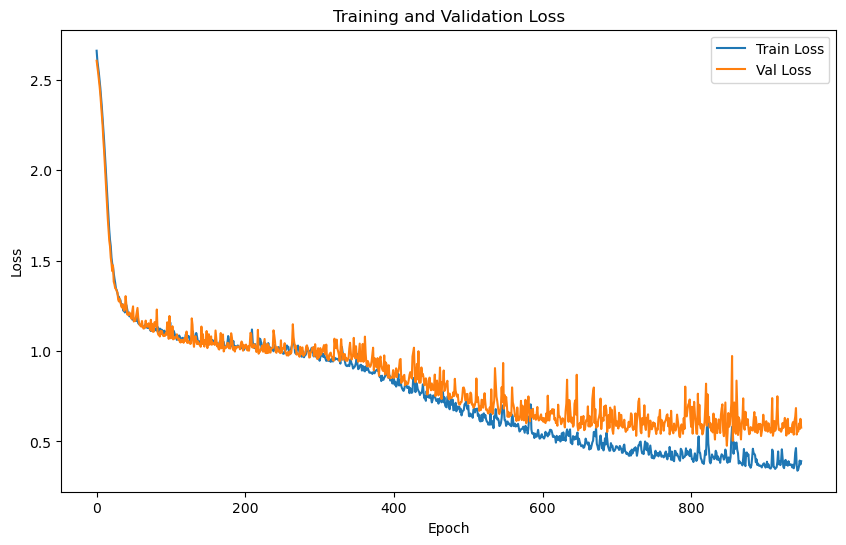

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.5865 | Test Accuracy: 79.41%


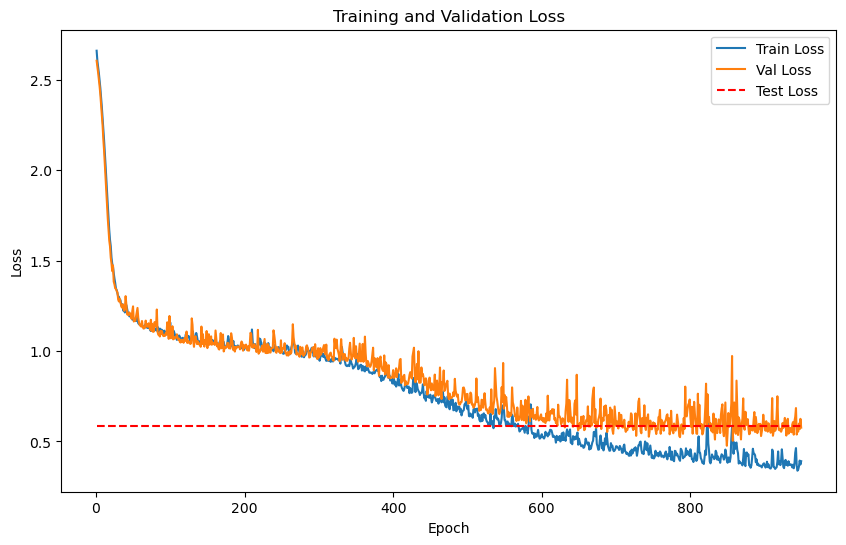

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 8.0800
    Batch [2/2], Train Loss: 7.9752
Epoch [1/2000], Avg Train Loss: 8.0276
Epoch [1/2000], Avg Val Loss: 3.3947
Validation loss improved from inf to 3.3947. Saving model...

LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 7.8421
    Batch [2/2], Train Loss: 7.8026
Epoch [2/2000], Avg Train Loss: 7.8223
Epoch [2/2000], Avg Val Loss: 3.3706
Validation loss improved from 3.3947 to 3.3706. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.7684
    Batch [2/2], Train Loss: 7.6757
Epoch [3/2000], Avg Train Loss: 7.7220
Epoch [3/2000], Avg Val Loss: 3.3488
Validation loss improved from 3.3706 to 3.3488. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.4843
    Batch [2/2], Train Loss: 7.6864
Epoch [4/2000], Avg Train Loss: 7.5853
Epoch [4/2000], Avg Val Loss: 3.3295
Validation loss improved from 3.3488 to 3.3295. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.4828
    Batch [2/2], Train Loss: 7.3760
Epoch [5/2000], Avg Train Loss: 7.4294
Epoch [5/2000], Avg Val Loss: 3.3121
Validation loss improved from 3.3295 to 3.3121. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train L

    Batch [2/2], Train Loss: 6.8484
Epoch [10/2000], Avg Train Loss: 6.8570
Epoch [10/2000], Avg Val Loss: 3.2520
Validation loss improved from 3.2612 to 3.2520. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 6.7558
    Batch [2/2], Train Loss: 6.6950
Epoch [11/2000], Avg Train Loss: 6.7254
Epoch [11/2000], Avg Val Loss: 3.2438
Validation loss improved from 3.2520 to 3.2438. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.6370
    Batch [2/2], Train Loss: 6.6710
Epoch [12/2000], Avg Train Loss: 6.6540
Epoch [12/2000], Avg Val Loss: 3.2369
Validation loss improved from 3.2438 to 3.2369. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.5140
    Batch [2/2], Train Loss: 6.4486
Epoch [13/2000], Avg Train Loss: 6.4813
Epoch [13/2000], Avg Val Loss: 3.2308
Validation loss improved from 3.2369 to 3.2308. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.4894
    Batch [2

Epoch [14/2000], Avg Val Loss: 3.2254
Validation loss improved from 3.2308 to 3.2254. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.4076
    Batch [2/2], Train Loss: 6.2577
Epoch [15/2000], Avg Train Loss: 6.3326
Epoch [15/2000], Avg Val Loss: 3.2207
Validation loss improved from 3.2254 to 3.2207. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.2392
    Batch [2/2], Train Loss: 6.1831
Epoch [16/2000], Avg Train Loss: 6.2111
Epoch [16/2000], Avg Val Loss: 3.2165
Validation loss improved from 3.2207 to 3.2165. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.3097
    Batch [2/2], Train Loss: 6.2068
Epoch [17/2000], Avg Train Loss: 6.2583
Epoch [17/2000], Avg Val Loss: 3.2128
Validation loss improved from 3.2165 to 3.2128. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 6.0724
    Batch [2/2], Train Loss: 6.0529
Epoch [18/2000], Avg Train Loss: 6.0627
Epoch [18/20

    Batch [2/2], Train Loss: 6.0049
Epoch [21/2000], Avg Train Loss: 5.9658
Epoch [21/2000], Avg Val Loss: 3.2021
Validation loss improved from 3.2044 to 3.2021. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 5.8814
    Batch [2/2], Train Loss: 5.9222
Epoch [22/2000], Avg Train Loss: 5.9018
Epoch [22/2000], Avg Val Loss: 3.2001
Validation loss improved from 3.2021 to 3.2001. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 5.8799
    Batch [2/2], Train Loss: 5.8477
Epoch [23/2000], Avg Train Loss: 5.8638
Epoch [23/2000], Avg Val Loss: 3.1984
Validation loss improved from 3.2001 to 3.1984. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.7065
    Batch [2/2], Train Loss: 5.8812
Epoch [24/2000], Avg Train Loss: 5.7939
Epoch [24/2000], Avg Val Loss: 3.1968
Validation loss improved from 3.1984 to 3.1968. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 5.7255
    Batch [2

    Batch [2/2], Train Loss: 5.5153
Epoch [28/2000], Avg Train Loss: 5.5681
Epoch [28/2000], Avg Val Loss: 3.1918
Validation loss improved from 3.1929 to 3.1918. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.6066
    Batch [2/2], Train Loss: 5.5416
Epoch [29/2000], Avg Train Loss: 5.5741
Epoch [29/2000], Avg Val Loss: 3.1908
Validation loss improved from 3.1918 to 3.1908. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.5854
    Batch [2/2], Train Loss: 5.4641
Epoch [30/2000], Avg Train Loss: 5.5247
Epoch [30/2000], Avg Val Loss: 3.1897
Validation loss improved from 3.1908 to 3.1897. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 5.4781
    Batch [2/2], Train Loss: 5.5005
Epoch [31/2000], Avg Train Loss: 5.4893
Epoch [31/2000], Avg Val Loss: 3.1886
Validation loss improved from 3.1897 to 3.1886. Saving model...

LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 5.4700
    Batch [2/2], Train Loss: 5.4733
Epoch [32/2000], Avg Train Loss: 5.4717
Epoch [32/2000], Avg Val Loss: 3.1875
Validation loss improved from 3.1886 to 3.1875. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.4716
    Batch [2/2], Train Loss: 5.4075
Epoch [33/2000], Avg Train Loss: 5.4396
Epoch [33/2000], Avg Val Loss: 3.1864
Validation loss improved from 3.1875 to 3.1864. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.4805
    Batch [2/2], Train Loss: 5.4126
Epoch [34/2000], Avg Train Loss: 5.4465
Epoch [34/2000], Avg Val Loss: 3.1852
Validation loss improved from 3.1864 to 3.1852. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.4037
    Batch [2/2], Train Loss: 5.3594
Epoch [35/2000], Avg Train Loss: 5.3816
Epoch [35/2000], Avg Val Loss: 3.1841
Validation loss improved from 3.1852 to 3.1841. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1

Epoch [37/2000], Avg Val Loss: 3.1817
Validation loss improved from 3.1829 to 3.1817. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.4030
    Batch [2/2], Train Loss: 5.3050
Epoch [38/2000], Avg Train Loss: 5.3540
Epoch [38/2000], Avg Val Loss: 3.1804
Validation loss improved from 3.1817 to 3.1804. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 5.2763
    Batch [2/2], Train Loss: 5.3207
Epoch [39/2000], Avg Train Loss: 5.2985
Epoch [39/2000], Avg Val Loss: 3.1791
Validation loss improved from 3.1804 to 3.1791. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.3272
    Batch [2/2], Train Loss: 5.3527
Epoch [40/2000], Avg Train Loss: 5.3399
Epoch [40/2000], Avg Val Loss: 3.1778
Validation loss improved from 3.1791 to 3.1778. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 5.2420
    Batch [2/2], Train Loss: 5.2622
Epoch [41/2000], Avg Train Loss: 5.2521
Epoch [41/20

    Batch [1/2], Train Loss: 5.2101
    Batch [2/2], Train Loss: 5.1311
Epoch [47/2000], Avg Train Loss: 5.1706
Epoch [47/2000], Avg Val Loss: 3.1679
Validation loss improved from 3.1695 to 3.1679. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.1623
    Batch [2/2], Train Loss: 5.1408
Epoch [48/2000], Avg Train Loss: 5.1515
Epoch [48/2000], Avg Val Loss: 3.1662
Validation loss improved from 3.1679 to 3.1662. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 5.1220
    Batch [2/2], Train Loss: 5.1727
Epoch [49/2000], Avg Train Loss: 5.1474
Epoch [49/2000], Avg Val Loss: 3.1645
Validation loss improved from 3.1662 to 3.1645. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 5.1227
    Batch [2/2], Train Loss: 5.1360
Epoch [50/2000], Avg Train Loss: 5.1293
Epoch [50/2000], Avg Val Loss: 3.1626
Validation loss improved from 3.1645 to 3.1626. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.1220
Epoch [52/2000], Avg Train Loss: 5.1221
Epoch [52/2000], Avg Val Loss: 3.1585
Validation loss improved from 3.1605 to 3.1585. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 5.1053
    Batch [2/2], Train Loss: 5.0976
Epoch [53/2000], Avg Train Loss: 5.1014
Epoch [53/2000], Avg Val Loss: 3.1564
Validation loss improved from 3.1585 to 3.1564. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 5.1669
    Batch [2/2], Train Loss: 5.1289
Epoch [54/2000], Avg Train Loss: 5.1479
Epoch [54/2000], Avg Val Loss: 3.1542
Validation loss improved from 3.1564 to 3.1542. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 5.1012
    Batch [2/2], Train Loss: 5.1160
Epoch [55/2000], Avg Train Loss: 5.1086
Epoch [55/2000], Avg Val Loss: 3.1521
Validation loss improved from 3.1542 to 3.1521. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 5.0847
    Batch [2

    Batch [1/2], Train Loss: 5.0763
    Batch [2/2], Train Loss: 5.0960
Epoch [59/2000], Avg Train Loss: 5.0862
Epoch [59/2000], Avg Val Loss: 3.1434
Validation loss improved from 3.1456 to 3.1434. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 4.9986
    Batch [2/2], Train Loss: 5.0505
Epoch [60/2000], Avg Train Loss: 5.0245
Epoch [60/2000], Avg Val Loss: 3.1411
Validation loss improved from 3.1434 to 3.1411. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 4.9916
    Batch [2/2], Train Loss: 4.9992
Epoch [61/2000], Avg Train Loss: 4.9954
Epoch [61/2000], Avg Val Loss: 3.1389
Validation loss improved from 3.1411 to 3.1389. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 5.0205
    Batch [2/2], Train Loss: 5.0683
Epoch [62/2000], Avg Train Loss: 5.0444
Epoch [62/2000], Avg Val Loss: 3.1367
Validation loss improved from 3.1389 to 3.1367. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.9665
    Batch [2/2], Train Loss: 5.0198
Epoch [70/2000], Avg Train Loss: 4.9931
Epoch [70/2000], Avg Val Loss: 3.1186
Validation loss improved from 3.1209 to 3.1186. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 4.9208
    Batch [2/2], Train Loss: 4.9725
Epoch [71/2000], Avg Train Loss: 4.9466
Epoch [71/2000], Avg Val Loss: 3.1163
Validation loss improved from 3.1186 to 3.1163. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 4.9725
    Batch [2/2], Train Loss: 4.8866
Epoch [72/2000], Avg Train Loss: 4.9295
Epoch [72/2000], Avg Val Loss: 3.1139
Validation loss improved from 3.1163 to 3.1139. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 4.9486
    Batch [2/2], Train Loss: 4.9500
Epoch [73/2000], Avg Train Loss: 4.9493
Epoch [73/2000], Avg Val Loss: 3.1115
Validation loss improved from 3.1139 to 3.1115. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.8959
    Batch [2/2], Train Loss: 4.9878
Epoch [76/2000], Avg Train Loss: 4.9419
Epoch [76/2000], Avg Val Loss: 3.1040
Validation loss improved from 3.1065 to 3.1040. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.9227
    Batch [2/2], Train Loss: 4.8511
Epoch [77/2000], Avg Train Loss: 4.8869
Epoch [77/2000], Avg Val Loss: 3.1015
Validation loss improved from 3.1040 to 3.1015. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.8976
    Batch [2/2], Train Loss: 4.9272
Epoch [78/2000], Avg Train Loss: 4.9124
Epoch [78/2000], Avg Val Loss: 3.0989
Validation loss improved from 3.1015 to 3.0989. Saving model...

LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 4.8688
    Batch [2/2], Train Loss: 4.8903
Epoch [79/2000], Avg Train Loss: 4.8795
Epoch [79/2000], Avg Val Loss: 3.0963
Validation loss improved from 3.0989 to 3.0963. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 4.8992
    Batch [2/2], Train Loss: 4.8510
Epoch [80/2000], Avg Train Loss: 4.8751
Epoch [80/2000], Avg Val Loss: 3.0937
Validation loss improved from 3.0963 to 3.0937. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.9153
    Batch [2/2], Train Loss: 4.8864
Epoch [81/2000], Avg Train Loss: 4.9009
Epoch [81/2000], Avg Val Loss: 3.0911
Validation loss improved from 3.0937 to 3.0911. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.8946
    Batch [2/2], Train Loss: 4.8914
Epoch [82/2000], Avg Train Loss: 4.8930
Epoch [82/2000], Avg Val Loss: 3.0885
Validation loss improved from 3.0911 to 3.0885. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.8319
Epoch [91/2000], Avg Train Loss: 4.8212
Epoch [91/2000], Avg Val Loss: 3.0646
Validation loss improved from 3.0672 to 3.0646. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 4.8135
    Batch [2/2], Train Loss: 4.8129
Epoch [92/2000], Avg Train Loss: 4.8132
Epoch [92/2000], Avg Val Loss: 3.0619
Validation loss improved from 3.0646 to 3.0619. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 4.8651
    Batch [2/2], Train Loss: 4.7984
Epoch [93/2000], Avg Train Loss: 4.8318
Epoch [93/2000], Avg Val Loss: 3.0593
Validation loss improved from 3.0619 to 3.0593. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 4.8234
    Batch [2/2], Train Loss: 4.8280
Epoch [94/2000], Avg Train Loss: 4.8257
Epoch [94/2000], Avg Val Loss: 3.0566
Validation loss improved from 3.0593 to 3.0566. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 4.7852
    Batch [2

Epoch [97/2000], Avg Val Loss: 3.0484
Validation loss improved from 3.0512 to 3.0484. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 4.8011
    Batch [2/2], Train Loss: 4.8024
Epoch [98/2000], Avg Train Loss: 4.8018
Epoch [98/2000], Avg Val Loss: 3.0456
Validation loss improved from 3.0484 to 3.0456. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 4.7999
    Batch [2/2], Train Loss: 4.7536
Epoch [99/2000], Avg Train Loss: 4.7767
Epoch [99/2000], Avg Val Loss: 3.0428
Validation loss improved from 3.0456 to 3.0428. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 4.7455
    Batch [2/2], Train Loss: 4.7602
Epoch [100/2000], Avg Train Loss: 4.7529
Epoch [100/2000], Avg Val Loss: 3.0400
Validation loss improved from 3.0428 to 3.0400. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 4.7590
    Batch [2/2], Train Loss: 4.7630
Epoch [101/2000], Avg Train Loss: 4.7610
Epoch [

    Batch [1/2], Train Loss: 4.7264
    Batch [2/2], Train Loss: 4.7485
Epoch [112/2000], Avg Train Loss: 4.7375
Epoch [112/2000], Avg Val Loss: 3.0069
Validation loss improved from 3.0096 to 3.0069. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 4.6957
    Batch [2/2], Train Loss: 4.7202
Epoch [113/2000], Avg Train Loss: 4.7079
Epoch [113/2000], Avg Val Loss: 3.0043
Validation loss improved from 3.0069 to 3.0043. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 4.7357
    Batch [2/2], Train Loss: 4.7325
Epoch [114/2000], Avg Train Loss: 4.7341
Epoch [114/2000], Avg Val Loss: 3.0017
Validation loss improved from 3.0043 to 3.0017. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 4.7534
    Batch [2/2], Train Loss: 4.6906
Epoch [115/2000], Avg Train Loss: 4.7220
Epoch [115/2000], Avg Val Loss: 2.9992
Validation loss improved from 3.0017 to 2.9992. Saving model...

LOG: Epoch [116/2000] - Training


Epoch [118/2000], Avg Val Loss: 2.9913
Validation loss improved from 2.9939 to 2.9913. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 4.7121
    Batch [2/2], Train Loss: 4.6738
Epoch [119/2000], Avg Train Loss: 4.6930
Epoch [119/2000], Avg Val Loss: 2.9886
Validation loss improved from 2.9913 to 2.9886. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.7153
    Batch [2/2], Train Loss: 4.6655
Epoch [120/2000], Avg Train Loss: 4.6904
Epoch [120/2000], Avg Val Loss: 2.9860
Validation loss improved from 2.9886 to 2.9860. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 4.7390
    Batch [2/2], Train Loss: 4.6883
Epoch [121/2000], Avg Train Loss: 4.7136
Epoch [121/2000], Avg Val Loss: 2.9833
Validation loss improved from 2.9860 to 2.9833. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 4.7544
    Batch [2/2], Train Loss: 4.6957
Epoch [122/2000], Avg Train Loss: 4.7250


    Batch [1/2], Train Loss: 4.6096
    Batch [2/2], Train Loss: 4.6423
Epoch [134/2000], Avg Train Loss: 4.6260
Epoch [134/2000], Avg Val Loss: 2.9501
Validation loss improved from 2.9527 to 2.9501. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.6276
    Batch [2/2], Train Loss: 4.6426
Epoch [135/2000], Avg Train Loss: 4.6351
Epoch [135/2000], Avg Val Loss: 2.9475
Validation loss improved from 2.9501 to 2.9475. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.6261
    Batch [2/2], Train Loss: 4.6591
Epoch [136/2000], Avg Train Loss: 4.6426
Epoch [136/2000], Avg Val Loss: 2.9449
Validation loss improved from 2.9475 to 2.9449. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.5830
    Batch [2/2], Train Loss: 4.5697
Epoch [137/2000], Avg Train Loss: 4.5763
Epoch [137/2000], Avg Val Loss: 2.9422
Validation loss improved from 2.9449 to 2.9422. Saving model...

LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 4.6235
    Batch [2/2], Train Loss: 4.6238
Epoch [141/2000], Avg Train Loss: 4.6236
Epoch [141/2000], Avg Val Loss: 2.9316
Validation loss improved from 2.9342 to 2.9316. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 4.5714
    Batch [2/2], Train Loss: 4.6192
Epoch [142/2000], Avg Train Loss: 4.5953
Epoch [142/2000], Avg Val Loss: 2.9290
Validation loss improved from 2.9316 to 2.9290. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.5834
    Batch [2/2], Train Loss: 4.6337
Epoch [143/2000], Avg Train Loss: 4.6085
Epoch [143/2000], Avg Val Loss: 2.9264
Validation loss improved from 2.9290 to 2.9264. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.5852
    Batch [2/2], Train Loss: 4.5824
Epoch [144/2000], Avg Train Loss: 4.5838
Epoch [144/2000], Avg Val Loss: 2.9238
Validation loss improved from 2.9264 to 2.9238. Saving model...

LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 4.5448
    Batch [2/2], Train Loss: 4.5355
Epoch [153/2000], Avg Train Loss: 4.5401
Epoch [153/2000], Avg Val Loss: 2.9012
Validation loss improved from 2.9037 to 2.9012. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 4.5789
    Batch [2/2], Train Loss: 4.5735
Epoch [154/2000], Avg Train Loss: 4.5762
Epoch [154/2000], Avg Val Loss: 2.8987
Validation loss improved from 2.9012 to 2.8987. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 4.5744
    Batch [2/2], Train Loss: 4.5174
Epoch [155/2000], Avg Train Loss: 4.5459
Epoch [155/2000], Avg Val Loss: 2.8962
Validation loss improved from 2.8987 to 2.8962. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 4.5626
    Batch [2/2], Train Loss: 4.5948
Epoch [156/2000], Avg Train Loss: 4.5787
Epoch [156/2000], Avg Val Loss: 2.8938
Validation loss improved from 2.8962 to 2.8938. Saving model...

LOG: Epoch [157/2000] - Training


    Batch [2/2], Train Loss: 4.4926
Epoch [174/2000], Avg Train Loss: 4.4616
Epoch [174/2000], Avg Val Loss: 2.8485
Validation loss improved from 2.8509 to 2.8485. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 4.5079
    Batch [2/2], Train Loss: 4.4885
Epoch [175/2000], Avg Train Loss: 4.4982
Epoch [175/2000], Avg Val Loss: 2.8461
Validation loss improved from 2.8485 to 2.8461. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.4983
    Batch [2/2], Train Loss: 4.4367
Epoch [176/2000], Avg Train Loss: 4.4675
Epoch [176/2000], Avg Val Loss: 2.8437
Validation loss improved from 2.8461 to 2.8437. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.4586
    Batch [2/2], Train Loss: 4.4721
Epoch [177/2000], Avg Train Loss: 4.4653
Epoch [177/2000], Avg Val Loss: 2.8413
Validation loss improved from 2.8437 to 2.8413. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.4275


    Batch [1/2], Train Loss: 4.4399
    Batch [2/2], Train Loss: 4.4441
Epoch [196/2000], Avg Train Loss: 4.4420
Epoch [196/2000], Avg Val Loss: 2.7953
Validation loss improved from 2.7977 to 2.7953. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 4.4273
    Batch [2/2], Train Loss: 4.4312
Epoch [197/2000], Avg Train Loss: 4.4293
Epoch [197/2000], Avg Val Loss: 2.7928
Validation loss improved from 2.7953 to 2.7928. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 4.4202
    Batch [2/2], Train Loss: 4.4206
Epoch [198/2000], Avg Train Loss: 4.4204
Epoch [198/2000], Avg Val Loss: 2.7902
Validation loss improved from 2.7928 to 2.7902. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.3619
    Batch [2/2], Train Loss: 4.4348
Epoch [199/2000], Avg Train Loss: 4.3984
Epoch [199/2000], Avg Val Loss: 2.7876
Validation loss improved from 2.7902 to 2.7876. Saving model...

LOG: Epoch [200/2000] - Training


Epoch [216/2000], Avg Val Loss: 2.7483
Validation loss improved from 2.7505 to 2.7483. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 4.3482
    Batch [2/2], Train Loss: 4.3173
Epoch [217/2000], Avg Train Loss: 4.3328
Epoch [217/2000], Avg Val Loss: 2.7460
Validation loss improved from 2.7483 to 2.7460. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.3876
    Batch [2/2], Train Loss: 4.3322
Epoch [218/2000], Avg Train Loss: 4.3599
Epoch [218/2000], Avg Val Loss: 2.7437
Validation loss improved from 2.7460 to 2.7437. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 4.3331
    Batch [2/2], Train Loss: 4.3482
Epoch [219/2000], Avg Train Loss: 4.3406
Epoch [219/2000], Avg Val Loss: 2.7414
Validation loss improved from 2.7437 to 2.7414. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 4.3639
    Batch [2/2], Train Loss: 4.3376
Epoch [220/2000], Avg Train Loss: 4.3507


Epoch [238/2000], Avg Val Loss: 2.6979
Validation loss improved from 2.7001 to 2.6979. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 4.2842
    Batch [2/2], Train Loss: 4.3072
Epoch [239/2000], Avg Train Loss: 4.2957
Epoch [239/2000], Avg Val Loss: 2.6958
Validation loss improved from 2.6979 to 2.6958. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 4.3085
    Batch [2/2], Train Loss: 4.2365
Epoch [240/2000], Avg Train Loss: 4.2725
Epoch [240/2000], Avg Val Loss: 2.6938
Validation loss improved from 2.6958 to 2.6938. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 4.2752
    Batch [2/2], Train Loss: 4.2821
Epoch [241/2000], Avg Train Loss: 4.2787
Epoch [241/2000], Avg Val Loss: 2.6917
Validation loss improved from 2.6938 to 2.6917. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 4.2691
    Batch [2/2], Train Loss: 4.2633
Epoch [242/2000], Avg Train Loss: 4.2662


    Batch [2/2], Train Loss: 4.2750
Epoch [261/2000], Avg Train Loss: 4.2679
Epoch [261/2000], Avg Val Loss: 2.6523
Validation loss improved from 2.6543 to 2.6523. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 4.2145
    Batch [2/2], Train Loss: 4.1922
Epoch [262/2000], Avg Train Loss: 4.2033
Epoch [262/2000], Avg Val Loss: 2.6504
Validation loss improved from 2.6523 to 2.6504. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 4.2421
    Batch [2/2], Train Loss: 4.1974
Epoch [263/2000], Avg Train Loss: 4.2197
Epoch [263/2000], Avg Val Loss: 2.6485
Validation loss improved from 2.6504 to 2.6485. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 4.2083
    Batch [2/2], Train Loss: 4.2129
Epoch [264/2000], Avg Train Loss: 4.2106
Epoch [264/2000], Avg Val Loss: 2.6466
Validation loss improved from 2.6485 to 2.6466. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 4.1804


    Batch [1/2], Train Loss: 4.1738
    Batch [2/2], Train Loss: 4.1331
Epoch [282/2000], Avg Train Loss: 4.1534
Epoch [282/2000], Avg Val Loss: 2.6154
Validation loss improved from 2.6170 to 2.6154. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 4.1718
    Batch [2/2], Train Loss: 4.1759
Epoch [283/2000], Avg Train Loss: 4.1738
Epoch [283/2000], Avg Val Loss: 2.6139
Validation loss improved from 2.6154 to 2.6139. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.1380
    Batch [2/2], Train Loss: 4.1511
Epoch [284/2000], Avg Train Loss: 4.1445
Epoch [284/2000], Avg Val Loss: 2.6122
Validation loss improved from 2.6139 to 2.6122. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.2343
    Batch [2/2], Train Loss: 4.2035
Epoch [285/2000], Avg Train Loss: 4.2189
Epoch [285/2000], Avg Val Loss: 2.6106
Validation loss improved from 2.6122 to 2.6106. Saving model...

LOG: Epoch [286/2000] - Training


    Batch [2/2], Train Loss: 4.1264
Epoch [303/2000], Avg Train Loss: 4.1161
Epoch [303/2000], Avg Val Loss: 2.5841
Validation loss improved from 2.5854 to 2.5841. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 4.1484
    Batch [2/2], Train Loss: 4.1352
Epoch [304/2000], Avg Train Loss: 4.1418
Epoch [304/2000], Avg Val Loss: 2.5827
Validation loss improved from 2.5841 to 2.5827. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 4.1142
    Batch [2/2], Train Loss: 4.1258
Epoch [305/2000], Avg Train Loss: 4.1200
Epoch [305/2000], Avg Val Loss: 2.5813
Validation loss improved from 2.5827 to 2.5813. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 4.0790
    Batch [2/2], Train Loss: 4.1284
Epoch [306/2000], Avg Train Loss: 4.1037
Epoch [306/2000], Avg Val Loss: 2.5800
Validation loss improved from 2.5813 to 2.5800. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 4.1387


    Batch [1/2], Train Loss: 4.0918
    Batch [2/2], Train Loss: 4.0333
Epoch [326/2000], Avg Train Loss: 4.0625
Epoch [326/2000], Avg Val Loss: 2.5535
Validation loss improved from 2.5550 to 2.5535. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 4.0088
    Batch [2/2], Train Loss: 4.0926
Epoch [327/2000], Avg Train Loss: 4.0507
Epoch [327/2000], Avg Val Loss: 2.5520
Validation loss improved from 2.5535 to 2.5520. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 4.1094
    Batch [2/2], Train Loss: 4.0632
Epoch [328/2000], Avg Train Loss: 4.0863
Epoch [328/2000], Avg Val Loss: 2.5506
Validation loss improved from 2.5520 to 2.5506. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 4.0499
    Batch [2/2], Train Loss: 4.1261
Epoch [329/2000], Avg Train Loss: 4.0880
Epoch [329/2000], Avg Val Loss: 2.5490
Validation loss improved from 2.5506 to 2.5490. Saving model...

LOG: Epoch [330/2000] - Training


    Batch [2/2], Train Loss: 3.9992
Epoch [347/2000], Avg Train Loss: 4.0577
Epoch [347/2000], Avg Val Loss: 2.5297
Validation loss improved from 2.5307 to 2.5297. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 4.0557
    Batch [2/2], Train Loss: 4.0387
Epoch [348/2000], Avg Train Loss: 4.0472
Epoch [348/2000], Avg Val Loss: 2.5287
Validation loss improved from 2.5297 to 2.5287. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 4.0320
    Batch [2/2], Train Loss: 4.0349
Epoch [349/2000], Avg Train Loss: 4.0335
Epoch [349/2000], Avg Val Loss: 2.5279
Validation loss improved from 2.5287 to 2.5279. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 4.0397
    Batch [2/2], Train Loss: 4.0156
Epoch [350/2000], Avg Train Loss: 4.0277
Epoch [350/2000], Avg Val Loss: 2.5269
Validation loss improved from 2.5279 to 2.5269. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 4.0288


    Batch [2/2], Train Loss: 3.9797
Epoch [368/2000], Avg Train Loss: 3.9876
Epoch [368/2000], Avg Val Loss: 2.5092
Validation loss improved from 2.5102 to 2.5092. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 4.0074
    Batch [2/2], Train Loss: 4.0132
Epoch [369/2000], Avg Train Loss: 4.0103
Epoch [369/2000], Avg Val Loss: 2.5083
Validation loss improved from 2.5092 to 2.5083. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 4.0183
    Batch [2/2], Train Loss: 3.9899
Epoch [370/2000], Avg Train Loss: 4.0041
Epoch [370/2000], Avg Val Loss: 2.5073
Validation loss improved from 2.5083 to 2.5073. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 4.0133
    Batch [2/2], Train Loss: 3.9665
Epoch [371/2000], Avg Train Loss: 3.9899
Epoch [371/2000], Avg Val Loss: 2.5063
Validation loss improved from 2.5073 to 2.5063. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 3.9507


    Batch [1/2], Train Loss: 3.9514
    Batch [2/2], Train Loss: 3.9352
Epoch [391/2000], Avg Train Loss: 3.9433
Epoch [391/2000], Avg Val Loss: 2.4877
Validation loss improved from 2.4884 to 2.4877. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 3.9847
    Batch [2/2], Train Loss: 3.9371
Epoch [392/2000], Avg Train Loss: 3.9609
Epoch [392/2000], Avg Val Loss: 2.4868
Validation loss improved from 2.4877 to 2.4868. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 3.9238
    Batch [2/2], Train Loss: 3.9886
Epoch [393/2000], Avg Train Loss: 3.9562
Epoch [393/2000], Avg Val Loss: 2.4857
Validation loss improved from 2.4868 to 2.4857. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 3.9642
    Batch [2/2], Train Loss: 3.9602
Epoch [394/2000], Avg Train Loss: 3.9622
Epoch [394/2000], Avg Val Loss: 2.4846
Validation loss improved from 2.4857 to 2.4846. Saving model...

LOG: Epoch [395/2000] - Training


    Batch [2/2], Train Loss: 3.9012
Epoch [412/2000], Avg Train Loss: 3.9092
Epoch [412/2000], Avg Val Loss: 2.4710
Validation loss improved from 2.4713 to 2.4710. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 3.9651
    Batch [2/2], Train Loss: 3.9373
Epoch [413/2000], Avg Train Loss: 3.9512
Epoch [413/2000], Avg Val Loss: 2.4705
Validation loss improved from 2.4710 to 2.4705. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 3.9009
    Batch [2/2], Train Loss: 3.9294
Epoch [414/2000], Avg Train Loss: 3.9152
Epoch [414/2000], Avg Val Loss: 2.4696
Validation loss improved from 2.4705 to 2.4696. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 3.9175
    Batch [2/2], Train Loss: 3.9682
Epoch [415/2000], Avg Train Loss: 3.9429
Epoch [415/2000], Avg Val Loss: 2.4689
Validation loss improved from 2.4696 to 2.4689. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 3.9183


    Batch [2/2], Train Loss: 3.9673
Epoch [434/2000], Avg Train Loss: 3.9397
Epoch [434/2000], Avg Val Loss: 2.4505
Validation loss improved from 2.4516 to 2.4505. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 3.9284
    Batch [2/2], Train Loss: 3.9174
Epoch [435/2000], Avg Train Loss: 3.9229
Epoch [435/2000], Avg Val Loss: 2.4494
Validation loss improved from 2.4505 to 2.4494. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 3.8903
    Batch [2/2], Train Loss: 3.9350
Epoch [436/2000], Avg Train Loss: 3.9127
Epoch [436/2000], Avg Val Loss: 2.4485
Validation loss improved from 2.4494 to 2.4485. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 3.9135
    Batch [2/2], Train Loss: 3.9152
Epoch [437/2000], Avg Train Loss: 3.9144
Epoch [437/2000], Avg Val Loss: 2.4477
Validation loss improved from 2.4485 to 2.4477. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 3.8779


    Batch [1/2], Train Loss: 3.9055
    Batch [2/2], Train Loss: 3.8901
Epoch [456/2000], Avg Train Loss: 3.8978
Epoch [456/2000], Avg Val Loss: 2.4375
Validation loss improved from 2.4380 to 2.4375. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 3.8633
    Batch [2/2], Train Loss: 3.8857
Epoch [457/2000], Avg Train Loss: 3.8745
Epoch [457/2000], Avg Val Loss: 2.4371
Validation loss improved from 2.4375 to 2.4371. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 3.8768
    Batch [2/2], Train Loss: 3.8539
Epoch [458/2000], Avg Train Loss: 3.8654
Epoch [458/2000], Avg Val Loss: 2.4365
Validation loss improved from 2.4371 to 2.4365. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 3.8933
    Batch [2/2], Train Loss: 3.8903
Epoch [459/2000], Avg Train Loss: 3.8918
Epoch [459/2000], Avg Val Loss: 2.4360
Validation loss improved from 2.4365 to 2.4360. Saving model...

LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 3.8773
    Batch [2/2], Train Loss: 3.9132
Epoch [480/2000], Avg Train Loss: 3.8952
Epoch [480/2000], Avg Val Loss: 2.4204
Validation loss improved from 2.4219 to 2.4204. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 3.8583
    Batch [2/2], Train Loss: 3.8588
Epoch [481/2000], Avg Train Loss: 3.8586
Epoch [481/2000], Avg Val Loss: 2.4191
Validation loss improved from 2.4204 to 2.4191. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 3.8166
    Batch [2/2], Train Loss: 3.8226
Epoch [482/2000], Avg Train Loss: 3.8196
Epoch [482/2000], Avg Val Loss: 2.4179
Validation loss improved from 2.4191 to 2.4179. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 3.8923
    Batch [2/2], Train Loss: 3.8403
Epoch [483/2000], Avg Train Loss: 3.8663
Epoch [483/2000], Avg Val Loss: 2.4168
Validation loss improved from 2.4179 to 2.4168. Saving model...

LOG: Epoch [484/2000] - Training


Epoch [502/2000], Avg Val Loss: 2.4033
Validation loss improved from 2.4043 to 2.4033. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 3.8291
    Batch [2/2], Train Loss: 3.8264
Epoch [503/2000], Avg Train Loss: 3.8277
Epoch [503/2000], Avg Val Loss: 2.4023
Validation loss improved from 2.4033 to 2.4023. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 3.8572
    Batch [2/2], Train Loss: 3.8067
Epoch [504/2000], Avg Train Loss: 3.8319
Epoch [504/2000], Avg Val Loss: 2.4013
Validation loss improved from 2.4023 to 2.4013. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 3.8571
    Batch [2/2], Train Loss: 3.8155
Epoch [505/2000], Avg Train Loss: 3.8363
Epoch [505/2000], Avg Val Loss: 2.4005
Validation loss improved from 2.4013 to 2.4005. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 3.8657
    Batch [2/2], Train Loss: 3.8294
Epoch [506/2000], Avg Train Loss: 3.8475


    Batch [2/2], Train Loss: 3.8385
Epoch [524/2000], Avg Train Loss: 3.8209
Epoch [524/2000], Avg Val Loss: 2.3945
Validation loss improved from 2.3946 to 2.3945. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 3.8421
    Batch [2/2], Train Loss: 3.7755
Epoch [525/2000], Avg Train Loss: 3.8088
Epoch [525/2000], Avg Val Loss: 2.3943
Validation loss improved from 2.3945 to 2.3943. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 3.7765
    Batch [2/2], Train Loss: 3.7887
Epoch [526/2000], Avg Train Loss: 3.7826
Epoch [526/2000], Avg Val Loss: 2.3939
Validation loss improved from 2.3943 to 2.3939. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/2], Train Loss: 3.7952
    Batch [2/2], Train Loss: 3.7491
Epoch [527/2000], Avg Train Loss: 3.7721
Epoch [527/2000], Avg Val Loss: 2.3934
Validation loss improved from 2.3939 to 2.3934. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 3.7662


    Batch [1/2], Train Loss: 3.8102
    Batch [2/2], Train Loss: 3.7506
Epoch [548/2000], Avg Train Loss: 3.7804
Epoch [548/2000], Avg Val Loss: 2.3837
Validation loss improved from 2.3843 to 2.3837. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 3.8163
    Batch [2/2], Train Loss: 3.7674
Epoch [549/2000], Avg Train Loss: 3.7919
Epoch [549/2000], Avg Val Loss: 2.3830
Validation loss improved from 2.3837 to 2.3830. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 3.7891
    Batch [2/2], Train Loss: 3.7636
Epoch [550/2000], Avg Train Loss: 3.7764
Epoch [550/2000], Avg Val Loss: 2.3822
Validation loss improved from 2.3830 to 2.3822. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 3.7411
    Batch [2/2], Train Loss: 3.7718
Epoch [551/2000], Avg Train Loss: 3.7565
Epoch [551/2000], Avg Val Loss: 2.3813
Validation loss improved from 2.3822 to 2.3813. Saving model...

LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 3.7374
    Batch [2/2], Train Loss: 3.7745
Epoch [570/2000], Avg Train Loss: 3.7559
Epoch [570/2000], Avg Val Loss: 2.3764
Validation loss did not improve. Patience: 5/100

LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 3.6886
    Batch [2/2], Train Loss: 3.6938
Epoch [571/2000], Avg Train Loss: 3.6912
Epoch [571/2000], Avg Val Loss: 2.3763
Validation loss did not improve. Patience: 6/100

LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 3.7949
    Batch [2/2], Train Loss: 3.8267
Epoch [572/2000], Avg Train Loss: 3.8108
Epoch [572/2000], Avg Val Loss: 2.3762
Validation loss did not improve. Patience: 7/100

LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 3.7072
    Batch [2/2], Train Loss: 3.7761
Epoch [573/2000], Avg Train Loss: 3.7417
Epoch [573/2000], Avg Val Loss: 2.3760
Validation loss did not improve. Patience: 8/100

LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 3.7625
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.7387
    Batch [2/2], Train Loss: 3.7453
Epoch [592/2000], Avg Train Loss: 3.7420
Epoch [592/2000], Avg Val Loss: 2.3645
Validation loss improved from 2.3648 to 2.3645. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 3.7431
    Batch [2/2], Train Loss: 3.7994
Epoch [593/2000], Avg Train Loss: 3.7713
Epoch [593/2000], Avg Val Loss: 2.3643
Validation loss improved from 2.3645 to 2.3643. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 3.7265
    Batch [2/2], Train Loss: 3.7449
Epoch [594/2000], Avg Train Loss: 3.7357
Epoch [594/2000], Avg Val Loss: 2.3641
Validation loss improved from 2.3643 to 2.3641. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 3.7729
    Batch [2/2], Train Loss: 3.7233
Epoch [595/2000], Avg Train Loss: 3.7481
Epoch [595/2000], Avg Val Loss: 2.3639
Validation loss improved from 2.3641 to 2.3639. Saving model...

LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 3.7410
    Batch [2/2], Train Loss: 3.7541
Epoch [614/2000], Avg Train Loss: 3.7476
Epoch [614/2000], Avg Val Loss: 2.3570
Validation loss improved from 2.3573 to 2.3570. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 3.7502
    Batch [2/2], Train Loss: 3.6749
Epoch [615/2000], Avg Train Loss: 3.7126
Epoch [615/2000], Avg Val Loss: 2.3569
Validation loss improved from 2.3570 to 2.3569. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 3.7270
    Batch [2/2], Train Loss: 3.7130
Epoch [616/2000], Avg Train Loss: 3.7200
Epoch [616/2000], Avg Val Loss: 2.3568
Validation loss improved from 2.3569 to 2.3568. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.7742
    Batch [2/2], Train Loss: 3.7355
Epoch [617/2000], Avg Train Loss: 3.7548
Epoch [617/2000], Avg Val Loss: 2.3564
Validation loss improved from 2.3568 to 2.3564. Saving model...

LOG: Epoch [618/2000] - Training


    Batch [1/2], Train Loss: 3.7515
    Batch [2/2], Train Loss: 3.7409
Epoch [638/2000], Avg Train Loss: 3.7462
Epoch [638/2000], Avg Val Loss: 2.3488
Validation loss improved from 2.3499 to 2.3488. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 3.7824
    Batch [2/2], Train Loss: 3.7084
Epoch [639/2000], Avg Train Loss: 3.7454
Epoch [639/2000], Avg Val Loss: 2.3479
Validation loss improved from 2.3488 to 2.3479. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 3.6856
    Batch [2/2], Train Loss: 3.7178
Epoch [640/2000], Avg Train Loss: 3.7017
Epoch [640/2000], Avg Val Loss: 2.3474
Validation loss improved from 2.3479 to 2.3474. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 3.7277
    Batch [2/2], Train Loss: 3.7281
Epoch [641/2000], Avg Train Loss: 3.7279
Epoch [641/2000], Avg Val Loss: 2.3467
Validation loss improved from 2.3474 to 2.3467. Saving model...

LOG: Epoch [642/2000] - Training


Epoch [659/2000], Avg Val Loss: 2.3436
Validation loss did not improve. Patience: 12/100

LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 3.6783
    Batch [2/2], Train Loss: 3.6932
Epoch [660/2000], Avg Train Loss: 3.6858
Epoch [660/2000], Avg Val Loss: 2.3432
Validation loss did not improve. Patience: 13/100

LOG: Epoch [661/2000] - Training
    Batch [1/2], Train Loss: 3.6992
    Batch [2/2], Train Loss: 3.6774
Epoch [661/2000], Avg Train Loss: 3.6883
Epoch [661/2000], Avg Val Loss: 2.3426
Validation loss did not improve. Patience: 14/100

LOG: Epoch [662/2000] - Training
    Batch [1/2], Train Loss: 3.6620
    Batch [2/2], Train Loss: 3.6735
Epoch [662/2000], Avg Train Loss: 3.6678
Epoch [662/2000], Avg Val Loss: 2.3422
Validation loss improved from 2.3422 to 2.3422. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 3.6892
    Batch [2/2], Train Loss: 3.7156
Epoch [663/2000], Avg Train Loss: 3.7024
Epoch [663/2000], Avg Val Loss: 2.3419
Val

    Batch [2/2], Train Loss: 3.7127
Epoch [681/2000], Avg Train Loss: 3.6883
Epoch [681/2000], Avg Val Loss: 2.3353
Validation loss improved from 2.3357 to 2.3353. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 3.6714
    Batch [2/2], Train Loss: 3.7052
Epoch [682/2000], Avg Train Loss: 3.6883
Epoch [682/2000], Avg Val Loss: 2.3348
Validation loss improved from 2.3353 to 2.3348. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 3.6859
    Batch [2/2], Train Loss: 3.7049
Epoch [683/2000], Avg Train Loss: 3.6954
Epoch [683/2000], Avg Val Loss: 2.3343
Validation loss improved from 2.3348 to 2.3343. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 3.6664
    Batch [2/2], Train Loss: 3.6518
Epoch [684/2000], Avg Train Loss: 3.6591
Epoch [684/2000], Avg Val Loss: 2.3336
Validation loss improved from 2.3343 to 2.3336. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/2], Train Loss: 3.6713


    Batch [1/2], Train Loss: 3.6321
    Batch [2/2], Train Loss: 3.6583
Epoch [704/2000], Avg Train Loss: 3.6452
Epoch [704/2000], Avg Val Loss: 2.3301
Validation loss improved from 2.3303 to 2.3301. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/2], Train Loss: 3.6445
    Batch [2/2], Train Loss: 3.6126
Epoch [705/2000], Avg Train Loss: 3.6286
Epoch [705/2000], Avg Val Loss: 2.3294
Validation loss improved from 2.3301 to 2.3294. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 3.6578
    Batch [2/2], Train Loss: 3.6741
Epoch [706/2000], Avg Train Loss: 3.6660
Epoch [706/2000], Avg Val Loss: 2.3288
Validation loss improved from 2.3294 to 2.3288. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/2], Train Loss: 3.6715
    Batch [2/2], Train Loss: 3.6909
Epoch [707/2000], Avg Train Loss: 3.6812
Epoch [707/2000], Avg Val Loss: 2.3280
Validation loss improved from 2.3288 to 2.3280. Saving model...

LOG: Epoch [708/2000] - Training


    Batch [1/2], Train Loss: 3.6220
    Batch [2/2], Train Loss: 3.6769
Epoch [727/2000], Avg Train Loss: 3.6494
Epoch [727/2000], Avg Val Loss: 2.3215
Validation loss did not improve. Patience: 1/100

LOG: Epoch [728/2000] - Training
    Batch [1/2], Train Loss: 3.6686
    Batch [2/2], Train Loss: 3.6346
Epoch [728/2000], Avg Train Loss: 3.6516
Epoch [728/2000], Avg Val Loss: 2.3217
Validation loss did not improve. Patience: 2/100

LOG: Epoch [729/2000] - Training
    Batch [1/2], Train Loss: 3.6481
    Batch [2/2], Train Loss: 3.6142
Epoch [729/2000], Avg Train Loss: 3.6311
Epoch [729/2000], Avg Val Loss: 2.3218
Validation loss did not improve. Patience: 3/100

LOG: Epoch [730/2000] - Training
    Batch [1/2], Train Loss: 3.6439
    Batch [2/2], Train Loss: 3.6380
Epoch [730/2000], Avg Train Loss: 3.6409
Epoch [730/2000], Avg Val Loss: 2.3214
Validation loss did not improve. Patience: 4/100

LOG: Epoch [731/2000] - Training
    Batch [1/2], Train Loss: 3.6689
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.6455
    Batch [2/2], Train Loss: 3.5471
Epoch [750/2000], Avg Train Loss: 3.5963
Epoch [750/2000], Avg Val Loss: 2.3133
Validation loss improved from 2.3137 to 2.3133. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/2], Train Loss: 3.6225
    Batch [2/2], Train Loss: 3.6427
Epoch [751/2000], Avg Train Loss: 3.6326
Epoch [751/2000], Avg Val Loss: 2.3129
Validation loss improved from 2.3133 to 2.3129. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 3.5793
    Batch [2/2], Train Loss: 3.6443
Epoch [752/2000], Avg Train Loss: 3.6118
Epoch [752/2000], Avg Val Loss: 2.3128
Validation loss improved from 2.3129 to 2.3128. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/2], Train Loss: 3.5899
    Batch [2/2], Train Loss: 3.5693
Epoch [753/2000], Avg Train Loss: 3.5796
Epoch [753/2000], Avg Val Loss: 2.3127
Validation loss improved from 2.3128 to 2.3127. Saving model...

LOG: Epoch [754/2000] - Training


    Batch [2/2], Train Loss: 3.5707
Epoch [771/2000], Avg Train Loss: 3.5958
Epoch [771/2000], Avg Val Loss: 2.3061
Validation loss improved from 2.3064 to 2.3061. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/2], Train Loss: 3.6130
    Batch [2/2], Train Loss: 3.5872
Epoch [772/2000], Avg Train Loss: 3.6001
Epoch [772/2000], Avg Val Loss: 2.3054
Validation loss improved from 2.3061 to 2.3054. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/2], Train Loss: 3.5932
    Batch [2/2], Train Loss: 3.5725
Epoch [773/2000], Avg Train Loss: 3.5828
Epoch [773/2000], Avg Val Loss: 2.3047
Validation loss improved from 2.3054 to 2.3047. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/2], Train Loss: 3.6092
    Batch [2/2], Train Loss: 3.5791
Epoch [774/2000], Avg Train Loss: 3.5941
Epoch [774/2000], Avg Val Loss: 2.3041
Validation loss improved from 2.3047 to 2.3041. Saving model...

LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 3.5704


    Batch [2/2], Train Loss: 3.6202
Epoch [794/2000], Avg Train Loss: 3.6008
Epoch [794/2000], Avg Val Loss: 2.3019
Validation loss did not improve. Patience: 5/100

LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 3.5979
    Batch [2/2], Train Loss: 3.6060
Epoch [795/2000], Avg Train Loss: 3.6019
Epoch [795/2000], Avg Val Loss: 2.3012
Validation loss improved from 2.3017 to 2.3012. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/2], Train Loss: 3.5853
    Batch [2/2], Train Loss: 3.6090
Epoch [796/2000], Avg Train Loss: 3.5972
Epoch [796/2000], Avg Val Loss: 2.3002
Validation loss improved from 2.3012 to 2.3002. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/2], Train Loss: 3.6043
    Batch [2/2], Train Loss: 3.5850
Epoch [797/2000], Avg Train Loss: 3.5947
Epoch [797/2000], Avg Val Loss: 2.2992
Validation loss improved from 2.3002 to 2.2992. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/2], Train Loss: 3.6123
    Batch [2/2]

    Batch [2/2], Train Loss: 3.5775
Epoch [816/2000], Avg Train Loss: 3.5534
Epoch [816/2000], Avg Val Loss: 2.2959
Validation loss did not improve. Patience: 8/100

LOG: Epoch [817/2000] - Training
    Batch [1/2], Train Loss: 3.5735
    Batch [2/2], Train Loss: 3.5501
Epoch [817/2000], Avg Train Loss: 3.5618
Epoch [817/2000], Avg Val Loss: 2.2958
Validation loss did not improve. Patience: 9/100

LOG: Epoch [818/2000] - Training
    Batch [1/2], Train Loss: 3.6053
    Batch [2/2], Train Loss: 3.5846
Epoch [818/2000], Avg Train Loss: 3.5950
Epoch [818/2000], Avg Val Loss: 2.2957
Validation loss did not improve. Patience: 10/100

LOG: Epoch [819/2000] - Training
    Batch [1/2], Train Loss: 3.5745
    Batch [2/2], Train Loss: 3.5573
Epoch [819/2000], Avg Train Loss: 3.5659
Epoch [819/2000], Avg Val Loss: 2.2953
Validation loss did not improve. Patience: 11/100

LOG: Epoch [820/2000] - Training
    Batch [1/2], Train Loss: 3.5701
    Batch [2/2], Train Loss: 3.5816
Epoch [820/2000], Avg 

    Batch [1/2], Train Loss: 3.5432
    Batch [2/2], Train Loss: 3.5714
Epoch [838/2000], Avg Train Loss: 3.5573
Epoch [838/2000], Avg Val Loss: 2.2924
Validation loss improved from 2.2924 to 2.2924. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/2], Train Loss: 3.5499
    Batch [2/2], Train Loss: 3.5773
Epoch [839/2000], Avg Train Loss: 3.5636
Epoch [839/2000], Avg Val Loss: 2.2922
Validation loss improved from 2.2924 to 2.2922. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/2], Train Loss: 3.5582
    Batch [2/2], Train Loss: 3.5883
Epoch [840/2000], Avg Train Loss: 3.5732
Epoch [840/2000], Avg Val Loss: 2.2915
Validation loss improved from 2.2922 to 2.2915. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/2], Train Loss: 3.5973
    Batch [2/2], Train Loss: 3.5594
Epoch [841/2000], Avg Train Loss: 3.5783
Epoch [841/2000], Avg Val Loss: 2.2910
Validation loss improved from 2.2915 to 2.2910. Saving model...

LOG: Epoch [842/2000] - Training


    Batch [1/2], Train Loss: 3.5762
    Batch [2/2], Train Loss: 3.5474
Epoch [862/2000], Avg Train Loss: 3.5618
Epoch [862/2000], Avg Val Loss: 2.2844
Validation loss did not improve. Patience: 2/100

LOG: Epoch [863/2000] - Training
    Batch [1/2], Train Loss: 3.5981
    Batch [2/2], Train Loss: 3.5930
Epoch [863/2000], Avg Train Loss: 3.5956
Epoch [863/2000], Avg Val Loss: 2.2847
Validation loss did not improve. Patience: 3/100

LOG: Epoch [864/2000] - Training
    Batch [1/2], Train Loss: 3.5038
    Batch [2/2], Train Loss: 3.5858
Epoch [864/2000], Avg Train Loss: 3.5448
Epoch [864/2000], Avg Val Loss: 2.2848
Validation loss did not improve. Patience: 4/100

LOG: Epoch [865/2000] - Training
    Batch [1/2], Train Loss: 3.6071
    Batch [2/2], Train Loss: 3.5546
Epoch [865/2000], Avg Train Loss: 3.5808
Epoch [865/2000], Avg Val Loss: 2.2845
Validation loss did not improve. Patience: 5/100

LOG: Epoch [866/2000] - Training
    Batch [1/2], Train Loss: 3.5507
    Batch [2/2], Train L

Epoch [886/2000], Avg Val Loss: 2.2751
Validation loss improved from 2.2756 to 2.2751. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/2], Train Loss: 3.5507
    Batch [2/2], Train Loss: 3.5535
Epoch [887/2000], Avg Train Loss: 3.5521
Epoch [887/2000], Avg Val Loss: 2.2751
Validation loss did not improve. Patience: 1/100

LOG: Epoch [888/2000] - Training
    Batch [1/2], Train Loss: 3.5242
    Batch [2/2], Train Loss: 3.5274
Epoch [888/2000], Avg Train Loss: 3.5258
Epoch [888/2000], Avg Val Loss: 2.2757
Validation loss did not improve. Patience: 2/100

LOG: Epoch [889/2000] - Training
    Batch [1/2], Train Loss: 3.5165
    Batch [2/2], Train Loss: 3.5321
Epoch [889/2000], Avg Train Loss: 3.5243
Epoch [889/2000], Avg Val Loss: 2.2767
Validation loss did not improve. Patience: 3/100

LOG: Epoch [890/2000] - Training
    Batch [1/2], Train Loss: 3.5281
    Batch [2/2], Train Loss: 3.5323
Epoch [890/2000], Avg Train Loss: 3.5302
Epoch [890/2000], Avg Val Loss: 2.2778
Valida

    Batch [2/2], Train Loss: 3.4597
Epoch [909/2000], Avg Train Loss: 3.4965
Epoch [909/2000], Avg Val Loss: 2.2764
Validation loss did not improve. Patience: 23/100

LOG: Epoch [910/2000] - Training
    Batch [1/2], Train Loss: 3.4986
    Batch [2/2], Train Loss: 3.4956
Epoch [910/2000], Avg Train Loss: 3.4971
Epoch [910/2000], Avg Val Loss: 2.2763
Validation loss did not improve. Patience: 24/100

LOG: Epoch [911/2000] - Training
    Batch [1/2], Train Loss: 3.6009
    Batch [2/2], Train Loss: 3.5388
Epoch [911/2000], Avg Train Loss: 3.5698
Epoch [911/2000], Avg Val Loss: 2.2762
Validation loss did not improve. Patience: 25/100

LOG: Epoch [912/2000] - Training
    Batch [1/2], Train Loss: 3.5557
    Batch [2/2], Train Loss: 3.4883
Epoch [912/2000], Avg Train Loss: 3.5220
Epoch [912/2000], Avg Val Loss: 2.2762
Validation loss did not improve. Patience: 26/100

LOG: Epoch [913/2000] - Training
    Batch [1/2], Train Loss: 3.4902
    Batch [2/2], Train Loss: 3.4616
Epoch [913/2000], Av

    Batch [2/2], Train Loss: 3.5866
Epoch [932/2000], Avg Train Loss: 3.5763
Epoch [932/2000], Avg Val Loss: 2.2728
Validation loss did not improve. Patience: 4/100

LOG: Epoch [933/2000] - Training
    Batch [1/2], Train Loss: 3.5400
    Batch [2/2], Train Loss: 3.5236
Epoch [933/2000], Avg Train Loss: 3.5318
Epoch [933/2000], Avg Val Loss: 2.2724
Validation loss improved from 2.2726 to 2.2724. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/2], Train Loss: 3.4911
    Batch [2/2], Train Loss: 3.4879
Epoch [934/2000], Avg Train Loss: 3.4895
Epoch [934/2000], Avg Val Loss: 2.2720
Validation loss improved from 2.2724 to 2.2720. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/2], Train Loss: 3.5110
    Batch [2/2], Train Loss: 3.5374
Epoch [935/2000], Avg Train Loss: 3.5242
Epoch [935/2000], Avg Val Loss: 2.2714
Validation loss improved from 2.2720 to 2.2714. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/2], Train Loss: 3.5108
    Batch [2/2]

Epoch [954/2000], Avg Val Loss: 2.2665
Validation loss did not improve. Patience: 12/100

LOG: Epoch [955/2000] - Training
    Batch [1/2], Train Loss: 3.4960
    Batch [2/2], Train Loss: 3.4941
Epoch [955/2000], Avg Train Loss: 3.4950
Epoch [955/2000], Avg Val Loss: 2.2666
Validation loss did not improve. Patience: 13/100

LOG: Epoch [956/2000] - Training
    Batch [1/2], Train Loss: 3.4957
    Batch [2/2], Train Loss: 3.5021
Epoch [956/2000], Avg Train Loss: 3.4989
Epoch [956/2000], Avg Val Loss: 2.2667
Validation loss did not improve. Patience: 14/100

LOG: Epoch [957/2000] - Training
    Batch [1/2], Train Loss: 3.4955
    Batch [2/2], Train Loss: 3.4781
Epoch [957/2000], Avg Train Loss: 3.4868
Epoch [957/2000], Avg Val Loss: 2.2666
Validation loss did not improve. Patience: 15/100

LOG: Epoch [958/2000] - Training
    Batch [1/2], Train Loss: 3.5017
    Batch [2/2], Train Loss: 3.4911
Epoch [958/2000], Avg Train Loss: 3.4964
Epoch [958/2000], Avg Val Loss: 2.2663
Validation loss d

    Batch [2/2], Train Loss: 3.4555
Epoch [977/2000], Avg Train Loss: 3.4503
Epoch [977/2000], Avg Val Loss: 2.2692
Validation loss did not improve. Patience: 35/100

LOG: Epoch [978/2000] - Training
    Batch [1/2], Train Loss: 3.5145
    Batch [2/2], Train Loss: 3.5050
Epoch [978/2000], Avg Train Loss: 3.5097
Epoch [978/2000], Avg Val Loss: 2.2696
Validation loss did not improve. Patience: 36/100

LOG: Epoch [979/2000] - Training
    Batch [1/2], Train Loss: 3.4702
    Batch [2/2], Train Loss: 3.5289
Epoch [979/2000], Avg Train Loss: 3.4996
Epoch [979/2000], Avg Val Loss: 2.2696
Validation loss did not improve. Patience: 37/100

LOG: Epoch [980/2000] - Training
    Batch [1/2], Train Loss: 3.4693
    Batch [2/2], Train Loss: 3.4940
Epoch [980/2000], Avg Train Loss: 3.4817
Epoch [980/2000], Avg Val Loss: 2.2695
Validation loss did not improve. Patience: 38/100

LOG: Epoch [981/2000] - Training
    Batch [1/2], Train Loss: 3.5275
    Batch [2/2], Train Loss: 3.4868
Epoch [981/2000], Av

    Batch [1/2], Train Loss: 3.4895
    Batch [2/2], Train Loss: 3.4944
Epoch [1000/2000], Avg Train Loss: 3.4919
Epoch [1000/2000], Avg Val Loss: 2.2627
Validation loss improved from 2.2629 to 2.2627. Saving model...

LOG: Epoch [1001/2000] - Training
    Batch [1/2], Train Loss: 3.4333
    Batch [2/2], Train Loss: 3.4702
Epoch [1001/2000], Avg Train Loss: 3.4518
Epoch [1001/2000], Avg Val Loss: 2.2623
Validation loss improved from 2.2627 to 2.2623. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/2], Train Loss: 3.4395
    Batch [2/2], Train Loss: 3.4504
Epoch [1002/2000], Avg Train Loss: 3.4450
Epoch [1002/2000], Avg Val Loss: 2.2619
Validation loss improved from 2.2623 to 2.2619. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/2], Train Loss: 3.4356
    Batch [2/2], Train Loss: 3.4918
Epoch [1003/2000], Avg Train Loss: 3.4637
Epoch [1003/2000], Avg Val Loss: 2.2614
Validation loss improved from 2.2619 to 2.2614. Saving model...

LOG: Epoch [1004/2000]

    Batch [2/2], Train Loss: 3.4344
Epoch [1017/2000], Avg Train Loss: 3.4371
Epoch [1017/2000], Avg Val Loss: 2.2623
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1018/2000] - Training
    Batch [1/2], Train Loss: 3.5055
    Batch [2/2], Train Loss: 3.5001
Epoch [1018/2000], Avg Train Loss: 3.5028
Epoch [1018/2000], Avg Val Loss: 2.2626
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1019/2000] - Training
    Batch [1/2], Train Loss: 3.4083
    Batch [2/2], Train Loss: 3.4076
Epoch [1019/2000], Avg Train Loss: 3.4080
Epoch [1019/2000], Avg Val Loss: 2.2624
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1020/2000] - Training
    Batch [1/2], Train Loss: 3.4548
    Batch [2/2], Train Loss: 3.4397
Epoch [1020/2000], Avg Train Loss: 3.4472
Epoch [1020/2000], Avg Val Loss: 2.2616
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1021/2000] - Training
    Batch [1/2], Train Loss: 3.4327
    Batch [2/2], Train Loss: 3.4687
Epoch [1021/

Epoch [1039/2000], Avg Val Loss: 2.2572
Validation loss improved from 2.2573 to 2.2572. Saving model...

LOG: Epoch [1040/2000] - Training
    Batch [1/2], Train Loss: 3.5201
    Batch [2/2], Train Loss: 3.4345
Epoch [1040/2000], Avg Train Loss: 3.4773
Epoch [1040/2000], Avg Val Loss: 2.2570
Validation loss improved from 2.2572 to 2.2570. Saving model...

LOG: Epoch [1041/2000] - Training
    Batch [1/2], Train Loss: 3.4472
    Batch [2/2], Train Loss: 3.4428
Epoch [1041/2000], Avg Train Loss: 3.4450
Epoch [1041/2000], Avg Val Loss: 2.2572
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1042/2000] - Training
    Batch [1/2], Train Loss: 3.4415
    Batch [2/2], Train Loss: 3.4870
Epoch [1042/2000], Avg Train Loss: 3.4642
Epoch [1042/2000], Avg Val Loss: 2.2571
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1043/2000] - Training
    Batch [1/2], Train Loss: 3.4566
    Batch [2/2], Train Loss: 3.4305
Epoch [1043/2000], Avg Train Loss: 3.4435
Epoch [1043/2000],

    Batch [1/2], Train Loss: 3.4689
    Batch [2/2], Train Loss: 3.4917
Epoch [1062/2000], Avg Train Loss: 3.4803
Epoch [1062/2000], Avg Val Loss: 2.2558
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1063/2000] - Training
    Batch [1/2], Train Loss: 3.4199
    Batch [2/2], Train Loss: 3.4587
Epoch [1063/2000], Avg Train Loss: 3.4393
Epoch [1063/2000], Avg Val Loss: 2.2555
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1064/2000] - Training
    Batch [1/2], Train Loss: 3.4316
    Batch [2/2], Train Loss: 3.4054
Epoch [1064/2000], Avg Train Loss: 3.4185
Epoch [1064/2000], Avg Val Loss: 2.2556
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1065/2000] - Training
    Batch [1/2], Train Loss: 3.4539
    Batch [2/2], Train Loss: 3.4186
Epoch [1065/2000], Avg Train Loss: 3.4363
Epoch [1065/2000], Avg Val Loss: 2.2556
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1066/2000] - Training
    Batch [1/2], Train Loss: 3.4226
    Batc

Epoch [1084/2000], Avg Val Loss: 2.2516
Validation loss improved from 2.2518 to 2.2516. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/2], Train Loss: 3.4051
    Batch [2/2], Train Loss: 3.4245
Epoch [1085/2000], Avg Train Loss: 3.4148
Epoch [1085/2000], Avg Val Loss: 2.2517
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1086/2000] - Training
    Batch [1/2], Train Loss: 3.4441
    Batch [2/2], Train Loss: 3.4597
Epoch [1086/2000], Avg Train Loss: 3.4519
Epoch [1086/2000], Avg Val Loss: 2.2519
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1087/2000] - Training
    Batch [1/2], Train Loss: 3.4644
    Batch [2/2], Train Loss: 3.4243
Epoch [1087/2000], Avg Train Loss: 3.4443
Epoch [1087/2000], Avg Val Loss: 2.2518
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1088/2000] - Training
    Batch [1/2], Train Loss: 3.4641
    Batch [2/2], Train Loss: 3.4540
Epoch [1088/2000], Avg Train Loss: 3.4590
Epoch [1088/2000], Avg Val Loss: 

    Batch [2/2], Train Loss: 3.4061
Epoch [1107/2000], Avg Train Loss: 3.4375
Epoch [1107/2000], Avg Val Loss: 2.2457
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1108/2000] - Training
    Batch [1/2], Train Loss: 3.4323
    Batch [2/2], Train Loss: 3.4463
Epoch [1108/2000], Avg Train Loss: 3.4393
Epoch [1108/2000], Avg Val Loss: 2.2445
Validation loss improved from 2.2453 to 2.2445. Saving model...

LOG: Epoch [1109/2000] - Training
    Batch [1/2], Train Loss: 3.4656
    Batch [2/2], Train Loss: 3.4198
Epoch [1109/2000], Avg Train Loss: 3.4427
Epoch [1109/2000], Avg Val Loss: 2.2431
Validation loss improved from 2.2445 to 2.2431. Saving model...

LOG: Epoch [1110/2000] - Training
    Batch [1/2], Train Loss: 3.4005
    Batch [2/2], Train Loss: 3.4108
Epoch [1110/2000], Avg Train Loss: 3.4056
Epoch [1110/2000], Avg Val Loss: 2.2425
Validation loss improved from 2.2431 to 2.2425. Saving model...

LOG: Epoch [1111/2000] - Training
    Batch [1/2], Train Loss: 3.4454
   

Epoch [1129/2000], Avg Val Loss: 2.2379
Validation loss improved from 2.2391 to 2.2379. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/2], Train Loss: 3.4399
    Batch [2/2], Train Loss: 3.4220
Epoch [1130/2000], Avg Train Loss: 3.4309
Epoch [1130/2000], Avg Val Loss: 2.2370
Validation loss improved from 2.2379 to 2.2370. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/2], Train Loss: 3.4046
    Batch [2/2], Train Loss: 3.4198
Epoch [1131/2000], Avg Train Loss: 3.4122
Epoch [1131/2000], Avg Val Loss: 2.2362
Validation loss improved from 2.2370 to 2.2362. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/2], Train Loss: 3.4239
    Batch [2/2], Train Loss: 3.3625
Epoch [1132/2000], Avg Train Loss: 3.3932
Epoch [1132/2000], Avg Val Loss: 2.2360
Validation loss improved from 2.2362 to 2.2360. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/2], Train Loss: 3.4156
    Batch [2/2], Train Loss: 3.3996
Epoch [1133/2000], Avg Train L

Epoch [1152/2000], Avg Val Loss: 2.2369
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1153/2000] - Training
    Batch [1/2], Train Loss: 3.3578
    Batch [2/2], Train Loss: 3.4041
Epoch [1153/2000], Avg Train Loss: 3.3810
Epoch [1153/2000], Avg Val Loss: 2.2366
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1154/2000] - Training
    Batch [1/2], Train Loss: 3.4036
    Batch [2/2], Train Loss: 3.4275
Epoch [1154/2000], Avg Train Loss: 3.4156
Epoch [1154/2000], Avg Val Loss: 2.2361
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1155/2000] - Training
    Batch [1/2], Train Loss: 3.4294
    Batch [2/2], Train Loss: 3.4429
Epoch [1155/2000], Avg Train Loss: 3.4361
Epoch [1155/2000], Avg Val Loss: 2.2363
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1156/2000] - Training
    Batch [1/2], Train Loss: 3.3494
    Batch [2/2], Train Loss: 3.4389
Epoch [1156/2000], Avg Train Loss: 3.3942
Epoch [1156/2000], Avg Val Loss: 2.2364
Vali

Epoch [1175/2000], Avg Val Loss: 2.2365
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1176/2000] - Training
    Batch [1/2], Train Loss: 3.3809
    Batch [2/2], Train Loss: 3.4392
Epoch [1176/2000], Avg Train Loss: 3.4100
Epoch [1176/2000], Avg Val Loss: 2.2362
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1177/2000] - Training
    Batch [1/2], Train Loss: 3.4092
    Batch [2/2], Train Loss: 3.4385
Epoch [1177/2000], Avg Train Loss: 3.4238
Epoch [1177/2000], Avg Val Loss: 2.2357
Validation loss improved from 2.2360 to 2.2357. Saving model...

LOG: Epoch [1178/2000] - Training
    Batch [1/2], Train Loss: 3.4148
    Batch [2/2], Train Loss: 3.3626
Epoch [1178/2000], Avg Train Loss: 3.3887
Epoch [1178/2000], Avg Val Loss: 2.2353
Validation loss improved from 2.2357 to 2.2353. Saving model...

LOG: Epoch [1179/2000] - Training
    Batch [1/2], Train Loss: 3.4172
    Batch [2/2], Train Loss: 3.4379
Epoch [1179/2000], Avg Train Loss: 3.4275
Epoch [1179/2000

    Batch [2/2], Train Loss: 3.3921
Epoch [1198/2000], Avg Train Loss: 3.3712
Epoch [1198/2000], Avg Val Loss: 2.2292
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1199/2000] - Training
    Batch [1/2], Train Loss: 3.3822
    Batch [2/2], Train Loss: 3.3989
Epoch [1199/2000], Avg Train Loss: 3.3906
Epoch [1199/2000], Avg Val Loss: 2.2296
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1200/2000] - Training
    Batch [1/2], Train Loss: 3.3783
    Batch [2/2], Train Loss: 3.4260
Epoch [1200/2000], Avg Train Loss: 3.4021
Epoch [1200/2000], Avg Val Loss: 2.2296
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1201/2000] - Training
    Batch [1/2], Train Loss: 3.3902
    Batch [2/2], Train Loss: 3.3494
Epoch [1201/2000], Avg Train Loss: 3.3698
Epoch [1201/2000], Avg Val Loss: 2.2295
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1202/2000] - Training
    Batch [1/2], Train Loss: 3.3871
    Batch [2/2], Train Loss: 3.4234
Epoch [1202/

    Batch [1/2], Train Loss: 3.4013
    Batch [2/2], Train Loss: 3.4172
Epoch [1222/2000], Avg Train Loss: 3.4092
Epoch [1222/2000], Avg Val Loss: 2.2255
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1223/2000] - Training
    Batch [1/2], Train Loss: 3.4172
    Batch [2/2], Train Loss: 3.3739
Epoch [1223/2000], Avg Train Loss: 3.3955
Epoch [1223/2000], Avg Val Loss: 2.2244
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1224/2000] - Training
    Batch [1/2], Train Loss: 3.4035
    Batch [2/2], Train Loss: 3.3986
Epoch [1224/2000], Avg Train Loss: 3.4010
Epoch [1224/2000], Avg Val Loss: 2.2236
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1225/2000] - Training
    Batch [1/2], Train Loss: 3.3926
    Batch [2/2], Train Loss: 3.3846
Epoch [1225/2000], Avg Train Loss: 3.3886
Epoch [1225/2000], Avg Val Loss: 2.2231
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1226/2000] - Training
    Batch [1/2], Train Loss: 3.3656
    Batc

    Batch [2/2], Train Loss: 3.3807
Epoch [1244/2000], Avg Train Loss: 3.3836
Epoch [1244/2000], Avg Val Loss: 2.2244
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1245/2000] - Training
    Batch [1/2], Train Loss: 3.3869
    Batch [2/2], Train Loss: 3.3324
Epoch [1245/2000], Avg Train Loss: 3.3596
Epoch [1245/2000], Avg Val Loss: 2.2256
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1246/2000] - Training
    Batch [1/2], Train Loss: 3.3565
    Batch [2/2], Train Loss: 3.4051
Epoch [1246/2000], Avg Train Loss: 3.3808
Epoch [1246/2000], Avg Val Loss: 2.2261
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1247/2000] - Training
    Batch [1/2], Train Loss: 3.3545
    Batch [2/2], Train Loss: 3.3567
Epoch [1247/2000], Avg Train Loss: 3.3556
Epoch [1247/2000], Avg Val Loss: 2.2265
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1248/2000] - Training
    Batch [1/2], Train Loss: 3.4060
    Batch [2/2], Train Loss: 3.3672
Epoch [1

    Batch [1/2], Train Loss: 3.3715
    Batch [2/2], Train Loss: 3.3654
Epoch [1266/2000], Avg Train Loss: 3.3684
Epoch [1266/2000], Avg Val Loss: 2.2201
Validation loss improved from 2.2204 to 2.2201. Saving model...

LOG: Epoch [1267/2000] - Training
    Batch [1/2], Train Loss: 3.3654
    Batch [2/2], Train Loss: 3.3479
Epoch [1267/2000], Avg Train Loss: 3.3566
Epoch [1267/2000], Avg Val Loss: 2.2201
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1268/2000] - Training
    Batch [1/2], Train Loss: 3.3422
    Batch [2/2], Train Loss: 3.4208
Epoch [1268/2000], Avg Train Loss: 3.3815
Epoch [1268/2000], Avg Val Loss: 2.2203
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1269/2000] - Training
    Batch [1/2], Train Loss: 3.3232
    Batch [2/2], Train Loss: 3.4137
Epoch [1269/2000], Avg Train Loss: 3.3685
Epoch [1269/2000], Avg Val Loss: 2.2202
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1270/2000] - Training
    Batch [1/2], Train Loss: 3.36

    Batch [2/2], Train Loss: 3.3855
Epoch [1288/2000], Avg Train Loss: 3.3578
Epoch [1288/2000], Avg Val Loss: 2.2184
Validation loss improved from 2.2185 to 2.2184. Saving model...

LOG: Epoch [1289/2000] - Training
    Batch [1/2], Train Loss: 3.3599
    Batch [2/2], Train Loss: 3.3088
Epoch [1289/2000], Avg Train Loss: 3.3343
Epoch [1289/2000], Avg Val Loss: 2.2181
Validation loss improved from 2.2184 to 2.2181. Saving model...

LOG: Epoch [1290/2000] - Training
    Batch [1/2], Train Loss: 3.3324
    Batch [2/2], Train Loss: 3.3562
Epoch [1290/2000], Avg Train Loss: 3.3443
Epoch [1290/2000], Avg Val Loss: 2.2182
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1291/2000] - Training
    Batch [1/2], Train Loss: 3.3835
    Batch [2/2], Train Loss: 3.3464
Epoch [1291/2000], Avg Train Loss: 3.3650
Epoch [1291/2000], Avg Val Loss: 2.2179
Validation loss improved from 2.2181 to 2.2179. Saving model...

LOG: Epoch [1292/2000] - Training
    Batch [1/2], Train Loss: 3.3508
   

    Batch [1/2], Train Loss: 3.3387
    Batch [2/2], Train Loss: 3.3512
Epoch [1312/2000], Avg Train Loss: 3.3450
Epoch [1312/2000], Avg Val Loss: 2.2212
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1313/2000] - Training
    Batch [1/2], Train Loss: 3.3403
    Batch [2/2], Train Loss: 3.3634
Epoch [1313/2000], Avg Train Loss: 3.3519
Epoch [1313/2000], Avg Val Loss: 2.2208
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1314/2000] - Training
    Batch [1/2], Train Loss: 3.3254
    Batch [2/2], Train Loss: 3.3734
Epoch [1314/2000], Avg Train Loss: 3.3494
Epoch [1314/2000], Avg Val Loss: 2.2196
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1315/2000] - Training
    Batch [1/2], Train Loss: 3.3594
    Batch [2/2], Train Loss: 3.4155
Epoch [1315/2000], Avg Train Loss: 3.3874
Epoch [1315/2000], Avg Val Loss: 2.2184
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1316/2000] - Training
    Batch [1/2], Train Loss: 3.3789
    Batc

    Batch [1/2], Train Loss: 3.3462
    Batch [2/2], Train Loss: 3.3405
Epoch [1335/2000], Avg Train Loss: 3.3434
Epoch [1335/2000], Avg Val Loss: 2.2100
Validation loss improved from 2.2108 to 2.2100. Saving model...

LOG: Epoch [1336/2000] - Training
    Batch [1/2], Train Loss: 3.3215
    Batch [2/2], Train Loss: 3.3731
Epoch [1336/2000], Avg Train Loss: 3.3473
Epoch [1336/2000], Avg Val Loss: 2.2095
Validation loss improved from 2.2100 to 2.2095. Saving model...

LOG: Epoch [1337/2000] - Training
    Batch [1/2], Train Loss: 3.3194
    Batch [2/2], Train Loss: 3.3666
Epoch [1337/2000], Avg Train Loss: 3.3430
Epoch [1337/2000], Avg Val Loss: 2.2091
Validation loss improved from 2.2095 to 2.2091. Saving model...

LOG: Epoch [1338/2000] - Training
    Batch [1/2], Train Loss: 3.3597
    Batch [2/2], Train Loss: 3.3639
Epoch [1338/2000], Avg Train Loss: 3.3618
Epoch [1338/2000], Avg Val Loss: 2.2089
Validation loss improved from 2.2091 to 2.2089. Saving model...

LOG: Epoch [1339/2000]

Epoch [1356/2000], Avg Val Loss: 2.2200
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1357/2000] - Training
    Batch [1/2], Train Loss: 3.3262
    Batch [2/2], Train Loss: 3.2850
Epoch [1357/2000], Avg Train Loss: 3.3056
Epoch [1357/2000], Avg Val Loss: 2.2203
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1358/2000] - Training
    Batch [1/2], Train Loss: 3.3446
    Batch [2/2], Train Loss: 3.3047
Epoch [1358/2000], Avg Train Loss: 3.3246
Epoch [1358/2000], Avg Val Loss: 2.2200
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1359/2000] - Training
    Batch [1/2], Train Loss: 3.3524
    Batch [2/2], Train Loss: 3.3457
Epoch [1359/2000], Avg Train Loss: 3.3491
Epoch [1359/2000], Avg Val Loss: 2.2188
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1360/2000] - Training
    Batch [1/2], Train Loss: 3.3360
    Batch [2/2], Train Loss: 3.2998
Epoch [1360/2000], Avg Train Loss: 3.3179
Epoch [1360/2000], Avg Val Loss: 2.2179
Vali

    Batch [2/2], Train Loss: 3.3305
Epoch [1378/2000], Avg Train Loss: 3.2939
Epoch [1378/2000], Avg Val Loss: 2.2149
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1379/2000] - Training
    Batch [1/2], Train Loss: 3.3602
    Batch [2/2], Train Loss: 3.3426
Epoch [1379/2000], Avg Train Loss: 3.3514
Epoch [1379/2000], Avg Val Loss: 2.2150
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1380/2000] - Training
    Batch [1/2], Train Loss: 3.3227
    Batch [2/2], Train Loss: 3.3167
Epoch [1380/2000], Avg Train Loss: 3.3197
Epoch [1380/2000], Avg Val Loss: 2.2146
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1381/2000] - Training
    Batch [1/2], Train Loss: 3.3612
    Batch [2/2], Train Loss: 3.3436
Epoch [1381/2000], Avg Train Loss: 3.3524
Epoch [1381/2000], Avg Val Loss: 2.2139
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1382/2000] - Training
    Batch [1/2], Train Loss: 3.3400
    Batch [2/2], Train Loss: 3.3784
Epoch [1

    Batch [1/2], Train Loss: 3.3699
    Batch [2/2], Train Loss: 3.3050
Epoch [1401/2000], Avg Train Loss: 3.3374
Epoch [1401/2000], Avg Val Loss: 2.2044
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1402/2000] - Training
    Batch [1/2], Train Loss: 3.3311
    Batch [2/2], Train Loss: 3.3255
Epoch [1402/2000], Avg Train Loss: 3.3283
Epoch [1402/2000], Avg Val Loss: 2.2049
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1403/2000] - Training
    Batch [1/2], Train Loss: 3.2742
    Batch [2/2], Train Loss: 3.3266
Epoch [1403/2000], Avg Train Loss: 3.3004
Epoch [1403/2000], Avg Val Loss: 2.2052
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1404/2000] - Training
    Batch [1/2], Train Loss: 3.2981
    Batch [2/2], Train Loss: 3.3244
Epoch [1404/2000], Avg Train Loss: 3.3113
Epoch [1404/2000], Avg Val Loss: 2.2055
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1405/2000] - Training
    Batch [1/2], Train Loss: 3.3026
    Batch [2

    Batch [2/2], Train Loss: 3.2987
Epoch [1423/2000], Avg Train Loss: 3.3223
Epoch [1423/2000], Avg Val Loss: 2.2151
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1424/2000] - Training
    Batch [1/2], Train Loss: 3.2973
    Batch [2/2], Train Loss: 3.3256
Epoch [1424/2000], Avg Train Loss: 3.3115
Epoch [1424/2000], Avg Val Loss: 2.2155
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1425/2000] - Training
    Batch [1/2], Train Loss: 3.3101
    Batch [2/2], Train Loss: 3.2736
Epoch [1425/2000], Avg Train Loss: 3.2918
Epoch [1425/2000], Avg Val Loss: 2.2156
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1426/2000] - Training
    Batch [1/2], Train Loss: 3.3239
    Batch [2/2], Train Loss: 3.3026
Epoch [1426/2000], Avg Train Loss: 3.3133
Epoch [1426/2000], Avg Val Loss: 2.2159
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1427/2000] - Training
    Batch [1/2], Train Loss: 3.3351
    Batch [2/2], Train Loss: 3.3256
Epoch [1

Epoch [1446/2000], Avg Train Loss: 3.3017
Epoch [1446/2000], Avg Val Loss: 2.2097
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1447/2000] - Training
    Batch [1/2], Train Loss: 3.2813
    Batch [2/2], Train Loss: 3.3783
Epoch [1447/2000], Avg Train Loss: 3.3298
Epoch [1447/2000], Avg Val Loss: 2.2088
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1448/2000] - Training
    Batch [1/2], Train Loss: 3.3129
    Batch [2/2], Train Loss: 3.2935
Epoch [1448/2000], Avg Train Loss: 3.3032
Epoch [1448/2000], Avg Val Loss: 2.2081
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1449/2000] - Training
    Batch [1/2], Train Loss: 3.2997
    Batch [2/2], Train Loss: 3.3339
Epoch [1449/2000], Avg Train Loss: 3.3168
Epoch [1449/2000], Avg Val Loss: 2.2073
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1450/2000] - Training
    Batch [1/2], Train Loss: 3.3216
    Batch [2/2], Train Loss: 3.3120
Epoch [1450/2000], Avg Train Loss: 3.3168
Ep

    Batch [1/2], Train Loss: 3.2620
    Batch [2/2], Train Loss: 3.2959
Epoch [1469/2000], Avg Train Loss: 3.2790
Epoch [1469/2000], Avg Val Loss: 2.2065
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1470/2000] - Training
    Batch [1/2], Train Loss: 3.3114
    Batch [2/2], Train Loss: 3.2766
Epoch [1470/2000], Avg Train Loss: 3.2940
Epoch [1470/2000], Avg Val Loss: 2.2066
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1471/2000] - Training
    Batch [1/2], Train Loss: 3.3334
    Batch [2/2], Train Loss: 3.3056
Epoch [1471/2000], Avg Train Loss: 3.3195
Epoch [1471/2000], Avg Val Loss: 2.2062
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1472/2000] - Training
    Batch [1/2], Train Loss: 3.3410
    Batch [2/2], Train Loss: 3.3321
Epoch [1472/2000], Avg Train Loss: 3.3365
Epoch [1472/2000], Avg Val Loss: 2.2054
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1473/2000] - Training
    Batch [1/2], Train Loss: 3.3056
    Batc

    Batch [1/2], Train Loss: 3.2972
    Batch [2/2], Train Loss: 3.2939
Epoch [1491/2000], Avg Train Loss: 3.2956
Epoch [1491/2000], Avg Val Loss: 2.2014
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1492/2000] - Training
    Batch [1/2], Train Loss: 3.3081
    Batch [2/2], Train Loss: 3.3112
Epoch [1492/2000], Avg Train Loss: 3.3096
Epoch [1492/2000], Avg Val Loss: 2.2015
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1493/2000] - Training
    Batch [1/2], Train Loss: 3.3109
    Batch [2/2], Train Loss: 3.3272
Epoch [1493/2000], Avg Train Loss: 3.3190
Epoch [1493/2000], Avg Val Loss: 2.2017
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1494/2000] - Training
    Batch [1/2], Train Loss: 3.2835
    Batch [2/2], Train Loss: 3.2755
Epoch [1494/2000], Avg Train Loss: 3.2795
Epoch [1494/2000], Avg Val Loss: 2.2024
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1495/2000] - Training
    Batch [1/2], Train Loss: 3.3239
    Batch [2

    Batch [2/2], Train Loss: 3.3536
Epoch [1514/2000], Avg Train Loss: 3.3134
Epoch [1514/2000], Avg Val Loss: 2.2057
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1515/2000] - Training
    Batch [1/2], Train Loss: 3.2640
    Batch [2/2], Train Loss: 3.2672
Epoch [1515/2000], Avg Train Loss: 3.2656
Epoch [1515/2000], Avg Val Loss: 2.2057
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1516/2000] - Training
    Batch [1/2], Train Loss: 3.2803
    Batch [2/2], Train Loss: 3.2796
Epoch [1516/2000], Avg Train Loss: 3.2800
Epoch [1516/2000], Avg Val Loss: 2.2051
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1517/2000] - Training
    Batch [1/2], Train Loss: 3.2918
    Batch [2/2], Train Loss: 3.3011
Epoch [1517/2000], Avg Train Loss: 3.2964
Epoch [1517/2000], Avg Val Loss: 2.2048
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1518/2000] - Training
    Batch [1/2], Train Loss: 3.2904
    Batch [2/2], Train Loss: 3.3158
Epoch [1

    Batch [1/2], Train Loss: 3.2964
    Batch [2/2], Train Loss: 3.2977
Epoch [1538/2000], Avg Train Loss: 3.2971
Epoch [1538/2000], Avg Val Loss: 2.2041
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1539/2000] - Training
    Batch [1/2], Train Loss: 3.2687
    Batch [2/2], Train Loss: 3.2796
Epoch [1539/2000], Avg Train Loss: 3.2741
Epoch [1539/2000], Avg Val Loss: 2.2037
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1540/2000] - Training
    Batch [1/2], Train Loss: 3.2720
    Batch [2/2], Train Loss: 3.3295
Epoch [1540/2000], Avg Train Loss: 3.3007
Epoch [1540/2000], Avg Val Loss: 2.2034
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1541/2000] - Training
    Batch [1/2], Train Loss: 3.2812
    Batch [2/2], Train Loss: 3.2592
Epoch [1541/2000], Avg Train Loss: 3.2702
Epoch [1541/2000], Avg Val Loss: 2.2033
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1542/2000] - Training
    Batch [1/2], Train Loss: 3.3508
    Batc

    Batch [2/2], Train Loss: 3.2906
Epoch [1561/2000], Avg Train Loss: 3.2910
Epoch [1561/2000], Avg Val Loss: 2.2010
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1562/2000] - Training
    Batch [1/2], Train Loss: 3.2771
    Batch [2/2], Train Loss: 3.3111
Epoch [1562/2000], Avg Train Loss: 3.2941
Epoch [1562/2000], Avg Val Loss: 2.2011
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1563/2000] - Training
    Batch [1/2], Train Loss: 3.2677
    Batch [2/2], Train Loss: 3.2542
Epoch [1563/2000], Avg Train Loss: 3.2609
Epoch [1563/2000], Avg Val Loss: 2.2006
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1564/2000] - Training
    Batch [1/2], Train Loss: 3.2861
    Batch [2/2], Train Loss: 3.2686
Epoch [1564/2000], Avg Train Loss: 3.2774
Epoch [1564/2000], Avg Val Loss: 2.1997
Validation loss improved from 2.2002 to 2.1997. Saving model...

LOG: Epoch [1565/2000] - Training
    Batch [1/2], Train Loss: 3.3253
    Batch [2/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.2608
    Batch [2/2], Train Loss: 3.2845
Epoch [1584/2000], Avg Train Loss: 3.2727
Epoch [1584/2000], Avg Val Loss: 2.1909
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1585/2000] - Training
    Batch [1/2], Train Loss: 3.2860
    Batch [2/2], Train Loss: 3.2656
Epoch [1585/2000], Avg Train Loss: 3.2758
Epoch [1585/2000], Avg Val Loss: 2.1904
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1586/2000] - Training
    Batch [1/2], Train Loss: 3.2731
    Batch [2/2], Train Loss: 3.2790
Epoch [1586/2000], Avg Train Loss: 3.2761
Epoch [1586/2000], Avg Val Loss: 2.1899
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1587/2000] - Training
    Batch [1/2], Train Loss: 3.2500
    Batch [2/2], Train Loss: 3.2777
Epoch [1587/2000], Avg Train Loss: 3.2638
Epoch [1587/2000], Avg Val Loss: 2.1893
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1588/2000] - Training
    Batch [1/2], Train Loss: 3.3015
    Batc

    Batch [1/2], Train Loss: 3.2559
    Batch [2/2], Train Loss: 3.3250
Epoch [1607/2000], Avg Train Loss: 3.2904
Epoch [1607/2000], Avg Val Loss: 2.1933
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1608/2000] - Training
    Batch [1/2], Train Loss: 3.2657
    Batch [2/2], Train Loss: 3.2785
Epoch [1608/2000], Avg Train Loss: 3.2721
Epoch [1608/2000], Avg Val Loss: 2.1921
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1609/2000] - Training
    Batch [1/2], Train Loss: 3.3020
    Batch [2/2], Train Loss: 3.2741
Epoch [1609/2000], Avg Train Loss: 3.2880
Epoch [1609/2000], Avg Val Loss: 2.1913
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1610/2000] - Training
    Batch [1/2], Train Loss: 3.2621
    Batch [2/2], Train Loss: 3.2656
Epoch [1610/2000], Avg Train Loss: 3.2639
Epoch [1610/2000], Avg Val Loss: 2.1910
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1611/2000] - Training
    Batch [1/2], Train Loss: 3.2771
    Batc

    Batch [1/2], Train Loss: 3.2719
    Batch [2/2], Train Loss: 3.2509
Epoch [1630/2000], Avg Train Loss: 3.2614
Epoch [1630/2000], Avg Val Loss: 2.1969
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1631/2000] - Training
    Batch [1/2], Train Loss: 3.2369
    Batch [2/2], Train Loss: 3.2556
Epoch [1631/2000], Avg Train Loss: 3.2463
Epoch [1631/2000], Avg Val Loss: 2.1962
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1632/2000] - Training
    Batch [1/2], Train Loss: 3.2646
    Batch [2/2], Train Loss: 3.2551
Epoch [1632/2000], Avg Train Loss: 3.2599
Epoch [1632/2000], Avg Val Loss: 2.1958
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1633/2000] - Training
    Batch [1/2], Train Loss: 3.2420
    Batch [2/2], Train Loss: 3.3072
Epoch [1633/2000], Avg Train Loss: 3.2746
Epoch [1633/2000], Avg Val Loss: 2.1952
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1634/2000] - Training
    Batch [1/2], Train Loss: 3.3199
    Batc

    Batch [1/2], Train Loss: 3.2918
    Batch [2/2], Train Loss: 3.2559
Epoch [1653/2000], Avg Train Loss: 3.2738
Epoch [1653/2000], Avg Val Loss: 2.1928
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1654/2000] - Training
    Batch [1/2], Train Loss: 3.2639
    Batch [2/2], Train Loss: 3.3087
Epoch [1654/2000], Avg Train Loss: 3.2863
Epoch [1654/2000], Avg Val Loss: 2.1936
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1655/2000] - Training
    Batch [1/2], Train Loss: 3.2290
    Batch [2/2], Train Loss: 3.2610
Epoch [1655/2000], Avg Train Loss: 3.2450
Epoch [1655/2000], Avg Val Loss: 2.1945
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1656/2000] - Training
    Batch [1/2], Train Loss: 3.2798
    Batch [2/2], Train Loss: 3.2707
Epoch [1656/2000], Avg Train Loss: 3.2752
Epoch [1656/2000], Avg Val Loss: 2.1951
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1657/2000] - Training
    Batch [1/2], Train Loss: 3.2593
    Batc

    Batch [1/2], Train Loss: 3.3024
    Batch [2/2], Train Loss: 3.2963
Epoch [1675/2000], Avg Train Loss: 3.2994
Epoch [1675/2000], Avg Val Loss: 2.1946
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1676/2000] - Training
    Batch [1/2], Train Loss: 3.2876
    Batch [2/2], Train Loss: 3.2484
Epoch [1676/2000], Avg Train Loss: 3.2680
Epoch [1676/2000], Avg Val Loss: 2.1933
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1677/2000] - Training
    Batch [1/2], Train Loss: 3.2550
    Batch [2/2], Train Loss: 3.2634
Epoch [1677/2000], Avg Train Loss: 3.2592
Epoch [1677/2000], Avg Val Loss: 2.1926
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1678/2000] - Training
    Batch [1/2], Train Loss: 3.2507
    Batch [2/2], Train Loss: 3.2442
Epoch [1678/2000], Avg Train Loss: 3.2474
Epoch [1678/2000], Avg Val Loss: 2.1920
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1679/2000] - Training
    Batch [1/2], Train Loss: 3.2893
    Batc

    Batch [1/2], Train Loss: 3.2867
    Batch [2/2], Train Loss: 3.3059
Epoch [1698/2000], Avg Train Loss: 3.2963
Epoch [1698/2000], Avg Val Loss: 2.1978
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1699/2000] - Training
    Batch [1/2], Train Loss: 3.2564
    Batch [2/2], Train Loss: 3.2861
Epoch [1699/2000], Avg Train Loss: 3.2712
Epoch [1699/2000], Avg Val Loss: 2.1980
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1700/2000] - Training
    Batch [1/2], Train Loss: 3.2592
    Batch [2/2], Train Loss: 3.2622
Epoch [1700/2000], Avg Train Loss: 3.2607
Epoch [1700/2000], Avg Val Loss: 2.1975
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1701/2000] - Training
    Batch [1/2], Train Loss: 3.2550
    Batch [2/2], Train Loss: 3.2083
Epoch [1701/2000], Avg Train Loss: 3.2317
Epoch [1701/2000], Avg Val Loss: 2.1970
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1702/2000] - Training
    Batch [1/2], Train Loss: 3.2691
    Batc

    Batch [2/2], Train Loss: 3.2569
Epoch [1720/2000], Avg Train Loss: 3.2574
Epoch [1720/2000], Avg Val Loss: 2.1929
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1721/2000] - Training
    Batch [1/2], Train Loss: 3.2638
    Batch [2/2], Train Loss: 3.2538
Epoch [1721/2000], Avg Train Loss: 3.2588
Epoch [1721/2000], Avg Val Loss: 2.1925
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1722/2000] - Training
    Batch [1/2], Train Loss: 3.2469
    Batch [2/2], Train Loss: 3.2703
Epoch [1722/2000], Avg Train Loss: 3.2586
Epoch [1722/2000], Avg Val Loss: 2.1923
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1723/2000] - Training
    Batch [1/2], Train Loss: 3.2323
    Batch [2/2], Train Loss: 3.2582
Epoch [1723/2000], Avg Train Loss: 3.2452
Epoch [1723/2000], Avg Val Loss: 2.1919
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1724/2000] - Training
    Batch [1/2], Train Loss: 3.2646
    Batch [2/2], Train Loss: 3.2263
Epoch [1

    Batch [2/2], Train Loss: 3.2237
Epoch [1744/2000], Avg Train Loss: 3.2361
Epoch [1744/2000], Avg Val Loss: 2.1966
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1745/2000] - Training
    Batch [1/2], Train Loss: 3.2497
    Batch [2/2], Train Loss: 3.2448
Epoch [1745/2000], Avg Train Loss: 3.2472
Epoch [1745/2000], Avg Val Loss: 2.1966
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1746/2000] - Training
    Batch [1/2], Train Loss: 3.2805
    Batch [2/2], Train Loss: 3.2607
Epoch [1746/2000], Avg Train Loss: 3.2706
Epoch [1746/2000], Avg Val Loss: 2.1967
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1747/2000] - Training
    Batch [1/2], Train Loss: 3.2524
    Batch [2/2], Train Loss: 3.2617
Epoch [1747/2000], Avg Train Loss: 3.2570
Epoch [1747/2000], Avg Val Loss: 2.1974
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1748/2000] - Training
    Batch [1/2], Train Loss: 3.2714
    Batch [2/2], Train Loss: 3.2470
Epoch [1

    Batch [2/2], Train Loss: 3.2471
Epoch [1767/2000], Avg Train Loss: 3.2531
Epoch [1767/2000], Avg Val Loss: 2.1933
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1768/2000] - Training
    Batch [1/2], Train Loss: 3.2284
    Batch [2/2], Train Loss: 3.2015
Epoch [1768/2000], Avg Train Loss: 3.2149
Epoch [1768/2000], Avg Val Loss: 2.1920
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1769/2000] - Training
    Batch [1/2], Train Loss: 3.2612
    Batch [2/2], Train Loss: 3.2598
Epoch [1769/2000], Avg Train Loss: 3.2605
Epoch [1769/2000], Avg Val Loss: 2.1911
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1770/2000] - Training
    Batch [1/2], Train Loss: 3.2408
    Batch [2/2], Train Loss: 3.2553
Epoch [1770/2000], Avg Train Loss: 3.2480
Epoch [1770/2000], Avg Val Loss: 2.1901
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1771/2000] - Training
    Batch [1/2], Train Loss: 3.2416
    Batch [2/2], Train Loss: 3.2580
Epoch [1

    Batch [2/2], Train Loss: 3.2499
Epoch [1790/2000], Avg Train Loss: 3.2328
Epoch [1790/2000], Avg Val Loss: 2.1945
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1791/2000] - Training
    Batch [1/2], Train Loss: 3.2453
    Batch [2/2], Train Loss: 3.2260
Epoch [1791/2000], Avg Train Loss: 3.2356
Epoch [1791/2000], Avg Val Loss: 2.1947
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1792/2000] - Training
    Batch [1/2], Train Loss: 3.2262
    Batch [2/2], Train Loss: 3.2257
Epoch [1792/2000], Avg Train Loss: 3.2260
Epoch [1792/2000], Avg Val Loss: 2.1944
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1793/2000] - Training
    Batch [1/2], Train Loss: 3.2127
    Batch [2/2], Train Loss: 3.2613
Epoch [1793/2000], Avg Train Loss: 3.2370
Epoch [1793/2000], Avg Val Loss: 2.1939
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1794/2000] - Training
    Batch [1/2], Train Loss: 3.2584
    Batch [2/2], Train Loss: 3.2481
Epoch [17

    Batch [1/2], Train Loss: 3.2734
    Batch [2/2], Train Loss: 3.2150
Epoch [1813/2000], Avg Train Loss: 3.2442
Epoch [1813/2000], Avg Val Loss: 2.1867
Validation loss improved from 2.1868 to 2.1867. Saving model...

LOG: Epoch [1814/2000] - Training
    Batch [1/2], Train Loss: 3.2425
    Batch [2/2], Train Loss: 3.2439
Epoch [1814/2000], Avg Train Loss: 3.2432
Epoch [1814/2000], Avg Val Loss: 2.1860
Validation loss improved from 2.1867 to 2.1860. Saving model...

LOG: Epoch [1815/2000] - Training
    Batch [1/2], Train Loss: 3.2596
    Batch [2/2], Train Loss: 3.2465
Epoch [1815/2000], Avg Train Loss: 3.2530
Epoch [1815/2000], Avg Val Loss: 2.1852
Validation loss improved from 2.1860 to 2.1852. Saving model...

LOG: Epoch [1816/2000] - Training
    Batch [1/2], Train Loss: 3.2287
    Batch [2/2], Train Loss: 3.2168
Epoch [1816/2000], Avg Train Loss: 3.2227
Epoch [1816/2000], Avg Val Loss: 2.1843
Validation loss improved from 2.1852 to 2.1843. Saving model...

LOG: Epoch [1817/2000]

    Batch [2/2], Train Loss: 3.2307
Epoch [1835/2000], Avg Train Loss: 3.2392
Epoch [1835/2000], Avg Val Loss: 2.1878
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1836/2000] - Training
    Batch [1/2], Train Loss: 3.2428
    Batch [2/2], Train Loss: 3.2057
Epoch [1836/2000], Avg Train Loss: 3.2242
Epoch [1836/2000], Avg Val Loss: 2.1873
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1837/2000] - Training
    Batch [1/2], Train Loss: 3.2440
    Batch [2/2], Train Loss: 3.2051
Epoch [1837/2000], Avg Train Loss: 3.2245
Epoch [1837/2000], Avg Val Loss: 2.1874
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1838/2000] - Training
    Batch [1/2], Train Loss: 3.1991
    Batch [2/2], Train Loss: 3.2283
Epoch [1838/2000], Avg Train Loss: 3.2137
Epoch [1838/2000], Avg Val Loss: 2.1884
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1839/2000] - Training
    Batch [1/2], Train Loss: 3.2581
    Batch [2/2], Train Loss: 3.2012
Epoch [1

Epoch [1857/2000], Avg Val Loss: 2.1895
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1858/2000] - Training
    Batch [1/2], Train Loss: 3.2295
    Batch [2/2], Train Loss: 3.2276
Epoch [1858/2000], Avg Train Loss: 3.2285
Epoch [1858/2000], Avg Val Loss: 2.1900
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1859/2000] - Training
    Batch [1/2], Train Loss: 3.2119
    Batch [2/2], Train Loss: 3.2595
Epoch [1859/2000], Avg Train Loss: 3.2357
Epoch [1859/2000], Avg Val Loss: 2.1907
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1860/2000] - Training
    Batch [1/2], Train Loss: 3.1806
    Batch [2/2], Train Loss: 3.2504
Epoch [1860/2000], Avg Train Loss: 3.2155
Epoch [1860/2000], Avg Val Loss: 2.1910
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1861/2000] - Training
    Batch [1/2], Train Loss: 3.1927
    Batch [2/2], Train Loss: 3.2160
Epoch [1861/2000], Avg Train Loss: 3.2044
Epoch [1861/2000], Avg Val Loss: 2.1913
Vali

    Batch [1/2], Train Loss: 3.2144
    Batch [2/2], Train Loss: 3.2186
Epoch [1876/2000], Avg Train Loss: 3.2165
Epoch [1876/2000], Avg Val Loss: 2.1931
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1877/2000] - Training
    Batch [1/2], Train Loss: 3.1986
    Batch [2/2], Train Loss: 3.2434
Epoch [1877/2000], Avg Train Loss: 3.2210
Epoch [1877/2000], Avg Val Loss: 2.1931
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1878/2000] - Training
    Batch [1/2], Train Loss: 3.1989
    Batch [2/2], Train Loss: 3.2008
Epoch [1878/2000], Avg Train Loss: 3.1999
Epoch [1878/2000], Avg Val Loss: 2.1938
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1879/2000] - Training
    Batch [1/2], Train Loss: 3.2509
    Batch [2/2], Train Loss: 3.2555
Epoch [1879/2000], Avg Train Loss: 3.2532
Epoch [1879/2000], Avg Val Loss: 2.1945
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1880/2000] - Training
    Batch [1/2], Train Loss: 3.2085
    Batc

    Batch [1/2], Train Loss: 3.2418
    Batch [2/2], Train Loss: 3.2294
Epoch [1898/2000], Avg Train Loss: 3.2356
Epoch [1898/2000], Avg Val Loss: 2.1971
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1899/2000] - Training
    Batch [1/2], Train Loss: 3.2134
    Batch [2/2], Train Loss: 3.2239
Epoch [1899/2000], Avg Train Loss: 3.2187
Epoch [1899/2000], Avg Val Loss: 2.1974
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1900/2000] - Training
    Batch [1/2], Train Loss: 3.2199
    Batch [2/2], Train Loss: 3.2486
Epoch [1900/2000], Avg Train Loss: 3.2343
Epoch [1900/2000], Avg Val Loss: 2.1976
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1901/2000] - Training
    Batch [1/2], Train Loss: 3.2151
    Batch [2/2], Train Loss: 3.2487
Epoch [1901/2000], Avg Train Loss: 3.2319
Epoch [1901/2000], Avg Val Loss: 2.1984
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1902/2000] - Training
    Batch [1/2], Train Loss: 3.2321
    Batc

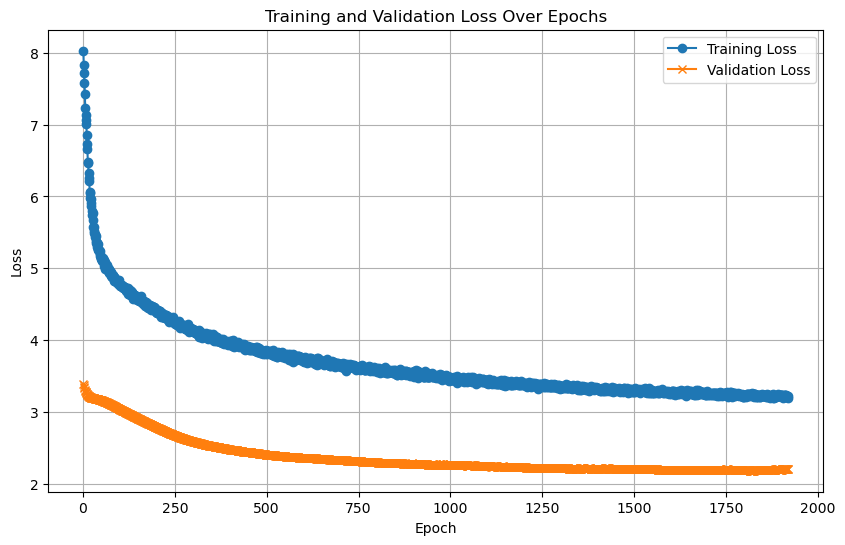

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/11], Loss: 4.9943

Test Loss: 4.9752


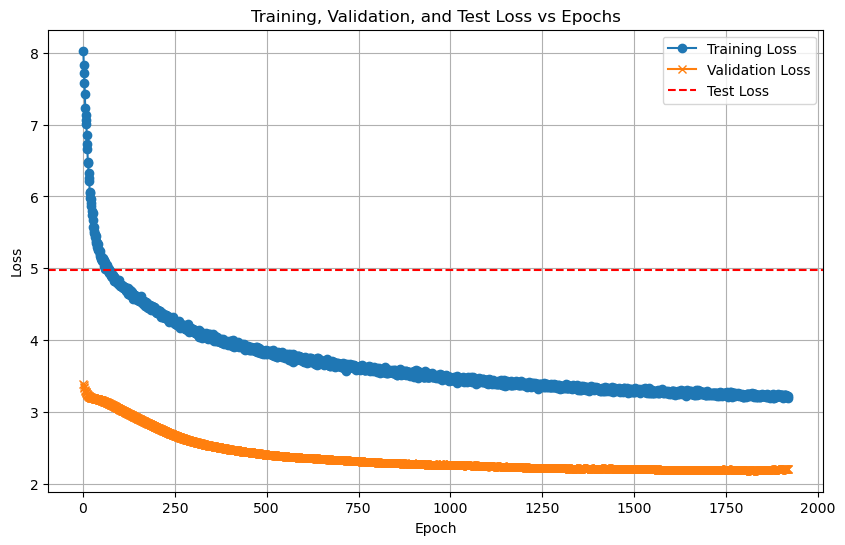

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/11 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 92.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5
           5       0.62      1.00      0.77         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      0.60      0.75         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8695  |  Val Loss: 2.7758
Validation loss improved from inf to 2.7758.
[Epoch 2/1000] Train Loss: 2.7609  |  Val Loss: 2.6847
Validation loss improved from 2.7758 to 2.6847.
[Epoch 3/1000] Train Loss: 2.6687  |  Val Loss: 2.6110
Validation loss improved from 2.6847 to 2.6110.
[Epoch 4/1000] Train Loss: 2.5923  |  Val Loss: 2.5523
Validation loss improved from 2.6110 to 2.5523.
[Epoch 5/1000] Train Loss: 2.5340  |  Val Loss: 2.5041
Validation loss improved from 2.5523 to 2.5041.
[Epoch 6/1000] Train Loss: 2.4839  |  Val Loss: 2.4618
Validation loss improved from 2.5041 to 2.4618.


[Epoch 7/1000] Train Loss: 2.4386  |  Val Loss: 2.4239
Validation loss improved from 2.4618 to 2.4239.
[Epoch 8/1000] Train Loss: 2.3981  |  Val Loss: 2.3897
Validation loss improved from 2.4239 to 2.3897.
[Epoch 9/1000] Train Loss: 2.3629  |  Val Loss: 2.3590
Validation loss improved from 2.3897 to 2.3590.


[Epoch 10/1000] Train Loss: 2.3304  |  Val Loss: 2.3305
Validation loss improved from 2.3590 to 2.3305.
[Epoch 11/1000] Train Loss: 2.3003  |  Val Loss: 2.3041
Validation loss improved from 2.3305 to 2.3041.
[Epoch 12/1000] Train Loss: 2.2719  |  Val Loss: 2.2780
Validation loss improved from 2.3041 to 2.2780.
[Epoch 13/1000] Train Loss: 2.2432  |  Val Loss: 2.2524
Validation loss improved from 2.2780 to 2.2524.


[Epoch 14/1000] Train Loss: 2.2156  |  Val Loss: 2.2271
Validation loss improved from 2.2524 to 2.2271.
[Epoch 15/1000] Train Loss: 2.1871  |  Val Loss: 2.2020
Validation loss improved from 2.2271 to 2.2020.
[Epoch 16/1000] Train Loss: 2.1594  |  Val Loss: 2.1761
Validation loss improved from 2.2020 to 2.1761.
[Epoch 17/1000] Train Loss: 2.1312  |  Val Loss: 2.1491
Validation loss improved from 2.1761 to 2.1491.
[Epoch 18/1000] Train Loss: 2.1014  |  Val Loss: 2.1216
Validation loss improved from 2.1491 to 2.1216.


[Epoch 19/1000] Train Loss: 2.0709  |  Val Loss: 2.0931
Validation loss improved from 2.1216 to 2.0931.
[Epoch 20/1000] Train Loss: 2.0394  |  Val Loss: 2.0636
Validation loss improved from 2.0931 to 2.0636.


[Epoch 21/1000] Train Loss: 2.0060  |  Val Loss: 2.0330
Validation loss improved from 2.0636 to 2.0330.
[Epoch 22/1000] Train Loss: 1.9719  |  Val Loss: 2.0000
Validation loss improved from 2.0330 to 2.0000.
[Epoch 23/1000] Train Loss: 1.9353  |  Val Loss: 1.9671
Validation loss improved from 2.0000 to 1.9671.
[Epoch 24/1000] Train Loss: 1.8988  |  Val Loss: 1.9330
Validation loss improved from 1.9671 to 1.9330.
[Epoch 25/1000] Train Loss: 1.8612  |  Val Loss: 1.8977
Validation loss improved from 1.9330 to 1.8977.


[Epoch 26/1000] Train Loss: 1.8233  |  Val Loss: 1.8612
Validation loss improved from 1.8977 to 1.8612.
[Epoch 27/1000] Train Loss: 1.7851  |  Val Loss: 1.8242
Validation loss improved from 1.8612 to 1.8242.
[Epoch 28/1000] Train Loss: 1.7459  |  Val Loss: 1.7877
Validation loss improved from 1.8242 to 1.7877.
[Epoch 29/1000] Train Loss: 1.7070  |  Val Loss: 1.7513
Validation loss improved from 1.7877 to 1.7513.
[Epoch 30/1000] Train Loss: 1.6688  |  Val Loss: 1.7146
Validation loss improved from 1.7513 to 1.7146.


[Epoch 31/1000] Train Loss: 1.6305  |  Val Loss: 1.6778
Validation loss improved from 1.7146 to 1.6778.
[Epoch 32/1000] Train Loss: 1.5924  |  Val Loss: 1.6412
Validation loss improved from 1.6778 to 1.6412.
[Epoch 33/1000] Train Loss: 1.5537  |  Val Loss: 1.6047
Validation loss improved from 1.6412 to 1.6047.
[Epoch 34/1000] Train Loss: 1.5153  |  Val Loss: 1.5688
Validation loss improved from 1.6047 to 1.5688.
[Epoch 35/1000] Train Loss: 1.4778  |  Val Loss: 1.5330
Validation loss improved from 1.5688 to 1.5330.
[Epoch 36/1000] Train Loss: 1.4405  |  Val Loss: 1.4985
Validation loss improved from 1.5330 to 1.4985.


[Epoch 37/1000] Train Loss: 1.4033  |  Val Loss: 1.4647
Validation loss improved from 1.4985 to 1.4647.
[Epoch 38/1000] Train Loss: 1.3674  |  Val Loss: 1.4311
Validation loss improved from 1.4647 to 1.4311.
[Epoch 39/1000] Train Loss: 1.3311  |  Val Loss: 1.3975
Validation loss improved from 1.4311 to 1.3975.
[Epoch 40/1000] Train Loss: 1.2960  |  Val Loss: 1.3639
Validation loss improved from 1.3975 to 1.3639.
[Epoch 41/1000] Train Loss: 1.2609  |  Val Loss: 1.3316
Validation loss improved from 1.3639 to 1.3316.


[Epoch 42/1000] Train Loss: 1.2264  |  Val Loss: 1.2995
Validation loss improved from 1.3316 to 1.2995.
[Epoch 43/1000] Train Loss: 1.1926  |  Val Loss: 1.2674
Validation loss improved from 1.2995 to 1.2674.
[Epoch 44/1000] Train Loss: 1.1593  |  Val Loss: 1.2374
Validation loss improved from 1.2674 to 1.2374.
[Epoch 45/1000] Train Loss: 1.1273  |  Val Loss: 1.2080
Validation loss improved from 1.2374 to 1.2080.
[Epoch 46/1000] Train Loss: 1.0961  |  Val Loss: 1.1787
Validation loss improved from 1.2080 to 1.1787.
[Epoch 47/1000] Train Loss: 1.0648  |  Val Loss: 1.1507
Validation loss improved from 1.1787 to 1.1507.
[Epoch 48/1000] Train Loss: 1.0347  |  Val Loss: 1.1235
Validation loss improved from 1.1507 to 1.1235.


[Epoch 49/1000] Train Loss: 1.0048  |  Val Loss: 1.0967
Validation loss improved from 1.1235 to 1.0967.
[Epoch 50/1000] Train Loss: 0.9755  |  Val Loss: 1.0708
Validation loss improved from 1.0967 to 1.0708.
[Epoch 51/1000] Train Loss: 0.9465  |  Val Loss: 1.0452
Validation loss improved from 1.0708 to 1.0452.
[Epoch 52/1000] Train Loss: 0.9184  |  Val Loss: 1.0205
Validation loss improved from 1.0452 to 1.0205.
[Epoch 53/1000] Train Loss: 0.8903  |  Val Loss: 0.9961
Validation loss improved from 1.0205 to 0.9961.


[Epoch 54/1000] Train Loss: 0.8627  |  Val Loss: 0.9718
Validation loss improved from 0.9961 to 0.9718.
[Epoch 55/1000] Train Loss: 0.8355  |  Val Loss: 0.9485
Validation loss improved from 0.9718 to 0.9485.
[Epoch 56/1000] Train Loss: 0.8095  |  Val Loss: 0.9245
Validation loss improved from 0.9485 to 0.9245.
[Epoch 57/1000] Train Loss: 0.7835  |  Val Loss: 0.9025
Validation loss improved from 0.9245 to 0.9025.
[Epoch 58/1000] Train Loss: 0.7586  |  Val Loss: 0.8814
Validation loss improved from 0.9025 to 0.8814.


[Epoch 59/1000] Train Loss: 0.7344  |  Val Loss: 0.8601
Validation loss improved from 0.8814 to 0.8601.
[Epoch 60/1000] Train Loss: 0.7109  |  Val Loss: 0.8397
Validation loss improved from 0.8601 to 0.8397.
[Epoch 61/1000] Train Loss: 0.6878  |  Val Loss: 0.8206
Validation loss improved from 0.8397 to 0.8206.
[Epoch 62/1000] Train Loss: 0.6648  |  Val Loss: 0.8009
Validation loss improved from 0.8206 to 0.8009.
[Epoch 63/1000] Train Loss: 0.6432  |  Val Loss: 0.7808
Validation loss improved from 0.8009 to 0.7808.
[Epoch 64/1000] Train Loss: 0.6222  |  Val Loss: 0.7630
Validation loss improved from 0.7808 to 0.7630.
[Epoch 65/1000] Train Loss: 0.6018  |  Val Loss: 0.7468
Validation loss improved from 0.7630 to 0.7468.


[Epoch 66/1000] Train Loss: 0.5815  |  Val Loss: 0.7299
Validation loss improved from 0.7468 to 0.7299.
[Epoch 67/1000] Train Loss: 0.5628  |  Val Loss: 0.7131
Validation loss improved from 0.7299 to 0.7131.
[Epoch 68/1000] Train Loss: 0.5441  |  Val Loss: 0.6977
Validation loss improved from 0.7131 to 0.6977.
[Epoch 69/1000] Train Loss: 0.5262  |  Val Loss: 0.6826
Validation loss improved from 0.6977 to 0.6826.
[Epoch 70/1000] Train Loss: 0.5094  |  Val Loss: 0.6687
Validation loss improved from 0.6826 to 0.6687.


[Epoch 71/1000] Train Loss: 0.4919  |  Val Loss: 0.6551
Validation loss improved from 0.6687 to 0.6551.
[Epoch 72/1000] Train Loss: 0.4761  |  Val Loss: 0.6418
Validation loss improved from 0.6551 to 0.6418.
[Epoch 73/1000] Train Loss: 0.4602  |  Val Loss: 0.6287
Validation loss improved from 0.6418 to 0.6287.
[Epoch 74/1000] Train Loss: 0.4452  |  Val Loss: 0.6167
Validation loss improved from 0.6287 to 0.6167.
[Epoch 75/1000] Train Loss: 0.4308  |  Val Loss: 0.6051
Validation loss improved from 0.6167 to 0.6051.
[Epoch 76/1000] Train Loss: 0.4167  |  Val Loss: 0.5925
Validation loss improved from 0.6051 to 0.5925.
[Epoch 77/1000] Train Loss: 0.4034  |  Val Loss: 0.5822
Validation loss improved from 0.5925 to 0.5822.


[Epoch 78/1000] Train Loss: 0.3907  |  Val Loss: 0.5725
Validation loss improved from 0.5822 to 0.5725.
[Epoch 79/1000] Train Loss: 0.3780  |  Val Loss: 0.5618
Validation loss improved from 0.5725 to 0.5618.
[Epoch 80/1000] Train Loss: 0.3658  |  Val Loss: 0.5508
Validation loss improved from 0.5618 to 0.5508.
[Epoch 81/1000] Train Loss: 0.3541  |  Val Loss: 0.5419
Validation loss improved from 0.5508 to 0.5419.
[Epoch 82/1000] Train Loss: 0.3432  |  Val Loss: 0.5332
Validation loss improved from 0.5419 to 0.5332.
[Epoch 83/1000] Train Loss: 0.3324  |  Val Loss: 0.5246
Validation loss improved from 0.5332 to 0.5246.


[Epoch 84/1000] Train Loss: 0.3217  |  Val Loss: 0.5163
Validation loss improved from 0.5246 to 0.5163.
[Epoch 85/1000] Train Loss: 0.3120  |  Val Loss: 0.5070
Validation loss improved from 0.5163 to 0.5070.
[Epoch 86/1000] Train Loss: 0.3018  |  Val Loss: 0.5003
Validation loss improved from 0.5070 to 0.5003.
[Epoch 87/1000] Train Loss: 0.2925  |  Val Loss: 0.4932
Validation loss improved from 0.5003 to 0.4932.
[Epoch 88/1000] Train Loss: 0.2834  |  Val Loss: 0.4859
Validation loss improved from 0.4932 to 0.4859.
[Epoch 89/1000] Train Loss: 0.2747  |  Val Loss: 0.4778
Validation loss improved from 0.4859 to 0.4778.
[Epoch 90/1000] Train Loss: 0.2659  |  Val Loss: 0.4701
Validation loss improved from 0.4778 to 0.4701.


[Epoch 91/1000] Train Loss: 0.2578  |  Val Loss: 0.4653
Validation loss improved from 0.4701 to 0.4653.
[Epoch 92/1000] Train Loss: 0.2497  |  Val Loss: 0.4576
Validation loss improved from 0.4653 to 0.4576.
[Epoch 93/1000] Train Loss: 0.2418  |  Val Loss: 0.4526
Validation loss improved from 0.4576 to 0.4526.
[Epoch 94/1000] Train Loss: 0.2344  |  Val Loss: 0.4461
Validation loss improved from 0.4526 to 0.4461.
[Epoch 95/1000] Train Loss: 0.2270  |  Val Loss: 0.4401
Validation loss improved from 0.4461 to 0.4401.


[Epoch 96/1000] Train Loss: 0.2200  |  Val Loss: 0.4359
Validation loss improved from 0.4401 to 0.4359.
[Epoch 97/1000] Train Loss: 0.2132  |  Val Loss: 0.4303
Validation loss improved from 0.4359 to 0.4303.
[Epoch 98/1000] Train Loss: 0.2065  |  Val Loss: 0.4259
Validation loss improved from 0.4303 to 0.4259.
[Epoch 99/1000] Train Loss: 0.2001  |  Val Loss: 0.4202
Validation loss improved from 0.4259 to 0.4202.
[Epoch 100/1000] Train Loss: 0.1940  |  Val Loss: 0.4173
Validation loss improved from 0.4202 to 0.4173.
[Epoch 101/1000] Train Loss: 0.1880  |  Val Loss: 0.4100
Validation loss improved from 0.4173 to 0.4100.


[Epoch 102/1000] Train Loss: 0.1823  |  Val Loss: 0.4061
Validation loss improved from 0.4100 to 0.4061.
[Epoch 103/1000] Train Loss: 0.1766  |  Val Loss: 0.4017
Validation loss improved from 0.4061 to 0.4017.
[Epoch 104/1000] Train Loss: 0.1711  |  Val Loss: 0.3979
Validation loss improved from 0.4017 to 0.3979.
[Epoch 105/1000] Train Loss: 0.1661  |  Val Loss: 0.3944
Validation loss improved from 0.3979 to 0.3944.


[Epoch 106/1000] Train Loss: 0.1610  |  Val Loss: 0.3904
Validation loss improved from 0.3944 to 0.3904.
[Epoch 107/1000] Train Loss: 0.1560  |  Val Loss: 0.3867
Validation loss improved from 0.3904 to 0.3867.
[Epoch 108/1000] Train Loss: 0.1513  |  Val Loss: 0.3834
Validation loss improved from 0.3867 to 0.3834.
[Epoch 109/1000] Train Loss: 0.1468  |  Val Loss: 0.3801
Validation loss improved from 0.3834 to 0.3801.
[Epoch 110/1000] Train Loss: 0.1423  |  Val Loss: 0.3766
Validation loss improved from 0.3801 to 0.3766.
[Epoch 111/1000] Train Loss: 0.1381  |  Val Loss: 0.3741
Validation loss improved from 0.3766 to 0.3741.
[Epoch 112/1000] Train Loss: 0.1339  |  Val Loss: 0.3702
Validation loss improved from 0.3741 to 0.3702.


[Epoch 113/1000] Train Loss: 0.1298  |  Val Loss: 0.3660
Validation loss improved from 0.3702 to 0.3660.
[Epoch 114/1000] Train Loss: 0.1260  |  Val Loss: 0.3651
Validation loss improved from 0.3660 to 0.3651.
[Epoch 115/1000] Train Loss: 0.1221  |  Val Loss: 0.3615
Validation loss improved from 0.3651 to 0.3615.
[Epoch 116/1000] Train Loss: 0.1186  |  Val Loss: 0.3582
Validation loss improved from 0.3615 to 0.3582.


[Epoch 117/1000] Train Loss: 0.1151  |  Val Loss: 0.3575
Validation loss improved from 0.3582 to 0.3575.
[Epoch 118/1000] Train Loss: 0.1116  |  Val Loss: 0.3537
Validation loss improved from 0.3575 to 0.3537.
[Epoch 119/1000] Train Loss: 0.1083  |  Val Loss: 0.3526
Validation loss improved from 0.3537 to 0.3526.
[Epoch 120/1000] Train Loss: 0.1051  |  Val Loss: 0.3493
Validation loss improved from 0.3526 to 0.3493.
[Epoch 121/1000] Train Loss: 0.1021  |  Val Loss: 0.3469
Validation loss improved from 0.3493 to 0.3469.
[Epoch 122/1000] Train Loss: 0.0991  |  Val Loss: 0.3453
Validation loss improved from 0.3469 to 0.3453.
[Epoch 123/1000] Train Loss: 0.0962  |  Val Loss: 0.3441
Validation loss improved from 0.3453 to 0.3441.
[Epoch 124/1000] Train Loss: 0.0936  |  Val Loss: 0.3422
Validation loss improved from 0.3441 to 0.3422.


[Epoch 125/1000] Train Loss: 0.0909  |  Val Loss: 0.3404
Validation loss improved from 0.3422 to 0.3404.
[Epoch 126/1000] Train Loss: 0.0884  |  Val Loss: 0.3368
Validation loss improved from 0.3404 to 0.3368.
[Epoch 127/1000] Train Loss: 0.0860  |  Val Loss: 0.3375
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 0.0836  |  Val Loss: 0.3347
Validation loss improved from 0.3368 to 0.3347.


[Epoch 129/1000] Train Loss: 0.0814  |  Val Loss: 0.3337
Validation loss improved from 0.3347 to 0.3337.
[Epoch 130/1000] Train Loss: 0.0792  |  Val Loss: 0.3313
Validation loss improved from 0.3337 to 0.3313.
[Epoch 131/1000] Train Loss: 0.0771  |  Val Loss: 0.3295
Validation loss improved from 0.3313 to 0.3295.
[Epoch 132/1000] Train Loss: 0.0751  |  Val Loss: 0.3290
Validation loss improved from 0.3295 to 0.3290.
[Epoch 133/1000] Train Loss: 0.0731  |  Val Loss: 0.3273
Validation loss improved from 0.3290 to 0.3273.
[Epoch 134/1000] Train Loss: 0.0712  |  Val Loss: 0.3263
Validation loss improved from 0.3273 to 0.3263.


[Epoch 135/1000] Train Loss: 0.0694  |  Val Loss: 0.3238
Validation loss improved from 0.3263 to 0.3238.
[Epoch 136/1000] Train Loss: 0.0677  |  Val Loss: 0.3241
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 137/1000] Train Loss: 0.0659  |  Val Loss: 0.3247
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 138/1000] Train Loss: 0.0643  |  Val Loss: 0.3233
Validation loss improved from 0.3238 to 0.3233.
[Epoch 139/1000] Train Loss: 0.0628  |  Val Loss: 0.3213
Validation loss improved from 0.3233 to 0.3213.


[Epoch 140/1000] Train Loss: 0.0612  |  Val Loss: 0.3204
Validation loss improved from 0.3213 to 0.3204.
[Epoch 141/1000] Train Loss: 0.0598  |  Val Loss: 0.3210
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 0.0583  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 143/1000] Train Loss: 0.0570  |  Val Loss: 0.3218
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 144/1000] Train Loss: 0.0557  |  Val Loss: 0.3231
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 145/1000] Train Loss: 0.0544  |  Val Loss: 0.3224
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 146/1000] Train Loss: 0.0531  |  Val Loss: 0.3199
Validation loss improved from 0.3204 to 0.3199.
[Epoch 147/1000] Train Loss: 0.0519  |  Val Loss: 0.3190
Validation loss improved from 0.3199 to 0.3190.
[Epoch 148/1000] Train Loss: 0.0509  |  Val Loss: 0.3167
Validation loss improved from 0.3190 to 0.3167.
[Epoch 149/1000] Train Loss: 0.0497  |  Val Loss: 0.3174
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 150/1000] Train Loss: 0.0486  |  Val Loss: 0.3155
Validation loss improved from 0.3167 to 0.3155.
[Epoch 151/1000] Train Loss: 0.0476  |  Val Loss: 0.3167
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 152/1000] Train Loss: 0.0465  |  Val Loss: 0.3178
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 153/1000] Train Loss: 0.0456  |  Val Loss: 0.3184
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 154/1000] Train Loss: 0.0446  |  Val Loss: 0.3162
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 155/1000] Train Loss: 0.0437  |  Val Loss: 0.3165
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 156/1000] Train Loss: 0.0428  |  Val Loss: 0.3159
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 157/1000] Train Loss: 0.0419  |  Val Loss: 0.3162
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 158/1000] Train Loss: 0.0411  |  Val Loss: 0.3161
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 159/1000] Train Loss: 0.0402  |  Val Loss: 0.3160
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 160/1000] Train Loss: 0.0395  |  Val Loss: 0.3136
Validation loss improved from 0.3155 to 0.3136.
[Epoch 161/1000] Train Loss: 0.0387  |  Val Loss: 0.3141
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 162/1000] Train Loss: 0.0379  |  Val Loss: 0.3155
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 163/1000] Train Loss: 0.0372  |  Val Loss: 0.3154
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 164/1000] Train Loss: 0.0365  |  Val Loss: 0.3158
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 165/1000] Train Loss: 0.0359  |  Val Loss: 0.3141
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 166/1000] Train Loss: 0.0351  |  Val Loss: 0.3142
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 167/1000] Train Loss: 0.0345  |  Val Loss: 0.3151
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 168/1000] Train Loss: 0.0339  |  Val Loss: 0.3172
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 169/1000] Train Loss: 0.0333  |  Val Loss: 0.3165
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 170/1000] Train Loss: 0.0327  |  Val Loss: 0.3169
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 171/1000] Train Loss: 0.0321  |  Val Loss: 0.3157
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 172/1000] Train Loss: 0.0315  |  Val Loss: 0.3152
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 173/1000] Train Loss: 0.0310  |  Val Loss: 0.3144
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 174/1000] Train Loss: 0.0305  |  Val Loss: 0.3159
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 175/1000] Train Loss: 0.0299  |  Val Loss: 0.3156
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 176/1000] Train Loss: 0.0294  |  Val Loss: 0.3157
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 177/1000] Train Loss: 0.0289  |  Val Loss: 0.3153
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 178/1000] Train Loss: 0.0284  |  Val Loss: 0.3151
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 179/1000] Train Loss: 0.0279  |  Val Loss: 0.3148
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 180/1000] Train Loss: 0.0275  |  Val Loss: 0.3138
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 181/1000] Train Loss: 0.0270  |  Val Loss: 0.3149
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 182/1000] Train Loss: 0.0265  |  Val Loss: 0.3150
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 183/1000] Train Loss: 0.0261  |  Val Loss: 0.3175
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 184/1000] Train Loss: 0.0257  |  Val Loss: 0.3176
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 185/1000] Train Loss: 0.0253  |  Val Loss: 0.3177
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 186/1000] Train Loss: 0.0249  |  Val Loss: 0.3173
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 187/1000] Train Loss: 0.0245  |  Val Loss: 0.3162
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 188/1000] Train Loss: 0.0241  |  Val Loss: 0.3159
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 189/1000] Train Loss: 0.0238  |  Val Loss: 0.3184
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 190/1000] Train Loss: 0.0234  |  Val Loss: 0.3184
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 191/1000] Train Loss: 0.0230  |  Val Loss: 0.3173
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 192/1000] Train Loss: 0.0227  |  Val Loss: 0.3154
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 193/1000] Train Loss: 0.0224  |  Val Loss: 0.3183
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 194/1000] Train Loss: 0.0220  |  Val Loss: 0.3185
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 195/1000] Train Loss: 0.0217  |  Val Loss: 0.3189
!! Validation loss did NOT improve !! Patience: 35/100


[Epoch 196/1000] Train Loss: 0.0213  |  Val Loss: 0.3197
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 197/1000] Train Loss: 0.0211  |  Val Loss: 0.3189
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 198/1000] Train Loss: 0.0207  |  Val Loss: 0.3200
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 199/1000] Train Loss: 0.0204  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 200/1000] Train Loss: 0.0201  |  Val Loss: 0.3215
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 201/1000] Train Loss: 0.0198  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 202/1000] Train Loss: 0.0196  |  Val Loss: 0.3224
!! Validation loss did NOT improve !! Patience: 42/100


[Epoch 203/1000] Train Loss: 0.0193  |  Val Loss: 0.3205
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 204/1000] Train Loss: 0.0190  |  Val Loss: 0.3201
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 205/1000] Train Loss: 0.0188  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 206/1000] Train Loss: 0.0185  |  Val Loss: 0.3222
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 207/1000] Train Loss: 0.0182  |  Val Loss: 0.3225
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 208/1000] Train Loss: 0.0180  |  Val Loss: 0.3214
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 209/1000] Train Loss: 0.0178  |  Val Loss: 0.3222
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 210/1000] Train Loss: 0.0175  |  Val Loss: 0.3233
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 211/1000] Train Loss: 0.0173  |  Val Loss: 0.3245
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 212/1000] Train Loss: 0.0170  |  Val Loss: 0.3244
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 213/1000] Train Loss: 0.0168  |  Val Loss: 0.3244
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 214/1000] Train Loss: 0.0166  |  Val Loss: 0.3255
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 215/1000] Train Loss: 0.0164  |  Val Loss: 0.3241
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 216/1000] Train Loss: 0.0162  |  Val Loss: 0.3247
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 217/1000] Train Loss: 0.0159  |  Val Loss: 0.3248
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 218/1000] Train Loss: 0.0157  |  Val Loss: 0.3251
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 219/1000] Train Loss: 0.0155  |  Val Loss: 0.3243
!! Validation loss did NOT improve !! Patience: 59/100


[Epoch 220/1000] Train Loss: 0.0154  |  Val Loss: 0.3248
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 221/1000] Train Loss: 0.0152  |  Val Loss: 0.3224
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 222/1000] Train Loss: 0.0150  |  Val Loss: 0.3246
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 223/1000] Train Loss: 0.0148  |  Val Loss: 0.3261
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 224/1000] Train Loss: 0.0146  |  Val Loss: 0.3263
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 225/1000] Train Loss: 0.0144  |  Val Loss: 0.3257
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 226/1000] Train Loss: 0.0142  |  Val Loss: 0.3263
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 227/1000] Train Loss: 0.0141  |  Val Loss: 0.3255
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 228/1000] Train Loss: 0.0139  |  Val Loss: 0.3260
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 229/1000] Train Loss: 0.0137  |  Val Loss: 0.3283
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 230/1000] Train Loss: 0.0135  |  Val Loss: 0.3283
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 231/1000] Train Loss: 0.0134  |  Val Loss: 0.3287
!! Validation loss did NOT improve !! Patience: 71/100


[Epoch 232/1000] Train Loss: 0.0132  |  Val Loss: 0.3280
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 233/1000] Train Loss: 0.0131  |  Val Loss: 0.3285
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 234/1000] Train Loss: 0.0129  |  Val Loss: 0.3289
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 235/1000] Train Loss: 0.0128  |  Val Loss: 0.3299
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 236/1000] Train Loss: 0.0126  |  Val Loss: 0.3282
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 237/1000] Train Loss: 0.0125  |  Val Loss: 0.3288
!! Validation loss did NOT improve !! Patience: 77/100


[Epoch 238/1000] Train Loss: 0.0123  |  Val Loss: 0.3314
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 239/1000] Train Loss: 0.0122  |  Val Loss: 0.3309
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 240/1000] Train Loss: 0.0120  |  Val Loss: 0.3329
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 241/1000] Train Loss: 0.0119  |  Val Loss: 0.3319
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 242/1000] Train Loss: 0.0118  |  Val Loss: 0.3316
!! Validation loss did NOT improve !! Patience: 82/100


[Epoch 243/1000] Train Loss: 0.0116  |  Val Loss: 0.3319
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 244/1000] Train Loss: 0.0115  |  Val Loss: 0.3330
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 245/1000] Train Loss: 0.0114  |  Val Loss: 0.3303
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 246/1000] Train Loss: 0.0112  |  Val Loss: 0.3323
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 247/1000] Train Loss: 0.0111  |  Val Loss: 0.3338
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 248/1000] Train Loss: 0.0110  |  Val Loss: 0.3330
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 249/1000] Train Loss: 0.0109  |  Val Loss: 0.3356
!! Validation loss did NOT improve !! Patience: 89/100


[Epoch 250/1000] Train Loss: 0.0107  |  Val Loss: 0.3351
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 251/1000] Train Loss: 0.0106  |  Val Loss: 0.3353
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 252/1000] Train Loss: 0.0105  |  Val Loss: 0.3351
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 253/1000] Train Loss: 0.0104  |  Val Loss: 0.3333
!! Validation loss did NOT improve !! Patience: 93/100


[Epoch 254/1000] Train Loss: 0.0103  |  Val Loss: 0.3333
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 255/1000] Train Loss: 0.0102  |  Val Loss: 0.3356
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 256/1000] Train Loss: 0.0101  |  Val Loss: 0.3358
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 257/1000] Train Loss: 0.0100  |  Val Loss: 0.3342
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 258/1000] Train Loss: 0.0099  |  Val Loss: 0.3346
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 259/1000] Train Loss: 0.0097  |  Val Loss: 0.3366
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 260/1000] Train Loss: 0.0097  |  Val Loss: 0.3413
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 260 !!
No improvement for 100 epochs.


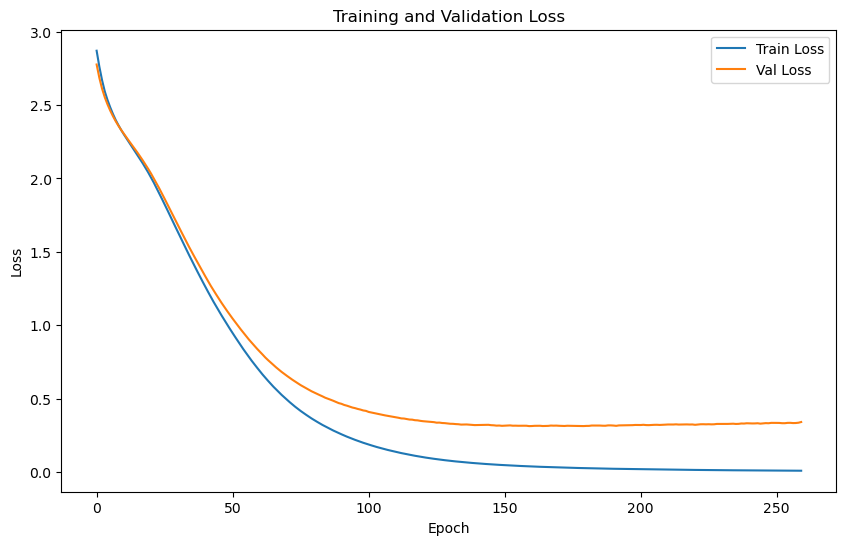

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4455 | Test Accuracy: 88.88%


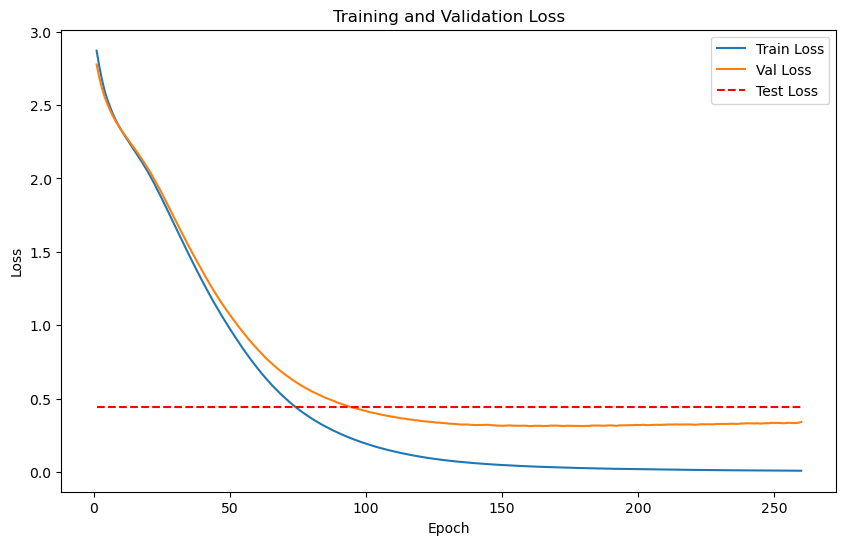

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 560 samples with 64 features each
LOG: Labels shape: (560,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2618 samples with 64 features each
LOG: Labels shape: (2618,)


Train embeddings shape: (560, 64), 
Train labels shape: (560,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2618, 64), 
Test labels shape: (2618,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4857
    Batch [2/2], Train Loss: 0.4862
LOG: Epoch [1/2000] - Validation


    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.0468
Epoch [1/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.2524

Validation loss improved from inf to 0.2524. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4844


    Batch [2/2], Train Loss: 0.4875
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.0468
Epoch [2/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.2521

Validation loss improved from 0.2524 to 0.2521. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4778
    Batch [2/2], Train Loss: 0.4837
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.0479
Epoch [3/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4821


    Batch [2/2], Train Loss: 0.4837
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.0470
Epoch [4/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.2522

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4816
    Batch [2/2], Train Loss: 0.4787
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.0469
Epoch [5/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4770


    Batch [2/2], Train Loss: 0.4786
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.0467
Epoch [6/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.2537

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4783
    Batch [2/2], Train Loss: 0.4756
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4621


    Batch [2/2], Val Loss: 0.0470
Epoch [7/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4740


    Batch [2/2], Train Loss: 0.4744
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.0476
Epoch [8/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 0.4750


    Batch [2/2], Train Loss: 0.4725
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.0496
Epoch [9/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4719
    Batch [2/2], Train Loss: 0.4715
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.0493
Epoch [10/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4692


    Batch [2/2], Train Loss: 0.4694
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.0496
Epoch [11/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.2552

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4712
    Batch [2/2], Train Loss: 0.4669
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.0493
Epoch [12/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4702


    Batch [2/2], Train Loss: 0.4685
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.0499
Epoch [13/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4682
    Batch [2/2], Train Loss: 0.4662
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.0511
Epoch [14/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4587


    Batch [2/2], Train Loss: 0.4632
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.0515
Epoch [15/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.2527

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4594
    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [16/2000] - Validation


    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.0526
Epoch [16/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.2519

Validation loss improved from 0.2521 to 0.2519. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4574


    Batch [2/2], Train Loss: 0.4633
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.0537
Epoch [17/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.2512

Validation loss improved from 0.2519 to 0.2512. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4649
    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4470


    Batch [2/2], Val Loss: 0.0540
Epoch [18/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.2505

Validation loss improved from 0.2512 to 0.2505. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4629


    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.0544
Epoch [19/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.2498

Validation loss improved from 0.2505 to 0.2498. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4590
    Batch [2/2], Train Loss: 0.4549
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.0550
Epoch [20/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.2491

Validation loss improved from 0.2498 to 0.2491. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4569
    Batch [2/2], Train Loss: 0.4545
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.0557
Epoch [21/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.2485

Validation loss improved from 0.2491 to 0.2485. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4561


    Batch [2/2], Train Loss: 0.4543
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4394
    Batch [2/2], Val Loss: 0.0561
Epoch [22/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.2477

Validation loss improved from 0.2485 to 0.2477. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4548
    Batch [2/2], Train Loss: 0.4547
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.0561
Epoch [23/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.2467

Validation loss improved from 0.2477 to 0.2467. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4559
    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.0561
Epoch [24/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.2456

Validation loss improved from 0.2467 to 0.2456. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.4526


    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.0561
Epoch [25/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.2444

Validation loss improved from 0.2456 to 0.2444. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4499
    Batch [2/2], Train Loss: 0.4503
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.0561
Epoch [26/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.2433

Validation loss improved from 0.2444 to 0.2433. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.4535


    Batch [2/2], Train Loss: 0.4530
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.0561
Epoch [27/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.2424

Validation loss improved from 0.2433 to 0.2424. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.0561
Epoch [28/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.2419

Validation loss improved from 0.2424 to 0.2419. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.4524


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.0562
Epoch [29/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.2416

Validation loss improved from 0.2419 to 0.2416. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4503
    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.0565
Epoch [30/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4482
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.0569
Epoch [31/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.2413

Validation loss improved from 0.2415 to 0.2413. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4444
    Batch [2/2], Train Loss: 0.4460
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.0573
Epoch [32/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.2409

Validation loss improved from 0.2413 to 0.2409. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.4444


    Batch [2/2], Train Loss: 0.4465
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0574
Epoch [33/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4395
    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.0576
Epoch [34/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.2404

Validation loss improved from 0.2408 to 0.2404. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.4440


    Batch [2/2], Train Loss: 0.4402
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.0578
Epoch [35/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.2397

Validation loss improved from 0.2404 to 0.2397. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4461
    Batch [2/2], Train Loss: 0.4432
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.0578
Epoch [36/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.2393

Validation loss improved from 0.2397 to 0.2393. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.4396


    Batch [2/2], Train Loss: 0.4384
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4203
    Batch [2/2], Val Loss: 0.0577
Epoch [37/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2390

Validation loss improved from 0.2393 to 0.2390. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4403
    Batch [2/2], Train Loss: 0.4416
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0575
Epoch [38/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.2386

Validation loss improved from 0.2390 to 0.2386. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.4368


    Batch [2/2], Train Loss: 0.4365
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0574
Epoch [39/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2380

Validation loss improved from 0.2386 to 0.2380. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4384
    Batch [2/2], Train Loss: 0.4315
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0573
Epoch [40/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.2376

Validation loss improved from 0.2380 to 0.2376. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.4332


    Batch [2/2], Train Loss: 0.4393
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.0575
Epoch [41/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2374

Validation loss improved from 0.2376 to 0.2374. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4316


    Batch [2/2], Train Loss: 0.4346
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.0579
Epoch [42/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2371

Validation loss improved from 0.2374 to 0.2371. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4352
    Batch [2/2], Train Loss: 0.4351
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.0585
Epoch [43/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2369

Validation loss improved from 0.2371 to 0.2369. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.4292


    Batch [2/2], Train Loss: 0.4300
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.0591
Epoch [44/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4350


    Batch [2/2], Train Loss: 0.4344
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.0595
Epoch [45/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2367

Validation loss improved from 0.2368 to 0.2367. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4282
    Batch [2/2], Train Loss: 0.4330
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.0598
Epoch [46/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2369

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.4298


    Batch [2/2], Train Loss: 0.4296
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.0603
Epoch [47/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2372

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4323
    Batch [2/2], Train Loss: 0.4312
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.0603
Epoch [48/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2374

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.4289


    Batch [2/2], Train Loss: 0.4312
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.0596
Epoch [49/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2372

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4268
    Batch [2/2], Train Loss: 0.4324
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.0586
Epoch [50/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2363

Validation loss improved from 0.2367 to 0.2363. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.4270


    Batch [2/2], Train Loss: 0.4339
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.0579
Epoch [51/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2358

Validation loss improved from 0.2363 to 0.2358. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.4297
    Batch [2/2], Train Loss: 0.4238
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0573
Epoch [52/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2350

Validation loss improved from 0.2358 to 0.2350. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.4241


    Batch [2/2], Train Loss: 0.4257
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0565
Epoch [53/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2336

Validation loss improved from 0.2350 to 0.2336. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4246
    Batch [2/2], Train Loss: 0.4269
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.0556
Epoch [54/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2325

Validation loss improved from 0.2336 to 0.2325. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4227


    Batch [2/2], Train Loss: 0.4235
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.0551
Epoch [55/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2317

Validation loss improved from 0.2325 to 0.2317. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.4303
    Batch [2/2], Train Loss: 0.4208
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.4071
    Batch [2/2], Val Loss: 0.0548
Epoch [56/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2310

Validation loss improved from 0.2317 to 0.2310. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.4260


    Batch [2/2], Train Loss: 0.4179
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.0540
Epoch [57/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2298

Validation loss improved from 0.2310 to 0.2298. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.4252
    Batch [2/2], Train Loss: 0.4175
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.0535
Epoch [58/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2288

Validation loss improved from 0.2298 to 0.2288. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.4176


    Batch [2/2], Train Loss: 0.4190
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.0528
Epoch [59/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2283

Validation loss improved from 0.2288 to 0.2283. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.4215
    Batch [2/2], Train Loss: 0.4180
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.0524
Epoch [60/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2279

Validation loss improved from 0.2283 to 0.2279. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.4186


    Batch [2/2], Train Loss: 0.4069
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.0519
Epoch [61/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2279

Validation loss improved from 0.2279 to 0.2279. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.4156
    Batch [2/2], Train Loss: 0.4182
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.0513
Epoch [62/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2278

Validation loss improved from 0.2279 to 0.2278. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.4171
    Batch [2/2], Train Loss: 0.4114
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.0507
Epoch [63/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2274

Validation loss improved from 0.2278 to 0.2274. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.4155


    Batch [2/2], Train Loss: 0.4203
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.0503
Epoch [64/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2267

Validation loss improved from 0.2274 to 0.2267. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.4098
    Batch [2/2], Train Loss: 0.4103
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4025


    Batch [2/2], Val Loss: 0.0499
Epoch [65/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2262

Validation loss improved from 0.2267 to 0.2262. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.4173


    Batch [2/2], Train Loss: 0.4127
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0496
Epoch [66/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2260

Validation loss improved from 0.2262 to 0.2260. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.4166
    Batch [2/2], Train Loss: 0.4133


LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.0493
Epoch [67/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2261

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.4117
    Batch [2/2], Train Loss: 0.4121
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.4030
    Batch [2/2], Val Loss: 0.0492
Epoch [68/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2261

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.4113


    Batch [2/2], Train Loss: 0.4110
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0490
Epoch [69/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2258

Validation loss improved from 0.2260 to 0.2258. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.4070
    Batch [2/2], Train Loss: 0.4058
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0486
Epoch [70/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2256

Validation loss improved from 0.2258 to 0.2256. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.4092


    Batch [2/2], Train Loss: 0.4086
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0481
Epoch [71/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2253

Validation loss improved from 0.2256 to 0.2253. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.4067
    Batch [2/2], Train Loss: 0.4023
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.4012
    Batch [2/2], Val Loss: 0.0477
Epoch [72/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2245

Validation loss improved from 0.2253 to 0.2245. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.4111


    Batch [2/2], Train Loss: 0.4031
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.0474
Epoch [73/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2236

Validation loss improved from 0.2245 to 0.2236. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.4091
    Batch [2/2], Train Loss: 0.4085
LOG: Epoch [74/2000] - Validation


    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.0472
Epoch [74/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2231

Validation loss improved from 0.2236 to 0.2231. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.4037


    Batch [2/2], Train Loss: 0.4036
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3961
    Batch [2/2], Val Loss: 0.0471
Epoch [75/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2216

Validation loss improved from 0.2231 to 0.2216. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.4032
    Batch [2/2], Train Loss: 0.4034
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.0473
Epoch [76/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2198

Validation loss improved from 0.2216 to 0.2198. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.4048


    Batch [2/2], Train Loss: 0.3984
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.0473
Epoch [77/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2183

Validation loss improved from 0.2198 to 0.2183. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.4056
    Batch [2/2], Train Loss: 0.4045
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.0472
Epoch [78/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2168

Validation loss improved from 0.2183 to 0.2168. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3986


    Batch [2/2], Train Loss: 0.4069
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0469
Epoch [79/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2159

Validation loss improved from 0.2168 to 0.2159. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.4003
    Batch [2/2], Train Loss: 0.4021
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.0467
Epoch [80/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2151

Validation loss improved from 0.2159 to 0.2151. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.4030


    Batch [2/2], Train Loss: 0.4020
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.0463
Epoch [81/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2145

Validation loss improved from 0.2151 to 0.2145. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3974
    Batch [2/2], Train Loss: 0.3960
LOG: Epoch [82/2000] - Validation


    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.0459
Epoch [82/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2142

Validation loss improved from 0.2145 to 0.2142. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3960


    Batch [2/2], Train Loss: 0.4034
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.0456
Epoch [83/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2140

Validation loss improved from 0.2142 to 0.2140. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3996


    Batch [2/2], Train Loss: 0.3990
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.0454
Epoch [84/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2143

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.3945
    Batch [2/2], Train Loss: 0.3917
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.0452
Epoch [85/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 0.3934


    Batch [2/2], Train Loss: 0.4013
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.0447
Epoch [86/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3913
    Batch [2/2], Train Loss: 0.3958
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.0444
Epoch [87/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3936


    Batch [2/2], Train Loss: 0.3950
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3845
    Batch [2/2], Val Loss: 0.0445
Epoch [88/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3917
    Batch [2/2], Train Loss: 0.3896
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.0445
Epoch [89/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2141

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3902


    Batch [2/2], Train Loss: 0.3996
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.0443
Epoch [90/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2132

Validation loss improved from 0.2140 to 0.2132. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3876
    Batch [2/2], Train Loss: 0.3947
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0445
Epoch [91/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2122

Validation loss improved from 0.2132 to 0.2122. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3903


    Batch [2/2], Train Loss: 0.3894
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.0447
Epoch [92/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2113

Validation loss improved from 0.2122 to 0.2113. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3883
    Batch [2/2], Train Loss: 0.3951
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.0447
Epoch [93/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2107

Validation loss improved from 0.2113 to 0.2107. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3876


    Batch [2/2], Train Loss: 0.3872
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3756
    Batch [2/2], Val Loss: 0.0444
Epoch [94/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2100

Validation loss improved from 0.2107 to 0.2100. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3915
    Batch [2/2], Train Loss: 0.3887
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.0439
Epoch [95/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2100

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3853


    Batch [2/2], Train Loss: 0.3868
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.0429
Epoch [96/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2103

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3848
    Batch [2/2], Train Loss: 0.3865
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.3791
    Batch [2/2], Val Loss: 0.0422
Epoch [97/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2106

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3833


    Batch [2/2], Train Loss: 0.3800
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3781
    Batch [2/2], Val Loss: 0.0419
Epoch [98/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2100

Validation loss improved from 0.2100 to 0.2100. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3839
    Batch [2/2], Train Loss: 0.3868
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.0418
Epoch [99/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2091

Validation loss improved from 0.2100 to 0.2091. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3881


    Batch [2/2], Train Loss: 0.3853
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.0421
Epoch [100/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2087

Validation loss improved from 0.2091 to 0.2087. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3818


    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.0424
Epoch [101/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2086

Validation loss improved from 0.2087 to 0.2086. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3831
    Batch [2/2], Train Loss: 0.3794
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.3735
    Batch [2/2], Val Loss: 0.0424
Epoch [102/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2079

Validation loss improved from 0.2086 to 0.2079. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.3770


    Batch [2/2], Train Loss: 0.3833
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3724
    Batch [2/2], Val Loss: 0.0423
Epoch [103/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2073

Validation loss improved from 0.2079 to 0.2073. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3768
    Batch [2/2], Train Loss: 0.3793
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.0421
Epoch [104/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2068

Validation loss improved from 0.2073 to 0.2068. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3835


    Batch [2/2], Train Loss: 0.3816
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.0420
Epoch [105/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2061

Validation loss improved from 0.2068 to 0.2061. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3772
    Batch [2/2], Train Loss: 0.3783
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.3692
    Batch [2/2], Val Loss: 0.0416
Epoch [106/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2054

Validation loss improved from 0.2061 to 0.2054. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3723
    Batch [2/2], Train Loss: 0.3755
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.0412
Epoch [107/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2049

Validation loss improved from 0.2054 to 0.2049. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3805


    Batch [2/2], Train Loss: 0.3768
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.0408
Epoch [108/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2047

Validation loss improved from 0.2049 to 0.2047. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3793
    Batch [2/2], Train Loss: 0.3715
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.3672
    Batch [2/2], Val Loss: 0.0403
Epoch [109/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2037

Validation loss improved from 0.2047 to 0.2037. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3720


    Batch [2/2], Train Loss: 0.3734
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.0400
Epoch [110/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2033

Validation loss improved from 0.2037 to 0.2033. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3770
    Batch [2/2], Train Loss: 0.3673
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.0399
Epoch [111/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2030

Validation loss improved from 0.2033 to 0.2030. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.3704


    Batch [2/2], Train Loss: 0.3805
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.0397
Epoch [112/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2027

Validation loss improved from 0.2030 to 0.2027. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.3722


    Batch [2/2], Train Loss: 0.3671
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0399
Epoch [113/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2025

Validation loss improved from 0.2027 to 0.2025. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.3704
    Batch [2/2], Train Loss: 0.3786
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0405
Epoch [114/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2019

Validation loss improved from 0.2025 to 0.2019. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.3701


    Batch [2/2], Train Loss: 0.3745
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0412
Epoch [115/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2010

Validation loss improved from 0.2019 to 0.2010. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3750
    Batch [2/2], Train Loss: 0.3722
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.0417
Epoch [116/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2005

Validation loss improved from 0.2010 to 0.2005. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.3723


    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.0419
Epoch [117/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2007

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3698
    Batch [2/2], Train Loss: 0.3631
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.3590
    Batch [2/2], Val Loss: 0.0418
Epoch [118/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2004

Validation loss improved from 0.2005 to 0.2004. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.3708


    Batch [2/2], Train Loss: 0.3757
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3567
    Batch [2/2], Val Loss: 0.0414
Epoch [119/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.1990

Validation loss improved from 0.2004 to 0.1990. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3702
    Batch [2/2], Train Loss: 0.3652
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.3555
    Batch [2/2], Val Loss: 0.0412
Epoch [120/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.1984

Validation loss improved from 0.1990 to 0.1984. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.3691


    Batch [2/2], Train Loss: 0.3595
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.3554
    Batch [2/2], Val Loss: 0.0412
Epoch [121/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.1983

Validation loss improved from 0.1984 to 0.1983. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3642
    Batch [2/2], Train Loss: 0.3608
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.3556
    Batch [2/2], Val Loss: 0.0418
Epoch [122/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.1987

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.3728


    Batch [2/2], Train Loss: 0.3630
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.0422
Epoch [123/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.1990

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3615
    Batch [2/2], Train Loss: 0.3599
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.0424
Epoch [124/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.1992

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.3653


    Batch [2/2], Train Loss: 0.3563
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.0425
Epoch [125/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.1993

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3512
    Batch [2/2], Train Loss: 0.3461
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.0428
Epoch [126/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.1993

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3626


    Batch [2/2], Train Loss: 0.3588
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.0431
Epoch [127/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.1995

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3670
    Batch [2/2], Train Loss: 0.3570
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.3569
    Batch [2/2], Val Loss: 0.0434
Epoch [128/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2002

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.3697


    Batch [2/2], Train Loss: 0.3670
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.0428
Epoch [129/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2008

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3555
    Batch [2/2], Train Loss: 0.3556
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0425
Epoch [130/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2015

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.3529


    Batch [2/2], Train Loss: 0.3595
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.0419
Epoch [131/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2018

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3567
    Batch [2/2], Train Loss: 0.3610
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0412
Epoch [132/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2018

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.3639


    Batch [2/2], Train Loss: 0.3521
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0410
Epoch [133/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2012

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3566
    Batch [2/2], Train Loss: 0.3571
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0406
Epoch [134/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2004

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.3576


    Batch [2/2], Train Loss: 0.3581
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.0403
Epoch [135/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.1991

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3519
    Batch [2/2], Train Loss: 0.3531
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.3564
    Batch [2/2], Val Loss: 0.0401
Epoch [136/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.1982

Validation loss improved from 0.1983 to 0.1982. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.3532


    Batch [2/2], Train Loss: 0.3558
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.0400
Epoch [137/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.1970

Validation loss improved from 0.1982 to 0.1970. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3497
    Batch [2/2], Train Loss: 0.3570
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.3512
    Batch [2/2], Val Loss: 0.0400
Epoch [138/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.1956

Validation loss improved from 0.1970 to 0.1956. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.3467


    Batch [2/2], Train Loss: 0.3530
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3509
    Batch [2/2], Val Loss: 0.0397
Epoch [139/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.1953

Validation loss improved from 0.1956 to 0.1953. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.3473
    Batch [2/2], Train Loss: 0.3477
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.3509
    Batch [2/2], Val Loss: 0.0396
Epoch [140/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.1953

Validation loss improved from 0.1953 to 0.1953. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.3413


    Batch [2/2], Train Loss: 0.3512
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.0399
Epoch [141/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.1953

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3503
    Batch [2/2], Train Loss: 0.3467
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.3503
    Batch [2/2], Val Loss: 0.0402
Epoch [142/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.1953

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3394


    Batch [2/2], Train Loss: 0.3498
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3497
    Batch [2/2], Val Loss: 0.0404
Epoch [143/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.1950

Validation loss improved from 0.1953 to 0.1950. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3515
    Batch [2/2], Train Loss: 0.3428
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.3501
    Batch [2/2], Val Loss: 0.0403
Epoch [144/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.1952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.3477


    Batch [2/2], Train Loss: 0.3465
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.0403
Epoch [145/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.1943

Validation loss improved from 0.1950 to 0.1943. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3488
    Batch [2/2], Train Loss: 0.3400
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.0399
Epoch [146/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.1940

Validation loss improved from 0.1943 to 0.1940. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.3413


    Batch [2/2], Train Loss: 0.3384
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.0397
Epoch [147/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.1935

Validation loss improved from 0.1940 to 0.1935. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.3444
    Batch [2/2], Train Loss: 0.3504
LOG: Epoch [148/2000] - Validation


    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.0391
Epoch [148/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.1928

Validation loss improved from 0.1935 to 0.1928. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.3420


    Batch [2/2], Train Loss: 0.3432
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.0387
Epoch [149/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.1931

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.3333


    Batch [2/2], Train Loss: 0.3351
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.3498
    Batch [2/2], Val Loss: 0.0390
Epoch [150/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.1944

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3533
    Batch [2/2], Train Loss: 0.3478
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.0393
Epoch [151/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.1957

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3504


    Batch [2/2], Train Loss: 0.3400
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.0398
Epoch [152/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.1970

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3454
    Batch [2/2], Train Loss: 0.3400
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.3543
    Batch [2/2], Val Loss: 0.0404
Epoch [153/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.1974

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.3468


    Batch [2/2], Train Loss: 0.3402
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.3523
    Batch [2/2], Val Loss: 0.0409
Epoch [154/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.1966

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.3458
    Batch [2/2], Train Loss: 0.3365
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.3493
    Batch [2/2], Val Loss: 0.0411
Epoch [155/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.1952

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.3349


    Batch [2/2], Train Loss: 0.3441
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.3471
    Batch [2/2], Val Loss: 0.0408
Epoch [156/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.1940

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.3431


    Batch [2/2], Train Loss: 0.3428
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3450
    Batch [2/2], Val Loss: 0.0403
Epoch [157/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.1927

Validation loss improved from 0.1928 to 0.1927. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3331
    Batch [2/2], Train Loss: 0.3298
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.3434
    Batch [2/2], Val Loss: 0.0402
Epoch [158/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.1918

Validation loss improved from 0.1927 to 0.1918. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.3423
    Batch [2/2], Train Loss: 0.3317
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.0396
Epoch [159/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.1905

Validation loss improved from 0.1918 to 0.1905. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.3360


    Batch [2/2], Train Loss: 0.3316
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.0392
Epoch [160/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.1898

Validation loss improved from 0.1905 to 0.1898. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.3405


    Batch [2/2], Train Loss: 0.3279
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3402
    Batch [2/2], Val Loss: 0.0390
Epoch [161/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.1896

Validation loss improved from 0.1898 to 0.1896. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3357
    Batch [2/2], Train Loss: 0.3304
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.0388
Epoch [162/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.1888

Validation loss improved from 0.1896 to 0.1888. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.3316


    Batch [2/2], Train Loss: 0.3330
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.0388
Epoch [163/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.1883

Validation loss improved from 0.1888 to 0.1883. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.3250
    Batch [2/2], Train Loss: 0.3317
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.0390
Epoch [164/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.1882

Validation loss improved from 0.1883 to 0.1882. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.3319


    Batch [2/2], Train Loss: 0.3364
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3369
    Batch [2/2], Val Loss: 0.0391
Epoch [165/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.1880

Validation loss improved from 0.1882 to 0.1880. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.3283
    Batch [2/2], Train Loss: 0.3328
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.3376
    Batch [2/2], Val Loss: 0.0390
Epoch [166/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.1883

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.3315


    Batch [2/2], Train Loss: 0.3227
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.0382
Epoch [167/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.1883

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.3345
    Batch [2/2], Train Loss: 0.3360
LOG: Epoch [168/2000] - Validation


    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.0377
Epoch [168/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.1883

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.3366


    Batch [2/2], Train Loss: 0.3229
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3397
    Batch [2/2], Val Loss: 0.0374
Epoch [169/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.3343
    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.3388
    Batch [2/2], Val Loss: 0.0371
Epoch [170/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.1879

Validation loss improved from 0.1880 to 0.1879. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.3256


    Batch [2/2], Train Loss: 0.3308
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3372
    Batch [2/2], Val Loss: 0.0366
Epoch [171/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.1869

Validation loss improved from 0.1879 to 0.1869. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.3307
    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [172/2000] - Validation


    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.0363
Epoch [172/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.1863

Validation loss improved from 0.1869 to 0.1863. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.3270


    Batch [2/2], Train Loss: 0.3231
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3373
    Batch [2/2], Val Loss: 0.0360
Epoch [173/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.1867

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.3336
    Batch [2/2], Train Loss: 0.3208
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.3378
    Batch [2/2], Val Loss: 0.0360
Epoch [174/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.1869

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.3351


    Batch [2/2], Train Loss: 0.3370
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.0363
Epoch [175/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.1872

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.3181


    Batch [2/2], Train Loss: 0.3190
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.0367
Epoch [176/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.1871

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.3302
    Batch [2/2], Train Loss: 0.3359
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.3355
    Batch [2/2], Val Loss: 0.0372
Epoch [177/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.1864

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.3209


    Batch [2/2], Train Loss: 0.3187
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.0375
Epoch [178/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.1859

Validation loss improved from 0.1863 to 0.1859. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.3291


    Batch [2/2], Train Loss: 0.3213
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.3332
    Batch [2/2], Val Loss: 0.0379
Epoch [179/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.1855

Validation loss improved from 0.1859 to 0.1855. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.3267
    Batch [2/2], Train Loss: 0.3265
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.3317
    Batch [2/2], Val Loss: 0.0382
Epoch [180/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.1849

Validation loss improved from 0.1855 to 0.1849. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.3096


    Batch [2/2], Train Loss: 0.3172
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.3305
    Batch [2/2], Val Loss: 0.0383
Epoch [181/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.1844

Validation loss improved from 0.1849 to 0.1844. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.3234
    Batch [2/2], Train Loss: 0.3199
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.3301
    Batch [2/2], Val Loss: 0.0386
Epoch [182/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.1844

Validation loss improved from 0.1844 to 0.1844. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.3207


    Batch [2/2], Train Loss: 0.3245
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3311
    Batch [2/2], Val Loss: 0.0387
Epoch [183/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.3243
    Batch [2/2], Train Loss: 0.3140
LOG: Epoch [184/2000] - Validation


    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.0386
Epoch [184/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.1866

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.3124


    Batch [2/2], Train Loss: 0.3201
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.0384
Epoch [185/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.1886

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.3151


    Batch [2/2], Train Loss: 0.3163
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3413
    Batch [2/2], Val Loss: 0.0380
Epoch [186/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.1897

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.3175
    Batch [2/2], Train Loss: 0.3146
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.0379
Epoch [187/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.1891

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.3247


    Batch [2/2], Train Loss: 0.3142
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.0377
Epoch [188/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.1876

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.3139
    Batch [2/2], Train Loss: 0.3169
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.3346
    Batch [2/2], Val Loss: 0.0375
Epoch [189/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.1861

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.3052


    Batch [2/2], Train Loss: 0.3151
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3326
    Batch [2/2], Val Loss: 0.0374
Epoch [190/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.1850

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.3253
    Batch [2/2], Train Loss: 0.3177
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3312
    Batch [2/2], Val Loss: 0.0371
Epoch [191/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.1842

Validation loss improved from 0.1844 to 0.1842. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.3160


    Batch [2/2], Train Loss: 0.3184
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3303
    Batch [2/2], Val Loss: 0.0365
Epoch [192/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.1834

Validation loss improved from 0.1842 to 0.1834. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.3155
    Batch [2/2], Train Loss: 0.3104
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.3300
    Batch [2/2], Val Loss: 0.0358
Epoch [193/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.1829

Validation loss improved from 0.1834 to 0.1829. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.3126


    Batch [2/2], Train Loss: 0.3154
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3295
    Batch [2/2], Val Loss: 0.0358
Epoch [194/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.1827

Validation loss improved from 0.1829 to 0.1827. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.3233
    Batch [2/2], Train Loss: 0.3137
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3284
    Batch [2/2], Val Loss: 0.0357
Epoch [195/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.1820

Validation loss improved from 0.1827 to 0.1820. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.3076
    Batch [2/2], Train Loss: 0.3045
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.3276
    Batch [2/2], Val Loss: 0.0357
Epoch [196/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.1817

Validation loss improved from 0.1820 to 0.1817. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.3120
    Batch [2/2], Train Loss: 0.3129
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.3282
    Batch [2/2], Val Loss: 0.0356
Epoch [197/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.3050


    Batch [2/2], Train Loss: 0.3165
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3286
    Batch [2/2], Val Loss: 0.0353
Epoch [198/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.3065
    Batch [2/2], Train Loss: 0.3070
LOG: Epoch [199/2000] - Validation


    Batch [1/2], Val Loss: 0.3291
    Batch [2/2], Val Loss: 0.0351
Epoch [199/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.1821

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.3010


    Batch [2/2], Train Loss: 0.3035
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3284
    Batch [2/2], Val Loss: 0.0349
Epoch [200/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.1817

Validation loss improved from 0.1817 to 0.1817. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.3076
    Batch [2/2], Train Loss: 0.3016
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.3283
    Batch [2/2], Val Loss: 0.0348
Epoch [201/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.1815

Validation loss improved from 0.1817 to 0.1815. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.3025


    Batch [2/2], Train Loss: 0.3152
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3249
    Batch [2/2], Val Loss: 0.0345
Epoch [202/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.1797

Validation loss improved from 0.1815 to 0.1797. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.3108
    Batch [2/2], Train Loss: 0.3104
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.3225
    Batch [2/2], Val Loss: 0.0342
Epoch [203/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.1784

Validation loss improved from 0.1797 to 0.1784. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.3101


    Batch [2/2], Train Loss: 0.3078
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3201
    Batch [2/2], Val Loss: 0.0340
Epoch [204/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.1771

Validation loss improved from 0.1784 to 0.1771. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.3046
    Batch [2/2], Train Loss: 0.3003
LOG: Epoch [205/2000] - Validation


    Batch [1/2], Val Loss: 0.3201
    Batch [2/2], Val Loss: 0.0338
Epoch [205/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.1770

Validation loss improved from 0.1771 to 0.1770. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.3063


    Batch [2/2], Train Loss: 0.3025
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.0338
Epoch [206/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.1765

Validation loss improved from 0.1770 to 0.1765. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.3098
    Batch [2/2], Train Loss: 0.3011
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.0339
Epoch [207/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.3082


    Batch [2/2], Train Loss: 0.3000
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3199
    Batch [2/2], Val Loss: 0.0342
Epoch [208/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.1770

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.2960
    Batch [2/2], Train Loss: 0.3110
LOG: Epoch [209/2000] - Validation


    Batch [1/2], Val Loss: 0.3204
    Batch [2/2], Val Loss: 0.0349
Epoch [209/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.3040


    Batch [2/2], Train Loss: 0.3068
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3223
    Batch [2/2], Val Loss: 0.0355
Epoch [210/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.3022
    Batch [2/2], Train Loss: 0.3082
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.3228
    Batch [2/2], Val Loss: 0.0355
Epoch [211/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.3059


    Batch [2/2], Train Loss: 0.2936
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3210
    Batch [2/2], Val Loss: 0.0348
Epoch [212/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.1779

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.3018
    Batch [2/2], Train Loss: 0.3043
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.3206
    Batch [2/2], Val Loss: 0.0343
Epoch [213/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.3023


    Batch [2/2], Train Loss: 0.3054
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.0336
Epoch [214/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.1765

Validation loss improved from 0.1765 to 0.1765. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.2943
    Batch [2/2], Train Loss: 0.3047
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.3170
    Batch [2/2], Val Loss: 0.0333
Epoch [215/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.1751

Validation loss improved from 0.1765 to 0.1751. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.3064
    Batch [2/2], Train Loss: 0.2967
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.3161
    Batch [2/2], Val Loss: 0.0329
Epoch [216/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.1745

Validation loss improved from 0.1751 to 0.1745. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.3019


    Batch [2/2], Train Loss: 0.2860
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.0327
Epoch [217/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.1738

Validation loss improved from 0.1745 to 0.1738. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.3011
    Batch [2/2], Train Loss: 0.2904
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.0328
Epoch [218/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.1739

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.3005


    Batch [2/2], Train Loss: 0.2970
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3163
    Batch [2/2], Val Loss: 0.0332
Epoch [219/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.1748

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.3046
    Batch [2/2], Train Loss: 0.3000
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.0337
Epoch [220/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.2981


    Batch [2/2], Train Loss: 0.2982
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3162
    Batch [2/2], Val Loss: 0.0340
Epoch [221/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.1751

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2951
    Batch [2/2], Train Loss: 0.2971
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.0344
Epoch [222/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.1743

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.3018


    Batch [2/2], Train Loss: 0.2991
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3128
    Batch [2/2], Val Loss: 0.0348
Epoch [223/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.1738

Validation loss improved from 0.1738 to 0.1738. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2924


    Batch [2/2], Train Loss: 0.3052
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3120
    Batch [2/2], Val Loss: 0.0350
Epoch [224/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.1735

Validation loss improved from 0.1738 to 0.1735. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2884
    Batch [2/2], Train Loss: 0.2885
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.0346
Epoch [225/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.1730

Validation loss improved from 0.1735 to 0.1730. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2958


    Batch [2/2], Train Loss: 0.2991
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3090
    Batch [2/2], Val Loss: 0.0343
Epoch [226/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.1716

Validation loss improved from 0.1730 to 0.1716. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2840
    Batch [2/2], Train Loss: 0.2919
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.3072
    Batch [2/2], Val Loss: 0.0338
Epoch [227/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.1705

Validation loss improved from 0.1716 to 0.1705. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.2938


    Batch [2/2], Train Loss: 0.2958
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3053
    Batch [2/2], Val Loss: 0.0336
Epoch [228/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.1694

Validation loss improved from 0.1705 to 0.1694. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2877
    Batch [2/2], Train Loss: 0.2988
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3035


    Batch [2/2], Val Loss: 0.0333
Epoch [229/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.1684

Validation loss improved from 0.1694 to 0.1684. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.2848


    Batch [2/2], Train Loss: 0.2949
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3028
    Batch [2/2], Val Loss: 0.0330
Epoch [230/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.1679

Validation loss improved from 0.1684 to 0.1679. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2914
    Batch [2/2], Train Loss: 0.2937
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.0327
Epoch [231/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.1673

Validation loss improved from 0.1679 to 0.1673. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.2853


    Batch [2/2], Train Loss: 0.2878
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3030
    Batch [2/2], Val Loss: 0.0326
Epoch [232/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.1678

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2849
    Batch [2/2], Train Loss: 0.2893
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.3030
    Batch [2/2], Val Loss: 0.0329
Epoch [233/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.1680

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.2855


    Batch [2/2], Train Loss: 0.2885
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3030
    Batch [2/2], Val Loss: 0.0334
Epoch [234/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2922
    Batch [2/2], Train Loss: 0.2968
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.3039
    Batch [2/2], Val Loss: 0.0341
Epoch [235/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.1690

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2889


    Batch [2/2], Train Loss: 0.2951
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3057
    Batch [2/2], Val Loss: 0.0347
Epoch [236/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2794
    Batch [2/2], Train Loss: 0.2910
LOG: Epoch [237/2000] - Validation


    Batch [1/2], Val Loss: 0.3064
    Batch [2/2], Val Loss: 0.0355
Epoch [237/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.1709

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.2804


    Batch [2/2], Train Loss: 0.2881
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.0360
Epoch [238/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2900
    Batch [2/2], Train Loss: 0.2892
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3105
    Batch [2/2], Val Loss: 0.0352
Epoch [239/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.1729

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2803
    Batch [2/2], Train Loss: 0.2901
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3106


    Batch [2/2], Val Loss: 0.0342
Epoch [240/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2871
    Batch [2/2], Train Loss: 0.2916
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.0336
Epoch [241/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.2818


    Batch [2/2], Train Loss: 0.2895
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.0331
Epoch [242/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.2750
    Batch [2/2], Train Loss: 0.2873
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.3099
    Batch [2/2], Val Loss: 0.0326
Epoch [243/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.2897


    Batch [2/2], Train Loss: 0.2990
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.0324
Epoch [244/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.1708

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2823
    Batch [2/2], Train Loss: 0.2829
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.3097
    Batch [2/2], Val Loss: 0.0327
Epoch [245/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2821


    Batch [2/2], Train Loss: 0.2771
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3096
    Batch [2/2], Val Loss: 0.0330
Epoch [246/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2870
    Batch [2/2], Train Loss: 0.2893
LOG: Epoch [247/2000] - Validation


    Batch [1/2], Val Loss: 0.3078
    Batch [2/2], Val Loss: 0.0331
Epoch [247/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.1704

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2838


    Batch [2/2], Train Loss: 0.2865
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3065
    Batch [2/2], Val Loss: 0.0330
Epoch [248/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.1698

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2796
    Batch [2/2], Train Loss: 0.2911
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.0329
Epoch [249/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.1693

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.2886


    Batch [2/2], Train Loss: 0.2849
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3063
    Batch [2/2], Val Loss: 0.0325
Epoch [250/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.1694

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2958
    Batch [2/2], Train Loss: 0.2853
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.3070
    Batch [2/2], Val Loss: 0.0320
Epoch [251/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.1695

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.2832


    Batch [2/2], Train Loss: 0.2760
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3077
    Batch [2/2], Val Loss: 0.0315
Epoch [252/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.1696

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2836
    Batch [2/2], Train Loss: 0.2807
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.0313
Epoch [253/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.1698

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.2798


    Batch [2/2], Train Loss: 0.2897
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3090
    Batch [2/2], Val Loss: 0.0318
Epoch [254/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.1704

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2845
    Batch [2/2], Train Loss: 0.2803
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.3062
    Batch [2/2], Val Loss: 0.0318
Epoch [255/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.1690

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.2722


    Batch [2/2], Train Loss: 0.2772
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3025
    Batch [2/2], Val Loss: 0.0317
Epoch [256/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.1671

Validation loss improved from 0.1673 to 0.1671. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2728
    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3000
    Batch [2/2], Val Loss: 0.0314
Epoch [257/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.1657

Validation loss improved from 0.1671 to 0.1657. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2839
    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.2978
    Batch [2/2], Val Loss: 0.0315
Epoch [258/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.1646

Validation loss improved from 0.1657 to 0.1646. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.2841


    Batch [2/2], Train Loss: 0.2771
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2961
    Batch [2/2], Val Loss: 0.0320
Epoch [259/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.1641

Validation loss improved from 0.1646 to 0.1641. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2872
    Batch [2/2], Train Loss: 0.2774
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2970


    Batch [2/2], Val Loss: 0.0322
Epoch [260/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.1646

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2829


    Batch [2/2], Train Loss: 0.2716
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.0323
Epoch [261/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2783
    Batch [2/2], Train Loss: 0.2703
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.0321
Epoch [262/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.1642

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2820


    Batch [2/2], Train Loss: 0.2714
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.0317
Epoch [263/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.1635

Validation loss improved from 0.1641 to 0.1635. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2790
    Batch [2/2], Train Loss: 0.2779
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.2954
    Batch [2/2], Val Loss: 0.0312
Epoch [264/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.1633

Validation loss improved from 0.1635 to 0.1633. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2748


    Batch [2/2], Train Loss: 0.2680
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.0309
Epoch [265/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.1635

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2701
    Batch [2/2], Train Loss: 0.2730
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.2957
    Batch [2/2], Val Loss: 0.0307
Epoch [266/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.1632

Validation loss improved from 0.1633 to 0.1632. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.2797


    Batch [2/2], Train Loss: 0.2729
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.0303
Epoch [267/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.1635

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.2812
    Batch [2/2], Train Loss: 0.2786
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.2971
    Batch [2/2], Val Loss: 0.0300
Epoch [268/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.1635

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2746


    Batch [2/2], Train Loss: 0.2735
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2983
    Batch [2/2], Val Loss: 0.0300
Epoch [269/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2725
    Batch [2/2], Train Loss: 0.2726
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.3007
    Batch [2/2], Val Loss: 0.0301
Epoch [270/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.1654

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.2802


    Batch [2/2], Train Loss: 0.2779
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3008
    Batch [2/2], Val Loss: 0.0300
Epoch [271/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.1654

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2722
    Batch [2/2], Train Loss: 0.2733
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.2990
    Batch [2/2], Val Loss: 0.0300
Epoch [272/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2683


    Batch [2/2], Train Loss: 0.2753
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2972
    Batch [2/2], Val Loss: 0.0301
Epoch [273/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.1636

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2729
    Batch [2/2], Train Loss: 0.2695
LOG: Epoch [274/2000] - Validation


    Batch [1/2], Val Loss: 0.2952
    Batch [2/2], Val Loss: 0.0299
Epoch [274/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.1626

Validation loss improved from 0.1632 to 0.1626. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.2681


    Batch [2/2], Train Loss: 0.2730
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2918
    Batch [2/2], Val Loss: 0.0301
Epoch [275/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.1609

Validation loss improved from 0.1626 to 0.1609. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.2735
    Batch [2/2], Train Loss: 0.2623
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.0306
Epoch [276/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.1603

Validation loss improved from 0.1609 to 0.1603. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.2748


    Batch [2/2], Train Loss: 0.2697
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2906
    Batch [2/2], Val Loss: 0.0312
Epoch [277/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2821
    Batch [2/2], Train Loss: 0.2656
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.0317
Epoch [278/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.2703


    Batch [2/2], Train Loss: 0.2760
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.0320
Epoch [279/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.1601

Validation loss improved from 0.1603 to 0.1601. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2661
    Batch [2/2], Train Loss: 0.2645
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.0320
Epoch [280/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.1599

Validation loss improved from 0.1601 to 0.1599. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.2683


    Batch [2/2], Train Loss: 0.2683
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2896
    Batch [2/2], Val Loss: 0.0320
Epoch [281/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2755
    Batch [2/2], Train Loss: 0.2690
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.2907
    Batch [2/2], Val Loss: 0.0324
Epoch [282/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.1615

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.2695


    Batch [2/2], Train Loss: 0.2757
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2920
    Batch [2/2], Val Loss: 0.0330
Epoch [283/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.1625

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.2672
    Batch [2/2], Train Loss: 0.2541
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.0332
Epoch [284/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2577
    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.2901
    Batch [2/2], Val Loss: 0.0322
Epoch [285/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.2587


    Batch [2/2], Train Loss: 0.2631
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.0320
Epoch [286/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.2582
    Batch [2/2], Train Loss: 0.2746
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.2943
    Batch [2/2], Val Loss: 0.0316
Epoch [287/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.2653


    Batch [2/2], Train Loss: 0.2579
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.0307
Epoch [288/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2683
    Batch [2/2], Train Loss: 0.2587
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.2914
    Batch [2/2], Val Loss: 0.0304
Epoch [289/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.2655


    Batch [2/2], Train Loss: 0.2700
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.0304
Epoch [290/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.1615

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2563
    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.0299
Epoch [291/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.2612


    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2898
    Batch [2/2], Val Loss: 0.0293
Epoch [292/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.1596

Validation loss improved from 0.1599 to 0.1596. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2558
    Batch [2/2], Train Loss: 0.2647
LOG: Epoch [293/2000] - Validation


    Batch [1/2], Val Loss: 0.2861
    Batch [2/2], Val Loss: 0.0289
Epoch [293/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.1575

Validation loss improved from 0.1596 to 0.1575. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2540


    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2857
    Batch [2/2], Val Loss: 0.0288
Epoch [294/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.1572

Validation loss improved from 0.1575 to 0.1572. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2564
    Batch [2/2], Train Loss: 0.2612
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.2862
    Batch [2/2], Val Loss: 0.0290
Epoch [295/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.1576

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.2581


    Batch [2/2], Train Loss: 0.2602
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2870
    Batch [2/2], Val Loss: 0.0295
Epoch [296/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.1582

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2526
    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.0299
Epoch [297/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.1595

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2508
    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.2918
    Batch [2/2], Val Loss: 0.0300
Epoch [298/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2603


    Batch [2/2], Train Loss: 0.2548
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.0301
Epoch [299/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2601
    Batch [2/2], Train Loss: 0.2527
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.0298
Epoch [300/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.1616

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2581


    Batch [2/2], Train Loss: 0.2660
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.0298
Epoch [301/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.2536
    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.2910
    Batch [2/2], Val Loss: 0.0303
Epoch [302/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.2481


    Batch [2/2], Train Loss: 0.2567
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2909
    Batch [2/2], Val Loss: 0.0309
Epoch [303/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2522
    Batch [2/2], Train Loss: 0.2527
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.0310
Epoch [304/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.2650


    Batch [2/2], Train Loss: 0.2577
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2866
    Batch [2/2], Val Loss: 0.0306
Epoch [305/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.1586

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2581
    Batch [2/2], Train Loss: 0.2602
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.0301
Epoch [306/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.1567

Validation loss improved from 0.1572 to 0.1567. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.2563


    Batch [2/2], Train Loss: 0.2622
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2808
    Batch [2/2], Val Loss: 0.0296
Epoch [307/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.1552

Validation loss improved from 0.1567 to 0.1552. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2535
    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.2810
    Batch [2/2], Val Loss: 0.0292
Epoch [308/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.1551

Validation loss improved from 0.1552 to 0.1551. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.2543


    Batch [2/2], Train Loss: 0.2508
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.0292
Epoch [309/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.1554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2563
    Batch [2/2], Train Loss: 0.2495
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.2814
    Batch [2/2], Val Loss: 0.0297
Epoch [310/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1555

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.2492


    Batch [2/2], Train Loss: 0.2555
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2814
    Batch [2/2], Val Loss: 0.0301
Epoch [311/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1557

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2580
    Batch [2/2], Train Loss: 0.2557
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.2819
    Batch [2/2], Val Loss: 0.0304
Epoch [312/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.1562

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.2569


    Batch [2/2], Train Loss: 0.2535
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2821
    Batch [2/2], Val Loss: 0.0310
Epoch [313/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.2526
    Batch [2/2], Train Loss: 0.2458
LOG: Epoch [314/2000] - Validation


    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.0312
Epoch [314/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.1573

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.2519


    Batch [2/2], Train Loss: 0.2613
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2840
    Batch [2/2], Val Loss: 0.0314
Epoch [315/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.2520


    Batch [2/2], Train Loss: 0.2526
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.0308
Epoch [316/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2524
    Batch [2/2], Train Loss: 0.2647
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.0299
Epoch [317/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.1561

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.2544


    Batch [2/2], Train Loss: 0.2510
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2806
    Batch [2/2], Val Loss: 0.0293
Epoch [318/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.1549

Validation loss improved from 0.1551 to 0.1549. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2483
    Batch [2/2], Train Loss: 0.2459
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.0290
Epoch [319/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.1544

Validation loss improved from 0.1549 to 0.1544. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2545


    Batch [2/2], Train Loss: 0.2546
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.0287
Epoch [320/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2561
    Batch [2/2], Train Loss: 0.2497
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.0284
Epoch [321/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1544

Validation loss improved from 0.1544 to 0.1544. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.2566


    Batch [2/2], Train Loss: 0.2460
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2798
    Batch [2/2], Val Loss: 0.0279
Epoch [322/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.1538

Validation loss improved from 0.1544 to 0.1538. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2487
    Batch [2/2], Train Loss: 0.2498
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.0277
Epoch [323/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.1525

Validation loss improved from 0.1538 to 0.1525. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.2443


    Batch [2/2], Train Loss: 0.2515
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.0275
Epoch [324/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.1522

Validation loss improved from 0.1525 to 0.1522. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.2518


    Batch [2/2], Train Loss: 0.2387
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2780
    Batch [2/2], Val Loss: 0.0271
Epoch [325/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.1526

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2506
    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.0271
Epoch [326/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.2531


    Batch [2/2], Train Loss: 0.2467
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.0273
Epoch [327/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1553

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2457


    Batch [2/2], Train Loss: 0.2480
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2869
    Batch [2/2], Val Loss: 0.0278
Epoch [328/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1573

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2521
    Batch [2/2], Train Loss: 0.2627
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.0282
Epoch [329/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.1583

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.2372


    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2891
    Batch [2/2], Val Loss: 0.0288
Epoch [330/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.1589

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2395
    Batch [2/2], Train Loss: 0.2449
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.0290
Epoch [331/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1583

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2458
    Batch [2/2], Train Loss: 0.2471
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2840
    Batch [2/2], Val Loss: 0.0291
Epoch [332/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1566

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2344
    Batch [2/2], Train Loss: 0.2357
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.2812
    Batch [2/2], Val Loss: 0.0290
Epoch [333/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.2504


    Batch [2/2], Train Loss: 0.2491
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.0283
Epoch [334/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1528

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2500
    Batch [2/2], Train Loss: 0.2495
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.2751
    Batch [2/2], Val Loss: 0.0277
Epoch [335/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1514

Validation loss improved from 0.1522 to 0.1514. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.2596


    Batch [2/2], Train Loss: 0.2463
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2745
    Batch [2/2], Val Loss: 0.0278
Epoch [336/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1512

Validation loss improved from 0.1514 to 0.1512. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2510
    Batch [2/2], Train Loss: 0.2313
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.2761
    Batch [2/2], Val Loss: 0.0283
Epoch [337/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1522

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.2428


    Batch [2/2], Train Loss: 0.2551
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.0284
Epoch [338/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.1522

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2431
    Batch [2/2], Train Loss: 0.2407
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.0284
Epoch [339/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1509

Validation loss improved from 0.1512 to 0.1509. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2411
    Batch [2/2], Train Loss: 0.2442
LOG: Epoch [340/2000] - Validation


    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.0283
Epoch [340/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.1507

Validation loss improved from 0.1509 to 0.1507. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2492
    Batch [2/2], Train Loss: 0.2447
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.0277
Epoch [341/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1504

Validation loss improved from 0.1507 to 0.1504. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2447


    Batch [2/2], Train Loss: 0.2423
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2743
    Batch [2/2], Val Loss: 0.0272
Epoch [342/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2455
    Batch [2/2], Train Loss: 0.2454
LOG: Epoch [343/2000] - Validation


    Batch [1/2], Val Loss: 0.2761
    Batch [2/2], Val Loss: 0.0271
Epoch [343/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.2441
    Batch [2/2], Train Loss: 0.2426
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.0274
Epoch [344/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.1530

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.2374


    Batch [2/2], Train Loss: 0.2487
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.0275
Epoch [345/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.1530

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2458
    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.0278
Epoch [346/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.2456


    Batch [2/2], Train Loss: 0.2425
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2794
    Batch [2/2], Val Loss: 0.0282
Epoch [347/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1538

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2422
    Batch [2/2], Train Loss: 0.2454
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.0288
Epoch [348/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.1533

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.2409


    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.0291
Epoch [349/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2421
    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.2721
    Batch [2/2], Val Loss: 0.0287
Epoch [350/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.2418


    Batch [2/2], Train Loss: 0.2364
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2706
    Batch [2/2], Val Loss: 0.0284
Epoch [351/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.1495

Validation loss improved from 0.1504 to 0.1495. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2427
    Batch [2/2], Train Loss: 0.2396
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.2697
    Batch [2/2], Val Loss: 0.0281
Epoch [352/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.1489

Validation loss improved from 0.1495 to 0.1489. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.2328


    Batch [2/2], Train Loss: 0.2381
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2702
    Batch [2/2], Val Loss: 0.0281
Epoch [353/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1492

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2381
    Batch [2/2], Train Loss: 0.2442
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.2701
    Batch [2/2], Val Loss: 0.0282
Epoch [354/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.1492

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2327
    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.0286
Epoch [355/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.1497

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.2380


    Batch [2/2], Train Loss: 0.2313
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.0292
Epoch [356/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2379
    Batch [2/2], Train Loss: 0.2345
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.2720
    Batch [2/2], Val Loss: 0.0292
Epoch [357/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.2366


    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2729
    Batch [2/2], Val Loss: 0.0287
Epoch [358/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2418
    Batch [2/2], Train Loss: 0.2355
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.2719
    Batch [2/2], Val Loss: 0.0278
Epoch [359/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.1498

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.2312


    Batch [2/2], Train Loss: 0.2362
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.0274
Epoch [360/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.1503

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2424
    Batch [2/2], Train Loss: 0.2314
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.0269
Epoch [361/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.1496

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.2430


    Batch [2/2], Train Loss: 0.2285
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2690
    Batch [2/2], Val Loss: 0.0266
Epoch [362/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1478

Validation loss improved from 0.1489 to 0.1478. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2350
    Batch [2/2], Train Loss: 0.2348
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.0267
Epoch [363/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.1463

Validation loss improved from 0.1478 to 0.1463. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.2398


    Batch [2/2], Train Loss: 0.2311
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2652
    Batch [2/2], Val Loss: 0.0266
Epoch [364/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1459

Validation loss improved from 0.1463 to 0.1459. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2367
    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.2651
    Batch [2/2], Val Loss: 0.0263
Epoch [365/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1457

Validation loss improved from 0.1459 to 0.1457. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.2417


    Batch [2/2], Train Loss: 0.2335
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.0261
Epoch [366/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.1465

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2418
    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [367/2000] - Validation


    Batch [1/2], Val Loss: 0.2682
    Batch [2/2], Val Loss: 0.0264
Epoch [367/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.1473

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.2336


    Batch [2/2], Train Loss: 0.2372
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2706
    Batch [2/2], Val Loss: 0.0265
Epoch [368/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1485

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.2367
    Batch [2/2], Train Loss: 0.2339
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.2723
    Batch [2/2], Val Loss: 0.0264
Epoch [369/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1494

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.0262
Epoch [370/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2319
    Batch [2/2], Train Loss: 0.2306
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.0264
Epoch [371/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1503

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.2348


    Batch [2/2], Train Loss: 0.2345
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.0267
Epoch [372/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.1502

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2366
    Batch [2/2], Train Loss: 0.2268
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.2722
    Batch [2/2], Val Loss: 0.0268
Epoch [373/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1495

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.2260


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2684
    Batch [2/2], Val Loss: 0.0266
Epoch [374/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1475

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2300


    Batch [2/2], Train Loss: 0.2472
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2622
    Batch [2/2], Val Loss: 0.0265
Epoch [375/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.1443

Validation loss improved from 0.1457 to 0.1443. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2282
    Batch [2/2], Train Loss: 0.2269
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.2590
    Batch [2/2], Val Loss: 0.0266
Epoch [376/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.1428

Validation loss improved from 0.1443 to 0.1428. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.2248


    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2589
    Batch [2/2], Val Loss: 0.0266
Epoch [377/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.1427

Validation loss improved from 0.1428 to 0.1427. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2296
    Batch [2/2], Train Loss: 0.2351
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.2613
    Batch [2/2], Val Loss: 0.0264
Epoch [378/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1438

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2305
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2635
    Batch [2/2], Val Loss: 0.0262
Epoch [379/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2273
    Batch [2/2], Train Loss: 0.2295
LOG: Epoch [380/2000] - Validation


    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.0261
Epoch [380/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1455

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.2253


    Batch [2/2], Train Loss: 0.2337
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2666
    Batch [2/2], Val Loss: 0.0257
Epoch [381/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.1462

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2241
    Batch [2/2], Train Loss: 0.2234
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.0256


Epoch [382/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.1458

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.2276


    Batch [2/2], Train Loss: 0.2316
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2635
    Batch [2/2], Val Loss: 0.0252
Epoch [383/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.1444

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.2265
    Batch [2/2], Train Loss: 0.2276
LOG: Epoch [384/2000] - Validation


    Batch [1/2], Val Loss: 0.2592
    Batch [2/2], Val Loss: 0.0254
Epoch [384/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1423

Validation loss improved from 0.1427 to 0.1423. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.2163


    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2583
    Batch [2/2], Val Loss: 0.0253
Epoch [385/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1418

Validation loss improved from 0.1423 to 0.1418. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2238
    Batch [2/2], Train Loss: 0.2286
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.2580
    Batch [2/2], Val Loss: 0.0254
Epoch [386/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1417

Validation loss improved from 0.1418 to 0.1417. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.2200


    Batch [2/2], Train Loss: 0.2166
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2620
    Batch [2/2], Val Loss: 0.0260
Epoch [387/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1440

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.2220
    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [388/2000] - Validation


    Batch [1/2], Val Loss: 0.2652
    Batch [2/2], Val Loss: 0.0266
Epoch [388/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1459

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 0.2157


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2680
    Batch [2/2], Val Loss: 0.0274
Epoch [389/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1477

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2166
    Batch [2/2], Train Loss: 0.2293
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.0283
Epoch [390/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1496

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.2235


    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.0284
Epoch [391/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1497

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2320
    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [392/2000] - Validation


    Batch [1/2], Val Loss: 0.2713
    Batch [2/2], Val Loss: 0.0285
Epoch [392/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1499

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.0283
Epoch [393/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2307
    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.2756
    Batch [2/2], Val Loss: 0.0279
Epoch [394/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.1518

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.2268


    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.0271
Epoch [395/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2279
    Batch [2/2], Train Loss: 0.2341
LOG: Epoch [396/2000] - Validation


    Batch [1/2], Val Loss: 0.2720
    Batch [2/2], Val Loss: 0.0262
Epoch [396/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1491

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.2238


    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2700
    Batch [2/2], Val Loss: 0.0258
Epoch [397/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1479

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2181
    Batch [2/2], Train Loss: 0.2203
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.2684
    Batch [2/2], Val Loss: 0.0259
Epoch [398/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1471

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.2215


    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2681
    Batch [2/2], Val Loss: 0.0265
Epoch [399/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1473

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.2673
    Batch [2/2], Val Loss: 0.0273
Epoch [400/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.1473

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.2329


    Batch [2/2], Train Loss: 0.2213
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.0277
Epoch [401/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.1470

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2241
    Batch [2/2], Train Loss: 0.2315
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.2656
    Batch [2/2], Val Loss: 0.0280
Epoch [402/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.2192
    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.2655
    Batch [2/2], Val Loss: 0.0280
Epoch [403/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.2246


    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2672
    Batch [2/2], Val Loss: 0.0279
Epoch [404/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1475

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2177
    Batch [2/2], Train Loss: 0.2191
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.2683
    Batch [2/2], Val Loss: 0.0272
Epoch [405/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1477

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.2185


    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2725
    Batch [2/2], Val Loss: 0.0274
Epoch [406/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.2743
    Batch [2/2], Val Loss: 0.0276
Epoch [407/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1510

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 0.2217


    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.0275
Epoch [408/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1499

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.2141
    Batch [2/2], Train Loss: 0.2168
LOG: Epoch [409/2000] - Validation


    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.0274
Epoch [409/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1480

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.0268
Epoch [410/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1456

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.2203
    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [411/2000] - Validation


    Batch [1/2], Val Loss: 0.2627
    Batch [2/2], Val Loss: 0.0265
Epoch [411/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2247
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2625
    Batch [2/2], Val Loss: 0.0261
Epoch [412/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1443

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.2292
    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.2596
    Batch [2/2], Val Loss: 0.0261
Epoch [413/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1428

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.2128
    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [414/2000] - Validation


    Batch [1/2], Val Loss: 0.2573
    Batch [2/2], Val Loss: 0.0260
Epoch [414/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.0259
Epoch [415/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1405

Validation loss improved from 0.1417 to 0.1405. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2222
    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.0259
Epoch [416/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1395

Validation loss improved from 0.1405 to 0.1395. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.2209


    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.0259
Epoch [417/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.1388

Validation loss improved from 0.1395 to 0.1388. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2240
    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.2510
    Batch [2/2], Val Loss: 0.0259
Epoch [418/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1385

Validation loss improved from 0.1388 to 0.1385. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.2139


    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.0259
Epoch [419/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1382

Validation loss improved from 0.1385 to 0.1382. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.2058


    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2502
    Batch [2/2], Val Loss: 0.0260
Epoch [420/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1381

Validation loss improved from 0.1382 to 0.1381. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.2160
    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.2500
    Batch [2/2], Val Loss: 0.0260
Epoch [421/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1380

Validation loss improved from 0.1381 to 0.1380. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2247
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.2501
    Batch [2/2], Val Loss: 0.0261
Epoch [422/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1381

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.0261
Epoch [423/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1380

Validation loss improved from 0.1380 to 0.1380. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.2181
    Batch [2/2], Train Loss: 0.2117
LOG: Epoch [424/2000] - Validation


    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.0260
Epoch [424/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1380

Validation loss improved from 0.1380 to 0.1380. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.2129


    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.0261
Epoch [425/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1379

Validation loss improved from 0.1380 to 0.1379. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.2213
    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.0261
Epoch [426/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1377

Validation loss improved from 0.1379 to 0.1377. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.2232


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.0261
Epoch [427/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.1376

Validation loss improved from 0.1377 to 0.1376. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [428/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0262
Epoch [428/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.1376

Validation loss improved from 0.1376 to 0.1376. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.2140


    Batch [2/2], Train Loss: 0.2171
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0262
Epoch [429/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1375

Validation loss improved from 0.1376 to 0.1375. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.2239
    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0262
Epoch [430/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1374

Validation loss improved from 0.1375 to 0.1374. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.2172


    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0262
Epoch [431/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1374

Validation loss improved from 0.1374 to 0.1374. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0262
Epoch [432/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.2162


    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0263
Epoch [433/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1375

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2205
    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [434/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0264
Epoch [434/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1375

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.2186
    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [435/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0264
Epoch [435/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2240
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.0263
Epoch [436/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1378

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.2118
    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.0263
Epoch [437/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1379

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.2190


    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.0263
Epoch [438/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1380

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.2144


    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.0263
Epoch [439/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1380

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.2206
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.0264
Epoch [440/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1380

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2140
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.0264
Epoch [441/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1380

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.2140


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.0264
Epoch [442/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1378

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.2212
    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.2493
    Batch [2/2], Val Loss: 0.0263
Epoch [443/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1378

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.2095


    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.0263
Epoch [444/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.1378

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.2099
    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [445/2000] - Validation


    Batch [1/2], Val Loss: 0.2491
    Batch [2/2], Val Loss: 0.0262
Epoch [445/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1377

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.2172


    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.0262
Epoch [446/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1377

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.2143
    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [447/2000] - Validation


    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.0262
Epoch [447/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.1377

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0261
Epoch [448/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.2181
    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [449/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0261
Epoch [449/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1373

Validation loss improved from 0.1374 to 0.1373. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 0.2171


    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0261
Epoch [450/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1373

Validation loss improved from 0.1373 to 0.1373. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.2174
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0261
Epoch [451/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.2158
    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0260
Epoch [452/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2109
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0260
Epoch [453/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.2260
    Batch [2/2], Train Loss: 0.2187
LOG: Epoch [454/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0259
Epoch [454/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2091
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0260
Epoch [455/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2167
    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.0259
Epoch [456/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.2090


    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.0258
Epoch [457/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.2070
    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [458/2000] - Validation


    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.0257
Epoch [458/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1377

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.2189


    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.0257
Epoch [459/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.2154
    Batch [2/2], Train Loss: 0.2084
LOG: Epoch [460/2000] - Validation


    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.0257
Epoch [460/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.2044
    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [461/2000] - Validation


    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.0257
Epoch [461/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.2158


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.0256
Epoch [462/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1376

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2098
LOG: Epoch [463/2000] - Validation


    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.0255
Epoch [463/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.2065


    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.2491
    Batch [2/2], Val Loss: 0.0255
Epoch [464/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.2144
    Batch [2/2], Train Loss: 0.2097
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0254
Epoch [465/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1371

Validation loss improved from 0.1373 to 0.1371. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.2084


    Batch [2/2], Train Loss: 0.2103
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [466/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1370

Validation loss improved from 0.1371 to 0.1370. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2199
LOG: Epoch [467/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0255
Epoch [467/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.2252


    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0255
Epoch [468/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.2063


    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0255
Epoch [469/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.2157
    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [470/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0255
Epoch [470/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.2151


    Batch [2/2], Train Loss: 0.2146
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0256
Epoch [471/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.2122
    Batch [2/2], Train Loss: 0.2224
LOG: Epoch [472/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0255
Epoch [472/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.2104


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0255
Epoch [473/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.2192
    Batch [2/2], Train Loss: 0.2151
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0254
Epoch [474/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.2183


    Batch [2/2], Train Loss: 0.2201
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0254
Epoch [475/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.2137


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0256
Epoch [476/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.2082
    Batch [2/2], Train Loss: 0.2124
LOG: Epoch [477/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0257
Epoch [477/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 0.2136


    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0257
Epoch [478/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.2169
    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [479/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0257
Epoch [479/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0257
Epoch [480/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [481/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0256
Epoch [481/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.2203


    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0257
Epoch [482/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.2119
    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [483/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0258
Epoch [483/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2098
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0258
Epoch [484/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.2112
    Batch [2/2], Train Loss: 0.2136
LOG: Epoch [485/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0257
Epoch [485/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.2152
    Batch [2/2], Train Loss: 0.2066
LOG: Epoch [486/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0258
Epoch [486/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 0.2265


    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.0259
Epoch [487/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.2096
    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [488/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0259
Epoch [488/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 0.2169


    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0258
Epoch [489/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.2088
    Batch [2/2], Train Loss: 0.2171
LOG: Epoch [490/2000] - Validation


    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.0258
Epoch [490/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.2133


    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0258
Epoch [491/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.2170
    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [492/2000] - Validation


    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.0258
Epoch [492/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0259
Epoch [493/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.2166
    Batch [2/2], Train Loss: 0.2164
LOG: Epoch [494/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0259
Epoch [494/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 0.2128


    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0257
Epoch [495/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.2077


    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0257
Epoch [496/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.2095
    Batch [2/2], Train Loss: 0.2165
LOG: Epoch [497/2000] - Validation


    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.0258
Epoch [497/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.2141


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0257
Epoch [498/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.2145


    Batch [2/2], Train Loss: 0.2099
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0256
Epoch [499/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.2104
    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [500/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0256
Epoch [500/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 0.2169


    Batch [2/2], Train Loss: 0.2027
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0255
Epoch [501/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.2156
    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [502/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0254
Epoch [502/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.2144


    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0255
Epoch [503/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.2219
    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [504/2000] - Validation


    Batch [1/2], Val Loss: 0.2491
    Batch [2/2], Val Loss: 0.0255
Epoch [504/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2189
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2491
    Batch [2/2], Val Loss: 0.0256
Epoch [505/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.2207
    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0255
Epoch [506/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.2084


    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0255
Epoch [507/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.2221
    Batch [2/2], Train Loss: 0.2165
LOG: Epoch [508/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0255
Epoch [508/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [509/2000] - Training
    Batch [1/2], Train Loss: 0.2154


    Batch [2/2], Train Loss: 0.2177
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [509/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.2147
    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [510/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [510/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.2188


    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [511/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.2116
    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [512/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [512/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1370

Validation loss improved from 0.1370 to 0.1370. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 0.2155


    Batch [2/2], Train Loss: 0.2108
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [513/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.2221
    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [514/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [514/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.2107


    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [515/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.2129
    Batch [2/2], Train Loss: 0.2171
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [516/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.2119


    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [517/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.2125


    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0255
Epoch [518/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.2093
    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [519/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.1369

Validation loss improved from 0.1370 to 0.1369. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.2062
    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [520/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [520/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1369

Validation loss improved from 0.1369 to 0.1369. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [521/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [522/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.2094


    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [523/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.2101
    Batch [2/2], Train Loss: 0.2100
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0254
Epoch [524/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1369

Validation loss improved from 0.1369 to 0.1369. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0256
Epoch [525/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0255
Epoch [526/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.2088
    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0254
Epoch [527/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.2031


    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.0254
Epoch [528/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1368

Validation loss improved from 0.1369 to 0.1368. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.2217
    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [529/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.2169


    Batch [2/2], Train Loss: 0.2201
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0253
Epoch [530/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1368

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.2219
    Batch [2/2], Train Loss: 0.2160
LOG: Epoch [531/2000] - Validation


    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.0253
Epoch [531/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1367

Validation loss improved from 0.1368 to 0.1367. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2098
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.0254
Epoch [532/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1367

Validation loss improved from 0.1367 to 0.1367. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.2120
    Batch [2/2], Train Loss: 0.2100
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0253
Epoch [533/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.2111


    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0253
Epoch [534/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.2222
    Batch [2/2], Train Loss: 0.2201
LOG: Epoch [535/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [535/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.2080


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0253
Epoch [536/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [537/2000] - Training


    Batch [1/2], Train Loss: 0.2155
    Batch [2/2], Train Loss: 0.2070
LOG: Epoch [537/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [537/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 0.2146


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0255
Epoch [538/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.2048
    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [539/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [539/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.2089


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0254
Epoch [540/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.2222
    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [541/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0254
Epoch [541/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.2212


    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [542/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.2135
    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [543/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [543/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.2081


    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [544/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2017
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [545/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.2061
    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [546/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.2102
    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [547/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [547/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.2153


    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [548/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.2056
    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [549/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [549/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 0.2124


    Batch [2/2], Train Loss: 0.2220
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [550/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.2170
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [551/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0254
Epoch [551/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.2170
    Batch [2/2], Train Loss: 0.2068
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0255
Epoch [552/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.2161


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0255
Epoch [553/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.2210
    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [554/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0255
Epoch [554/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.2100
    Batch [2/2], Train Loss: 0.2136
LOG: Epoch [555/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0253
Epoch [555/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 0.2096


    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0253
Epoch [556/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.2115
    Batch [2/2], Train Loss: 0.2072
LOG: Epoch [557/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [557/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.2125


    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [558/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [559/2000] - Training


    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2121
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0253
Epoch [559/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.2153
    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [560/2000] - Validation


    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0253
Epoch [560/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1368

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.2160


    Batch [2/2], Train Loss: 0.2220
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0253
Epoch [561/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1368

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.2182
    Batch [2/2], Train Loss: 0.2121
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0253
Epoch [562/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.1368

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.2226


    Batch [2/2], Train Loss: 0.2146
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [563/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.2221
    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [564/2000] - Validation


    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0254
Epoch [564/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.2158


    Batch [2/2], Train Loss: 0.2108
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [565/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.2176
    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [566/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 0.2169


    Batch [2/2], Train Loss: 0.2165
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [567/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [568/2000] - Training


    Batch [1/2], Train Loss: 0.2079
    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [568/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0255
Epoch [568/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.2158
    Batch [2/2], Train Loss: 0.2173
LOG: Epoch [569/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0255
Epoch [569/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.2039
    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [570/2000] - Validation


    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0256
Epoch [570/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 0.2112


    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0255
Epoch [571/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [572/2000] - Training


    Batch [1/2], Train Loss: 0.2161
    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [572/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0255
Epoch [572/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0255
Epoch [573/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [574/2000] - Training


    Batch [1/2], Train Loss: 0.2150
    Batch [2/2], Train Loss: 0.2035
LOG: Epoch [574/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0255
Epoch [574/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0253
Epoch [575/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.2236
    Batch [2/2], Train Loss: 0.2094
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0254
Epoch [576/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [577/2000] - Training


    Batch [1/2], Train Loss: 0.2164
    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [577/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0255
Epoch [577/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 0.2108


    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0255
Epoch [578/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.2122
    Batch [2/2], Train Loss: 0.2166
LOG: Epoch [579/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0254
Epoch [579/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [580/2000] - Training


    Batch [1/2], Train Loss: 0.2141
    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [580/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [580/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 0.2199


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0254
Epoch [581/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.2150
    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [582/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [583/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [584/2000] - Training


    Batch [1/2], Train Loss: 0.2173
    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [584/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [584/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 0.2157


    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [585/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.2036
    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.0254
Epoch [586/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1368

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 0.2087


    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0253
Epoch [587/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [588/2000] - Training


    Batch [1/2], Train Loss: 0.2146
    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [588/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [588/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [589/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [590/2000] - Training


    Batch [1/2], Train Loss: 0.2183
    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [590/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [590/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [591/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.2158
    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [592/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0255
Epoch [592/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 0.2090


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0256
Epoch [593/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.2129
    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [594/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0255
Epoch [594/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 0.2137


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [595/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2187
LOG: Epoch [596/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0254
Epoch [596/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [597/2000] - Training


    Batch [1/2], Train Loss: 0.2155
    Batch [2/2], Train Loss: 0.2160
LOG: Epoch [597/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [597/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 0.2144


    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0255
Epoch [598/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.2244
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [599/2000] - Validation


    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0255
Epoch [599/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 0.2206


    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0255
Epoch [600/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [601/2000] - Training


    Batch [1/2], Train Loss: 0.2181
    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [601/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0255
Epoch [601/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 0.2099


    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [602/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.2096


    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0254
Epoch [603/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [604/2000] - Training


    Batch [1/2], Train Loss: 0.2038
    Batch [2/2], Train Loss: 0.2131
LOG: Epoch [604/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0254
Epoch [604/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 0.2078


    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0254
Epoch [605/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [606/2000] - Training


    Batch [1/2], Train Loss: 0.2167
    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [606/2000] - Validation


    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0254
Epoch [606/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 0.2201


    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0255
Epoch [607/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 0.2154


    Batch [2/2], Train Loss: 0.2131
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0254
Epoch [608/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [609/2000] - Training


    Batch [1/2], Train Loss: 0.2067
    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [609/2000] - Validation


    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.0254
Epoch [609/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.2100
    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [610/2000] - Validation


    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.0253
Epoch [610/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 0.2204


    Batch [2/2], Train Loss: 0.2098
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0253
Epoch [611/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.2119


    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0253
Epoch [612/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.2155
    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [613/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [613/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 0.2122


    Batch [2/2], Train Loss: 0.2131
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0253
Epoch [614/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [615/2000] - Training


    Batch [1/2], Train Loss: 0.2180
    Batch [2/2], Train Loss: 0.2224
LOG: Epoch [615/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0252
Epoch [615/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 0.2171


    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0252
Epoch [616/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [617/2000] - Training


    Batch [1/2], Train Loss: 0.2164
    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [617/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0252
Epoch [617/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 0.2081


    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0251
Epoch [618/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [619/2000] - Training


    Batch [1/2], Train Loss: 0.2143
    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [619/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0251
Epoch [619/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0251
Epoch [620/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [621/2000] - Training


    Batch [1/2], Train Loss: 0.2130
    Batch [2/2], Train Loss: 0.2231
LOG: Epoch [621/2000] - Validation


    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0253
Epoch [621/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [622/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.2118


    Batch [2/2], Train Loss: 0.2087
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0253
Epoch [623/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [624/2000] - Training


    Batch [1/2], Train Loss: 0.2044
    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [624/2000] - Validation


    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.0253
Epoch [624/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 0.2077


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.0253
Epoch [625/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [626/2000] - Training


    Batch [1/2], Train Loss: 0.2121
    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [626/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [626/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 0.2221


    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [627/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 0.2211
    Batch [2/2], Train Loss: 0.2142
LOG: Epoch [628/2000] - Validation


    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0253
Epoch [628/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 0.2073


    Batch [2/2], Train Loss: 0.2052
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.0254
Epoch [629/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 0.2173


    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.0254
Epoch [630/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1369

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.2082
    Batch [2/2], Train Loss: 0.2124
LOG: Epoch [631/2000] - Validation


    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.0254
Epoch [631/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 0.2059


    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.0254
Epoch [632/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1370

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 632!!
No improvement for 100 epochs


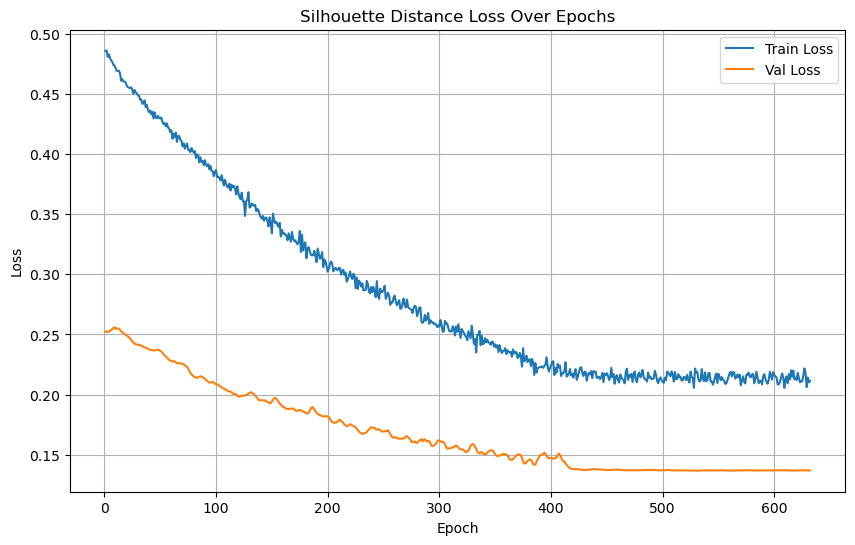

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/41], Loss: 0.1907
Test Batch [20/41], Loss: 0.1760


Test Batch [30/41], Loss: 0.4300
Test Batch [40/41], Loss: 0.0881

Test Loss: 0.2090


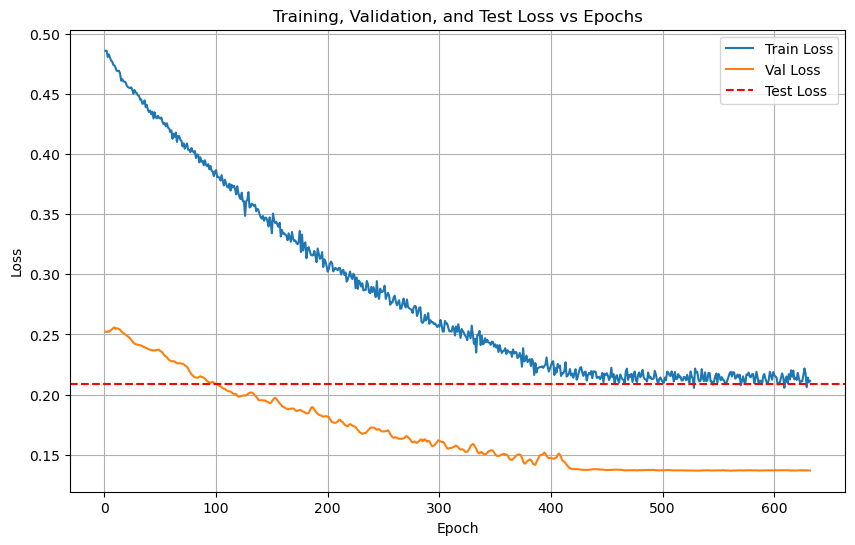

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/41 for test dataset.
  Processed batch 20/41 for test dataset.


  Processed batch 30/41 for test dataset.


  Processed batch 40/41 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 94.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.60      0.75         5
           5       0.62      1.00      0.77         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      0.60      0.75         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (560, 128)
Train labels shape: (560,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2618, 128)
Test labels shape: (2618,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8753  |  Val Loss: 2.7786
Validation loss improved from inf to 2.7786.
[Epoch 2/1000] Train Loss: 2.7491  |  Val Loss: 2.6832
Validation loss improved from 2.7786 to 2.6832.
[Epoch 3/1000] Train Loss: 2.6512  |  Val Loss: 2.6050
Validation loss improved from 2.6832 to 2.6050.
[Epoch 4/1000] Train Loss: 2.5667  |  Val Loss: 2.5283
Validation loss improved from 2.6050 to 2.5283.
[Epoch 5/1000] Train Loss: 2.4866  |  Val Loss: 2.4554
Validation loss improved from 2.5283 to 2.4554.


[Epoch 6/1000] Train Loss: 2.4093  |  Val Loss: 2.3806
Validation loss improved from 2.4554 to 2.3806.
[Epoch 7/1000] Train Loss: 2.3290  |  Val Loss: 2.3066
Validation loss improved from 2.3806 to 2.3066.
[Epoch 8/1000] Train Loss: 2.2534  |  Val Loss: 2.2389
Validation loss improved from 2.3066 to 2.2389.
[Epoch 9/1000] Train Loss: 2.1885  |  Val Loss: 2.1855
Validation loss improved from 2.2389 to 2.1855.
[Epoch 10/1000] Train Loss: 2.1361  |  Val Loss: 2.1414
Validation loss improved from 2.1855 to 2.1414.


[Epoch 11/1000] Train Loss: 2.0901  |  Val Loss: 2.1022
Validation loss improved from 2.1414 to 2.1022.


[Epoch 12/1000] Train Loss: 2.0479  |  Val Loss: 2.0655
Validation loss improved from 2.1022 to 2.0655.
[Epoch 13/1000] Train Loss: 2.0087  |  Val Loss: 2.0297
Validation loss improved from 2.0655 to 2.0297.
[Epoch 14/1000] Train Loss: 1.9695  |  Val Loss: 1.9945
Validation loss improved from 2.0297 to 1.9945.
[Epoch 15/1000] Train Loss: 1.9300  |  Val Loss: 1.9590
Validation loss improved from 1.9945 to 1.9590.
[Epoch 16/1000] Train Loss: 1.8898  |  Val Loss: 1.9231
Validation loss improved from 1.9590 to 1.9231.
[Epoch 17/1000] Train Loss: 1.8500  |  Val Loss: 1.8866
Validation loss improved from 1.9231 to 1.8866.


[Epoch 18/1000] Train Loss: 1.8098  |  Val Loss: 1.8491
Validation loss improved from 1.8866 to 1.8491.
[Epoch 19/1000] Train Loss: 1.7680  |  Val Loss: 1.8118
Validation loss improved from 1.8491 to 1.8118.
[Epoch 20/1000] Train Loss: 1.7259  |  Val Loss: 1.7734
Validation loss improved from 1.8118 to 1.7734.
[Epoch 21/1000] Train Loss: 1.6823  |  Val Loss: 1.7330
Validation loss improved from 1.7734 to 1.7330.
[Epoch 22/1000] Train Loss: 1.6367  |  Val Loss: 1.6919
Validation loss improved from 1.7330 to 1.6919.


[Epoch 23/1000] Train Loss: 1.5911  |  Val Loss: 1.6497
Validation loss improved from 1.6919 to 1.6497.
[Epoch 24/1000] Train Loss: 1.5442  |  Val Loss: 1.6071
Validation loss improved from 1.6497 to 1.6071.
[Epoch 25/1000] Train Loss: 1.4976  |  Val Loss: 1.5626
Validation loss improved from 1.6071 to 1.5626.
[Epoch 26/1000] Train Loss: 1.4482  |  Val Loss: 1.5180
Validation loss improved from 1.5626 to 1.5180.
[Epoch 27/1000] Train Loss: 1.3994  |  Val Loss: 1.4726
Validation loss improved from 1.5180 to 1.4726.
[Epoch 28/1000] Train Loss: 1.3505  |  Val Loss: 1.4271
Validation loss improved from 1.4726 to 1.4271.
[Epoch 29/1000] Train Loss: 1.3004  |  Val Loss: 1.3809
Validation loss improved from 1.4271 to 1.3809.


[Epoch 30/1000] Train Loss: 1.2509  |  Val Loss: 1.3356
Validation loss improved from 1.3809 to 1.3356.
[Epoch 31/1000] Train Loss: 1.2014  |  Val Loss: 1.2901
Validation loss improved from 1.3356 to 1.2901.
[Epoch 32/1000] Train Loss: 1.1519  |  Val Loss: 1.2456
Validation loss improved from 1.2901 to 1.2456.
[Epoch 33/1000] Train Loss: 1.1034  |  Val Loss: 1.2012
Validation loss improved from 1.2456 to 1.2012.


[Epoch 34/1000] Train Loss: 1.0556  |  Val Loss: 1.1572
Validation loss improved from 1.2012 to 1.1572.
[Epoch 35/1000] Train Loss: 1.0086  |  Val Loss: 1.1141
Validation loss improved from 1.1572 to 1.1141.
[Epoch 36/1000] Train Loss: 0.9632  |  Val Loss: 1.0721
Validation loss improved from 1.1141 to 1.0721.
[Epoch 37/1000] Train Loss: 0.9189  |  Val Loss: 1.0317
Validation loss improved from 1.0721 to 1.0317.
[Epoch 38/1000] Train Loss: 0.8765  |  Val Loss: 0.9924
Validation loss improved from 1.0317 to 0.9924.
[Epoch 39/1000] Train Loss: 0.8359  |  Val Loss: 0.9551
Validation loss improved from 0.9924 to 0.9551.


[Epoch 40/1000] Train Loss: 0.7971  |  Val Loss: 0.9183
Validation loss improved from 0.9551 to 0.9183.
[Epoch 41/1000] Train Loss: 0.7594  |  Val Loss: 0.8831
Validation loss improved from 0.9183 to 0.8831.
[Epoch 42/1000] Train Loss: 0.7236  |  Val Loss: 0.8488
Validation loss improved from 0.8831 to 0.8488.
[Epoch 43/1000] Train Loss: 0.6884  |  Val Loss: 0.8168
Validation loss improved from 0.8488 to 0.8168.
[Epoch 44/1000] Train Loss: 0.6548  |  Val Loss: 0.7850
Validation loss improved from 0.8168 to 0.7850.


[Epoch 45/1000] Train Loss: 0.6225  |  Val Loss: 0.7551
Validation loss improved from 0.7850 to 0.7551.
[Epoch 46/1000] Train Loss: 0.5916  |  Val Loss: 0.7269
Validation loss improved from 0.7551 to 0.7269.
[Epoch 47/1000] Train Loss: 0.5621  |  Val Loss: 0.6992
Validation loss improved from 0.7269 to 0.6992.
[Epoch 48/1000] Train Loss: 0.5341  |  Val Loss: 0.6732
Validation loss improved from 0.6992 to 0.6732.
[Epoch 49/1000] Train Loss: 0.5065  |  Val Loss: 0.6483
Validation loss improved from 0.6732 to 0.6483.
[Epoch 50/1000] Train Loss: 0.4807  |  Val Loss: 0.6245
Validation loss improved from 0.6483 to 0.6245.


[Epoch 51/1000] Train Loss: 0.4557  |  Val Loss: 0.6026
Validation loss improved from 0.6245 to 0.6026.
[Epoch 52/1000] Train Loss: 0.4324  |  Val Loss: 0.5816
Validation loss improved from 0.6026 to 0.5816.
[Epoch 53/1000] Train Loss: 0.4102  |  Val Loss: 0.5599
Validation loss improved from 0.5816 to 0.5599.
[Epoch 54/1000] Train Loss: 0.3889  |  Val Loss: 0.5412
Validation loss improved from 0.5599 to 0.5412.
[Epoch 55/1000] Train Loss: 0.3688  |  Val Loss: 0.5238
Validation loss improved from 0.5412 to 0.5238.


[Epoch 56/1000] Train Loss: 0.3503  |  Val Loss: 0.5080
Validation loss improved from 0.5238 to 0.5080.
[Epoch 57/1000] Train Loss: 0.3331  |  Val Loss: 0.4928
Validation loss improved from 0.5080 to 0.4928.
[Epoch 58/1000] Train Loss: 0.3166  |  Val Loss: 0.4796
Validation loss improved from 0.4928 to 0.4796.
[Epoch 59/1000] Train Loss: 0.3014  |  Val Loss: 0.4645
Validation loss improved from 0.4796 to 0.4645.
[Epoch 60/1000] Train Loss: 0.2869  |  Val Loss: 0.4521
Validation loss improved from 0.4645 to 0.4521.
[Epoch 61/1000] Train Loss: 0.2734  |  Val Loss: 0.4406
Validation loss improved from 0.4521 to 0.4406.
[Epoch 62/1000] Train Loss: 0.2610  |  Val Loss: 0.4320
Validation loss improved from 0.4406 to 0.4320.


[Epoch 63/1000] Train Loss: 0.2495  |  Val Loss: 0.4205
Validation loss improved from 0.4320 to 0.4205.
[Epoch 64/1000] Train Loss: 0.2387  |  Val Loss: 0.4114
Validation loss improved from 0.4205 to 0.4114.
[Epoch 65/1000] Train Loss: 0.2286  |  Val Loss: 0.4036
Validation loss improved from 0.4114 to 0.4036.
[Epoch 66/1000] Train Loss: 0.2191  |  Val Loss: 0.3956
Validation loss improved from 0.4036 to 0.3956.
[Epoch 67/1000] Train Loss: 0.2105  |  Val Loss: 0.3869
Validation loss improved from 0.3956 to 0.3869.
[Epoch 68/1000] Train Loss: 0.2025  |  Val Loss: 0.3817
Validation loss improved from 0.3869 to 0.3817.


[Epoch 69/1000] Train Loss: 0.1947  |  Val Loss: 0.3748
Validation loss improved from 0.3817 to 0.3748.
[Epoch 70/1000] Train Loss: 0.1878  |  Val Loss: 0.3683
Validation loss improved from 0.3748 to 0.3683.
[Epoch 71/1000] Train Loss: 0.1810  |  Val Loss: 0.3640
Validation loss improved from 0.3683 to 0.3640.
[Epoch 72/1000] Train Loss: 0.1745  |  Val Loss: 0.3593
Validation loss improved from 0.3640 to 0.3593.
[Epoch 73/1000] Train Loss: 0.1687  |  Val Loss: 0.3549
Validation loss improved from 0.3593 to 0.3549.
[Epoch 74/1000] Train Loss: 0.1631  |  Val Loss: 0.3510
Validation loss improved from 0.3549 to 0.3510.


[Epoch 75/1000] Train Loss: 0.1579  |  Val Loss: 0.3455
Validation loss improved from 0.3510 to 0.3455.
[Epoch 76/1000] Train Loss: 0.1528  |  Val Loss: 0.3402
Validation loss improved from 0.3455 to 0.3402.
[Epoch 77/1000] Train Loss: 0.1482  |  Val Loss: 0.3346
Validation loss improved from 0.3402 to 0.3346.
[Epoch 78/1000] Train Loss: 0.1438  |  Val Loss: 0.3325
Validation loss improved from 0.3346 to 0.3325.
[Epoch 79/1000] Train Loss: 0.1395  |  Val Loss: 0.3298
Validation loss improved from 0.3325 to 0.3298.


[Epoch 80/1000] Train Loss: 0.1358  |  Val Loss: 0.3291
Validation loss improved from 0.3298 to 0.3291.
[Epoch 81/1000] Train Loss: 0.1318  |  Val Loss: 0.3248
Validation loss improved from 0.3291 to 0.3248.
[Epoch 82/1000] Train Loss: 0.1282  |  Val Loss: 0.3206
Validation loss improved from 0.3248 to 0.3206.
[Epoch 83/1000] Train Loss: 0.1247  |  Val Loss: 0.3167
Validation loss improved from 0.3206 to 0.3167.
[Epoch 84/1000] Train Loss: 0.1214  |  Val Loss: 0.3144
Validation loss improved from 0.3167 to 0.3144.
[Epoch 85/1000] Train Loss: 0.1183  |  Val Loss: 0.3121
Validation loss improved from 0.3144 to 0.3121.
[Epoch 86/1000] Train Loss: 0.1153  |  Val Loss: 0.3095
Validation loss improved from 0.3121 to 0.3095.


[Epoch 87/1000] Train Loss: 0.1124  |  Val Loss: 0.3079
Validation loss improved from 0.3095 to 0.3079.
[Epoch 88/1000] Train Loss: 0.1096  |  Val Loss: 0.3062
Validation loss improved from 0.3079 to 0.3062.
[Epoch 89/1000] Train Loss: 0.1071  |  Val Loss: 0.3050
Validation loss improved from 0.3062 to 0.3050.
[Epoch 90/1000] Train Loss: 0.1047  |  Val Loss: 0.3054
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 91/1000] Train Loss: 0.1021  |  Val Loss: 0.3029
Validation loss improved from 0.3050 to 0.3029.
[Epoch 92/1000] Train Loss: 0.0997  |  Val Loss: 0.3014
Validation loss improved from 0.3029 to 0.3014.
[Epoch 93/1000] Train Loss: 0.0976  |  Val Loss: 0.2992
Validation loss improved from 0.3014 to 0.2992.
[Epoch 94/1000] Train Loss: 0.0955  |  Val Loss: 0.3000
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 95/1000] Train Loss: 0.0934  |  Val Loss: 0.2984
Validation loss improved from 0.2992 to 0.2984.
[Epoch 96/1000] Train Loss: 0.0912  |  Val Loss: 0.2941
Validation loss improved from 0.2984 to 0.2941.
[Epoch 97/1000] Train Loss: 0.0893  |  Val Loss: 0.2924
Validation loss improved from 0.2941 to 0.2924.
[Epoch 98/1000] Train Loss: 0.0875  |  Val Loss: 0.2924
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 99/1000] Train Loss: 0.0854  |  Val Loss: 0.2910
Validation loss improved from 0.2924 to 0.2910.
[Epoch 100/1000] Train Loss: 0.0839  |  Val Loss: 0.2899
Validation loss improved from 0.2910 to 0.2899.
[Epoch 101/1000] Train Loss: 0.0821  |  Val Loss: 0.2872
Validation loss improved from 0.2899 to 0.2872.
[Epoch 102/1000] Train Loss: 0.0805  |  Val Loss: 0.2850
Validation loss improved from 0.2872 to 0.2850.
[Epoch 103/1000] Train Loss: 0.0790  |  Val Loss: 0.2871
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 104/1000] Train Loss: 0.0772  |  Val Loss: 0.2856
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 105/1000] Train Loss: 0.0759  |  Val Loss: 0.2844
Validation loss improved from 0.2850 to 0.2844.
[Epoch 106/1000] Train Loss: 0.0743  |  Val Loss: 0.2865
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 107/1000] Train Loss: 0.0729  |  Val Loss: 0.2838
Validation loss improved from 0.2844 to 0.2838.
[Epoch 108/1000] Train Loss: 0.0716  |  Val Loss: 0.2827
Validation loss improved from 0.2838 to 0.2827.
[Epoch 109/1000] Train Loss: 0.0702  |  Val Loss: 0.2841
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/1000] Train Loss: 0.0689  |  Val Loss: 0.2838
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 111/1000] Train Loss: 0.0677  |  Val Loss: 0.2815
Validation loss improved from 0.2827 to 0.2815.
[Epoch 112/1000] Train Loss: 0.0664  |  Val Loss: 0.2786
Validation loss improved from 0.2815 to 0.2786.
[Epoch 113/1000] Train Loss: 0.0653  |  Val Loss: 0.2793
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 114/1000] Train Loss: 0.0640  |  Val Loss: 0.2815
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 115/1000] Train Loss: 0.0628  |  Val Loss: 0.2802
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 116/1000] Train Loss: 0.0617  |  Val Loss: 0.2808
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 117/1000] Train Loss: 0.0606  |  Val Loss: 0.2792
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 118/1000] Train Loss: 0.0596  |  Val Loss: 0.2763
Validation loss improved from 0.2786 to 0.2763.
[Epoch 119/1000] Train Loss: 0.0586  |  Val Loss: 0.2783
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 120/1000] Train Loss: 0.0576  |  Val Loss: 0.2786
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 121/1000] Train Loss: 0.0566  |  Val Loss: 0.2765
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 122/1000] Train Loss: 0.0556  |  Val Loss: 0.2748
Validation loss improved from 0.2763 to 0.2748.
[Epoch 123/1000] Train Loss: 0.0547  |  Val Loss: 0.2762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 0.0538  |  Val Loss: 0.2761
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 125/1000] Train Loss: 0.0530  |  Val Loss: 0.2734
Validation loss improved from 0.2748 to 0.2734.
[Epoch 126/1000] Train Loss: 0.0521  |  Val Loss: 0.2728
Validation loss improved from 0.2734 to 0.2728.


[Epoch 127/1000] Train Loss: 0.0513  |  Val Loss: 0.2747
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 0.0505  |  Val Loss: 0.2742
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 129/1000] Train Loss: 0.0497  |  Val Loss: 0.2767
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 130/1000] Train Loss: 0.0489  |  Val Loss: 0.2748
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 131/1000] Train Loss: 0.0481  |  Val Loss: 0.2741
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 132/1000] Train Loss: 0.0473  |  Val Loss: 0.2727
Validation loss improved from 0.2728 to 0.2727.
[Epoch 133/1000] Train Loss: 0.0468  |  Val Loss: 0.2762
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 134/1000] Train Loss: 0.0460  |  Val Loss: 0.2762
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/1000] Train Loss: 0.0452  |  Val Loss: 0.2749
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 136/1000] Train Loss: 0.0444  |  Val Loss: 0.2740
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 137/1000] Train Loss: 0.0438  |  Val Loss: 0.2730
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 138/1000] Train Loss: 0.0431  |  Val Loss: 0.2721
Validation loss improved from 0.2727 to 0.2721.


[Epoch 139/1000] Train Loss: 0.0425  |  Val Loss: 0.2726
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Loss: 0.0419  |  Val Loss: 0.2724
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 141/1000] Train Loss: 0.0413  |  Val Loss: 0.2721
Validation loss improved from 0.2721 to 0.2721.
[Epoch 142/1000] Train Loss: 0.0407  |  Val Loss: 0.2742
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 143/1000] Train Loss: 0.0401  |  Val Loss: 0.2724
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 144/1000] Train Loss: 0.0396  |  Val Loss: 0.2750
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 145/1000] Train Loss: 0.0390  |  Val Loss: 0.2732
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 146/1000] Train Loss: 0.0385  |  Val Loss: 0.2702
Validation loss improved from 0.2721 to 0.2702.
[Epoch 147/1000] Train Loss: 0.0380  |  Val Loss: 0.2719
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 148/1000] Train Loss: 0.0375  |  Val Loss: 0.2725
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 149/1000] Train Loss: 0.0370  |  Val Loss: 0.2697
Validation loss improved from 0.2702 to 0.2697.
[Epoch 150/1000] Train Loss: 0.0363  |  Val Loss: 0.2729
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 151/1000] Train Loss: 0.0359  |  Val Loss: 0.2726
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/1000] Train Loss: 0.0354  |  Val Loss: 0.2734
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 153/1000] Train Loss: 0.0349  |  Val Loss: 0.2716
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 154/1000] Train Loss: 0.0343  |  Val Loss: 0.2721
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 155/1000] Train Loss: 0.0340  |  Val Loss: 0.2736
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 156/1000] Train Loss: 0.0334  |  Val Loss: 0.2729
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 157/1000] Train Loss: 0.0331  |  Val Loss: 0.2714
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 158/1000] Train Loss: 0.0326  |  Val Loss: 0.2734
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 159/1000] Train Loss: 0.0321  |  Val Loss: 0.2725
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 160/1000] Train Loss: 0.0318  |  Val Loss: 0.2724
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 161/1000] Train Loss: 0.0313  |  Val Loss: 0.2726
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 162/1000] Train Loss: 0.0309  |  Val Loss: 0.2723
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 163/1000] Train Loss: 0.0306  |  Val Loss: 0.2744
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 164/1000] Train Loss: 0.0302  |  Val Loss: 0.2719
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 165/1000] Train Loss: 0.0298  |  Val Loss: 0.2719
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 166/1000] Train Loss: 0.0294  |  Val Loss: 0.2727
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 167/1000] Train Loss: 0.0290  |  Val Loss: 0.2727
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 168/1000] Train Loss: 0.0288  |  Val Loss: 0.2766
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 169/1000] Train Loss: 0.0284  |  Val Loss: 0.2748
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 170/1000] Train Loss: 0.0280  |  Val Loss: 0.2719
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 171/1000] Train Loss: 0.0276  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 172/1000] Train Loss: 0.0274  |  Val Loss: 0.2752
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 173/1000] Train Loss: 0.0270  |  Val Loss: 0.2751
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 174/1000] Train Loss: 0.0266  |  Val Loss: 0.2736
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 175/1000] Train Loss: 0.0264  |  Val Loss: 0.2752
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 176/1000] Train Loss: 0.0260  |  Val Loss: 0.2732
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 177/1000] Train Loss: 0.0258  |  Val Loss: 0.2708
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 178/1000] Train Loss: 0.0255  |  Val Loss: 0.2772
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 179/1000] Train Loss: 0.0252  |  Val Loss: 0.2759
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 180/1000] Train Loss: 0.0248  |  Val Loss: 0.2756
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 181/1000] Train Loss: 0.0245  |  Val Loss: 0.2761
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 182/1000] Train Loss: 0.0243  |  Val Loss: 0.2773
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 183/1000] Train Loss: 0.0240  |  Val Loss: 0.2786
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 184/1000] Train Loss: 0.0237  |  Val Loss: 0.2756
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 185/1000] Train Loss: 0.0235  |  Val Loss: 0.2788
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 186/1000] Train Loss: 0.0233  |  Val Loss: 0.2746
!! Validation loss did NOT improve !! Patience: 37/100


[Epoch 187/1000] Train Loss: 0.0229  |  Val Loss: 0.2781
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 188/1000] Train Loss: 0.0226  |  Val Loss: 0.2782
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 189/1000] Train Loss: 0.0224  |  Val Loss: 0.2778
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 190/1000] Train Loss: 0.0221  |  Val Loss: 0.2792
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 191/1000] Train Loss: 0.0219  |  Val Loss: 0.2799
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 192/1000] Train Loss: 0.0217  |  Val Loss: 0.2783
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 193/1000] Train Loss: 0.0214  |  Val Loss: 0.2783
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 194/1000] Train Loss: 0.0212  |  Val Loss: 0.2782
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 195/1000] Train Loss: 0.0209  |  Val Loss: 0.2795
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 196/1000] Train Loss: 0.0207  |  Val Loss: 0.2791
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 197/1000] Train Loss: 0.0205  |  Val Loss: 0.2795
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 198/1000] Train Loss: 0.0203  |  Val Loss: 0.2817
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 199/1000] Train Loss: 0.0201  |  Val Loss: 0.2788
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 200/1000] Train Loss: 0.0198  |  Val Loss: 0.2798
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 201/1000] Train Loss: 0.0196  |  Val Loss: 0.2825
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 202/1000] Train Loss: 0.0194  |  Val Loss: 0.2821
!! Validation loss did NOT improve !! Patience: 53/100


[Epoch 203/1000] Train Loss: 0.0192  |  Val Loss: 0.2801
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 204/1000] Train Loss: 0.0190  |  Val Loss: 0.2830
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 205/1000] Train Loss: 0.0187  |  Val Loss: 0.2836
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 206/1000] Train Loss: 0.0187  |  Val Loss: 0.2800
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 207/1000] Train Loss: 0.0184  |  Val Loss: 0.2800
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 208/1000] Train Loss: 0.0182  |  Val Loss: 0.2816
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 209/1000] Train Loss: 0.0180  |  Val Loss: 0.2854
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 210/1000] Train Loss: 0.0178  |  Val Loss: 0.2831
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 211/1000] Train Loss: 0.0176  |  Val Loss: 0.2829
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 212/1000] Train Loss: 0.0174  |  Val Loss: 0.2851
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 213/1000] Train Loss: 0.0172  |  Val Loss: 0.2835
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 214/1000] Train Loss: 0.0171  |  Val Loss: 0.2843
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 215/1000] Train Loss: 0.0169  |  Val Loss: 0.2865
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 216/1000] Train Loss: 0.0167  |  Val Loss: 0.2843
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 217/1000] Train Loss: 0.0166  |  Val Loss: 0.2851
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 218/1000] Train Loss: 0.0164  |  Val Loss: 0.2865
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 219/1000] Train Loss: 0.0163  |  Val Loss: 0.2846
!! Validation loss did NOT improve !! Patience: 70/100


[Epoch 220/1000] Train Loss: 0.0161  |  Val Loss: 0.2876
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 221/1000] Train Loss: 0.0159  |  Val Loss: 0.2877
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 222/1000] Train Loss: 0.0158  |  Val Loss: 0.2896
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 223/1000] Train Loss: 0.0156  |  Val Loss: 0.2854
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 224/1000] Train Loss: 0.0156  |  Val Loss: 0.2858
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 225/1000] Train Loss: 0.0153  |  Val Loss: 0.2866
!! Validation loss did NOT improve !! Patience: 76/100


[Epoch 226/1000] Train Loss: 0.0152  |  Val Loss: 0.2881
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 227/1000] Train Loss: 0.0150  |  Val Loss: 0.2870
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 228/1000] Train Loss: 0.0149  |  Val Loss: 0.2892
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 229/1000] Train Loss: 0.0147  |  Val Loss: 0.2870
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 230/1000] Train Loss: 0.0146  |  Val Loss: 0.2895
!! Validation loss did NOT improve !! Patience: 81/100


[Epoch 231/1000] Train Loss: 0.0145  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 232/1000] Train Loss: 0.0143  |  Val Loss: 0.2903
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 233/1000] Train Loss: 0.0142  |  Val Loss: 0.2918
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 234/1000] Train Loss: 0.0141  |  Val Loss: 0.2894
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 235/1000] Train Loss: 0.0139  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 236/1000] Train Loss: 0.0137  |  Val Loss: 0.2894
!! Validation loss did NOT improve !! Patience: 87/100


[Epoch 237/1000] Train Loss: 0.0136  |  Val Loss: 0.2904
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 238/1000] Train Loss: 0.0135  |  Val Loss: 0.2948
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 239/1000] Train Loss: 0.0134  |  Val Loss: 0.2935
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 240/1000] Train Loss: 0.0133  |  Val Loss: 0.2908
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 241/1000] Train Loss: 0.0131  |  Val Loss: 0.2918
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 242/1000] Train Loss: 0.0131  |  Val Loss: 0.2933
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 243/1000] Train Loss: 0.0129  |  Val Loss: 0.2944
!! Validation loss did NOT improve !! Patience: 94/100


[Epoch 244/1000] Train Loss: 0.0128  |  Val Loss: 0.2934
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 245/1000] Train Loss: 0.0127  |  Val Loss: 0.2947
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 246/1000] Train Loss: 0.0125  |  Val Loss: 0.2930
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 247/1000] Train Loss: 0.0124  |  Val Loss: 0.2939
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 248/1000] Train Loss: 0.0123  |  Val Loss: 0.2953
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 249/1000] Train Loss: 0.0122  |  Val Loss: 0.2932
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 249 !!
No improvement for 100 epochs.


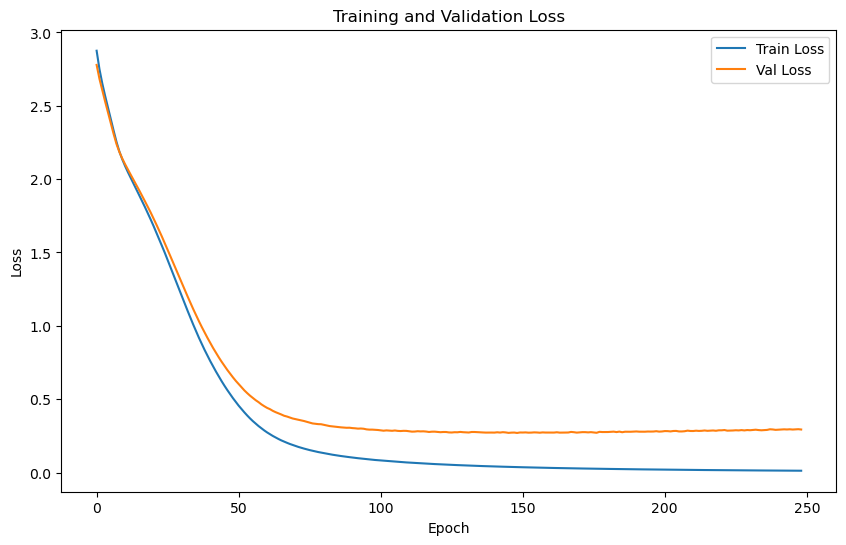

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.4599 | Test Accuracy: 87.97%


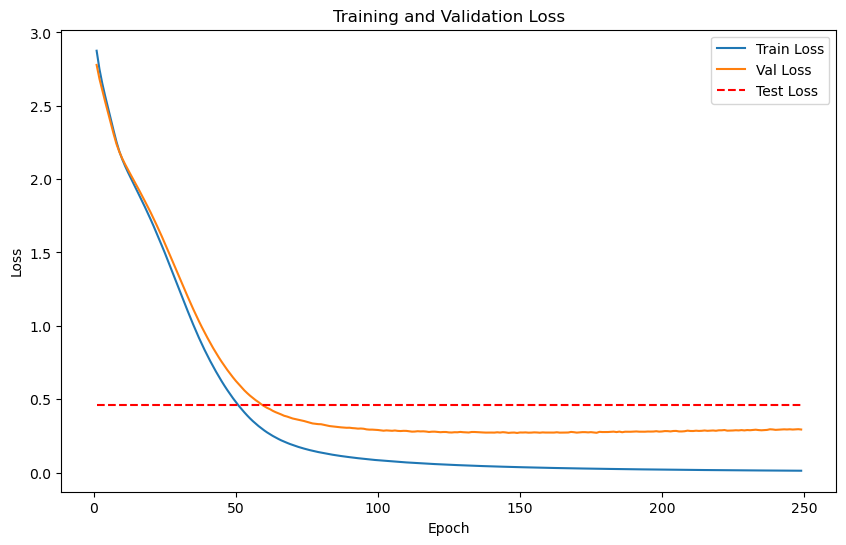

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


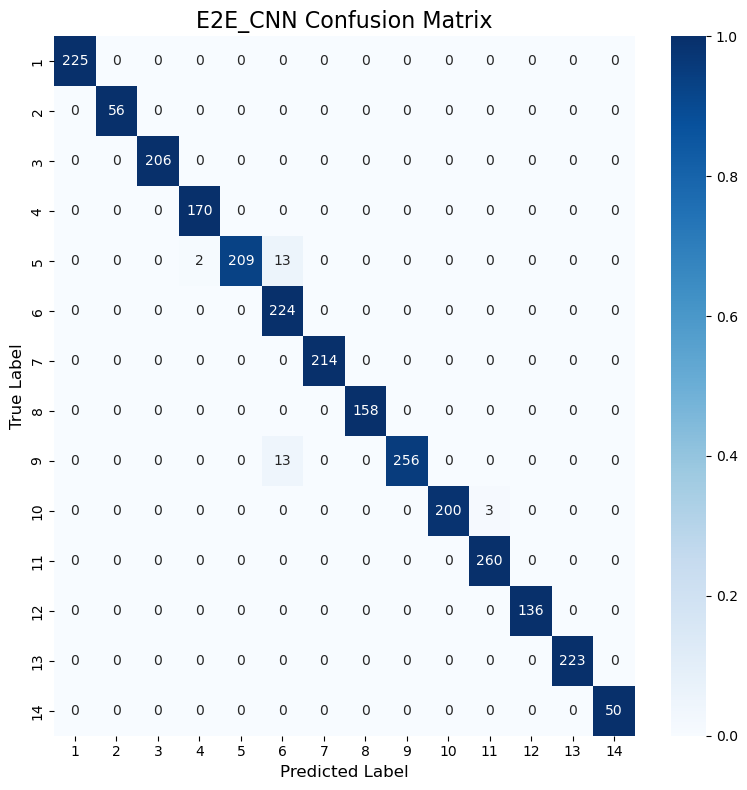

Classification Accuracy: 98.82%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


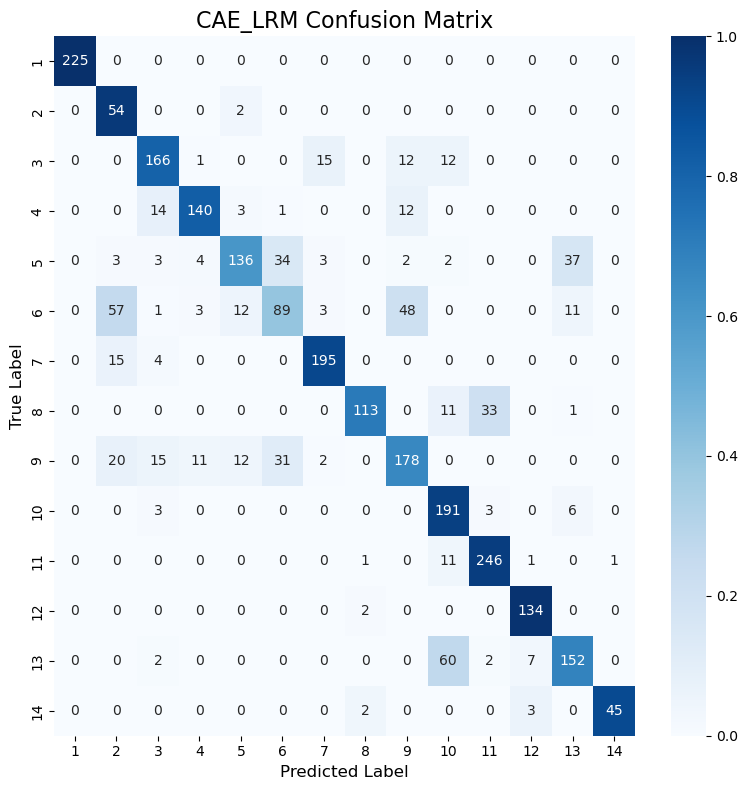

Classification Accuracy: 78.84%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


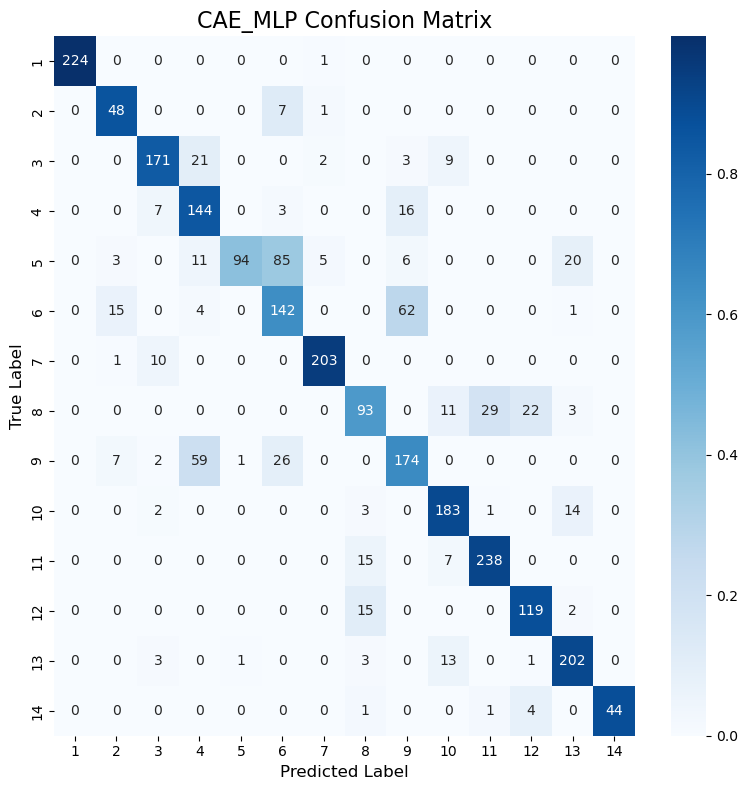

Classification Accuracy: 79.41%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


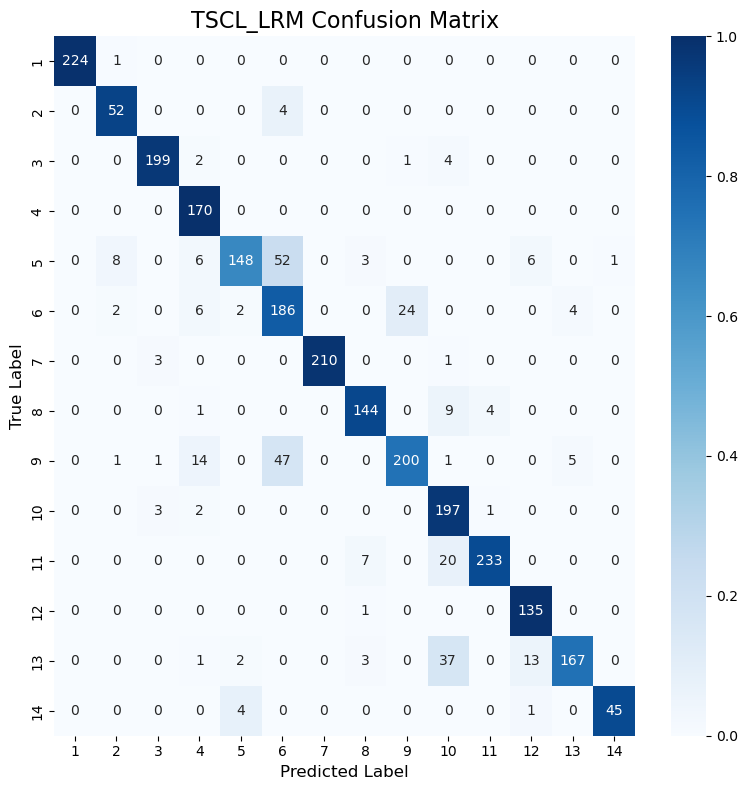

Classification Accuracy: 88.24%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


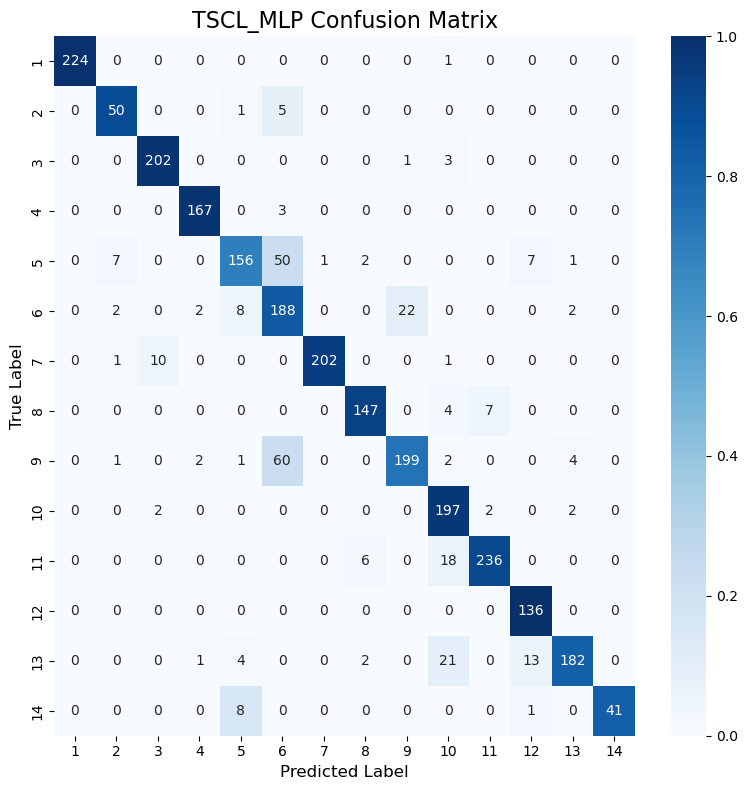

Classification Accuracy: 88.88%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


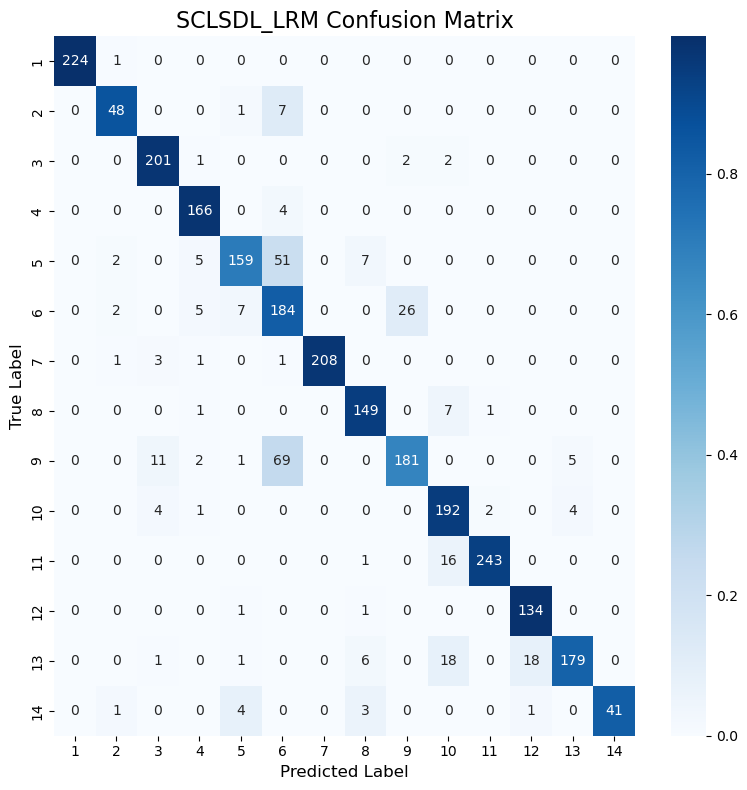

Classification Accuracy: 88.20%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


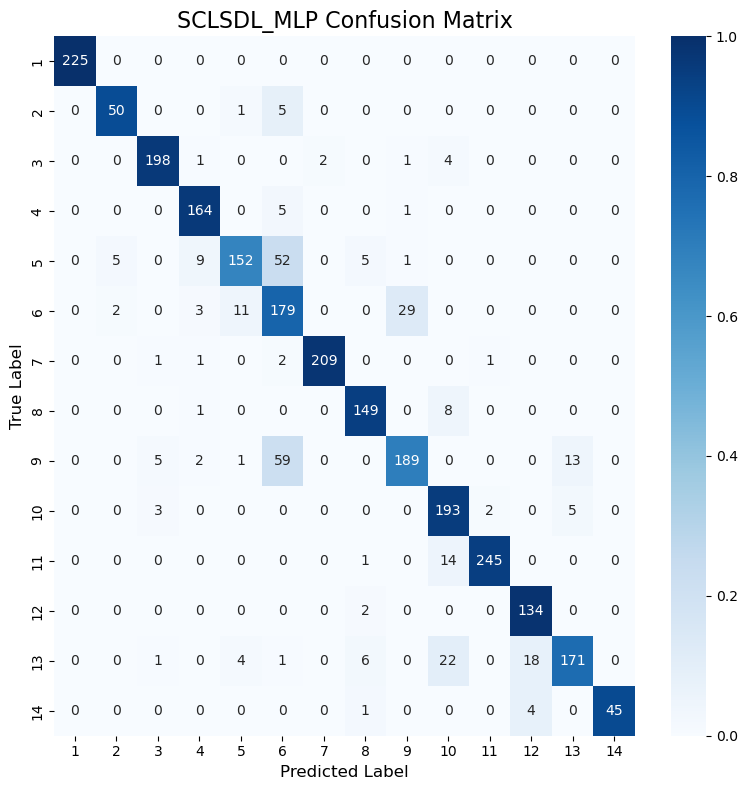

Classification Accuracy: 87.97%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.82
1    LRM (CAE)          78.84
2    MLP (CAE)          79.41
3     TSCL LRM          88.24
4     TSCL MLP          88.88
5  SCL_SDL LRM          88.20
6  SCL_SDL MLP          87.97

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.82
4     TSCL MLP          88.88
3     TSCL LRM          88.24
5  SCL_SDL LRM          88.20
6  SCL_SDL MLP          87.97
2    MLP (CAE)          79.41
1    LRM (CAE)          78.84
